In [1]:
import os, sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages')

import dicom
import numpy as np
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
# ia_rf1 = 20000
# zte_dir = os.path.join(os.getcwd(), 'data', 'DICOM', 'ia_rf1.20000')
zte_dir = os.path.join(os.path.expanduser('~'), 'Box', 'RadOnc-QMRI', 'Data', '2018-04__Studies', '20180404.MP-Mk4.0.Exp0', 'E6218', '2')
n_dicoms = len(os.listdir(zte_dir))

exam = 6218
series = 2
dcm_fn_base = 'E{:d}S{:d}'.format(exam, series) + 'I{:d}.DCM'

ref_dcm = dicom.read_file(os.path.join(zte_dir, dcm_fn_base.format(1)))

(nx, ny, nz) = (
    int(ref_dcm.Columns),
    int(ref_dcm.Rows),
    int(n_dicoms)
)

(dx, dy, dz) = (
    float(ref_dcm.PixelSpacing[0]),
    float(ref_dcm.PixelSpacing[1]),
    float(ref_dcm.SliceThickness)
)

vol = np.ndarray((nx, ny, nz), dtype=ref_dcm.pixel_array.dtype)
for zi in range(nz):
    ds = dicom.read_file(os.path.join(zte_dir, dcm_fn_base.format(zi+1)))
    vol[:, :, zi] = ds.pixel_array

#print(vol.shape, (dx, dy, dz))
#print(ds)

<Figure size 1440x1440 with 0 Axes>

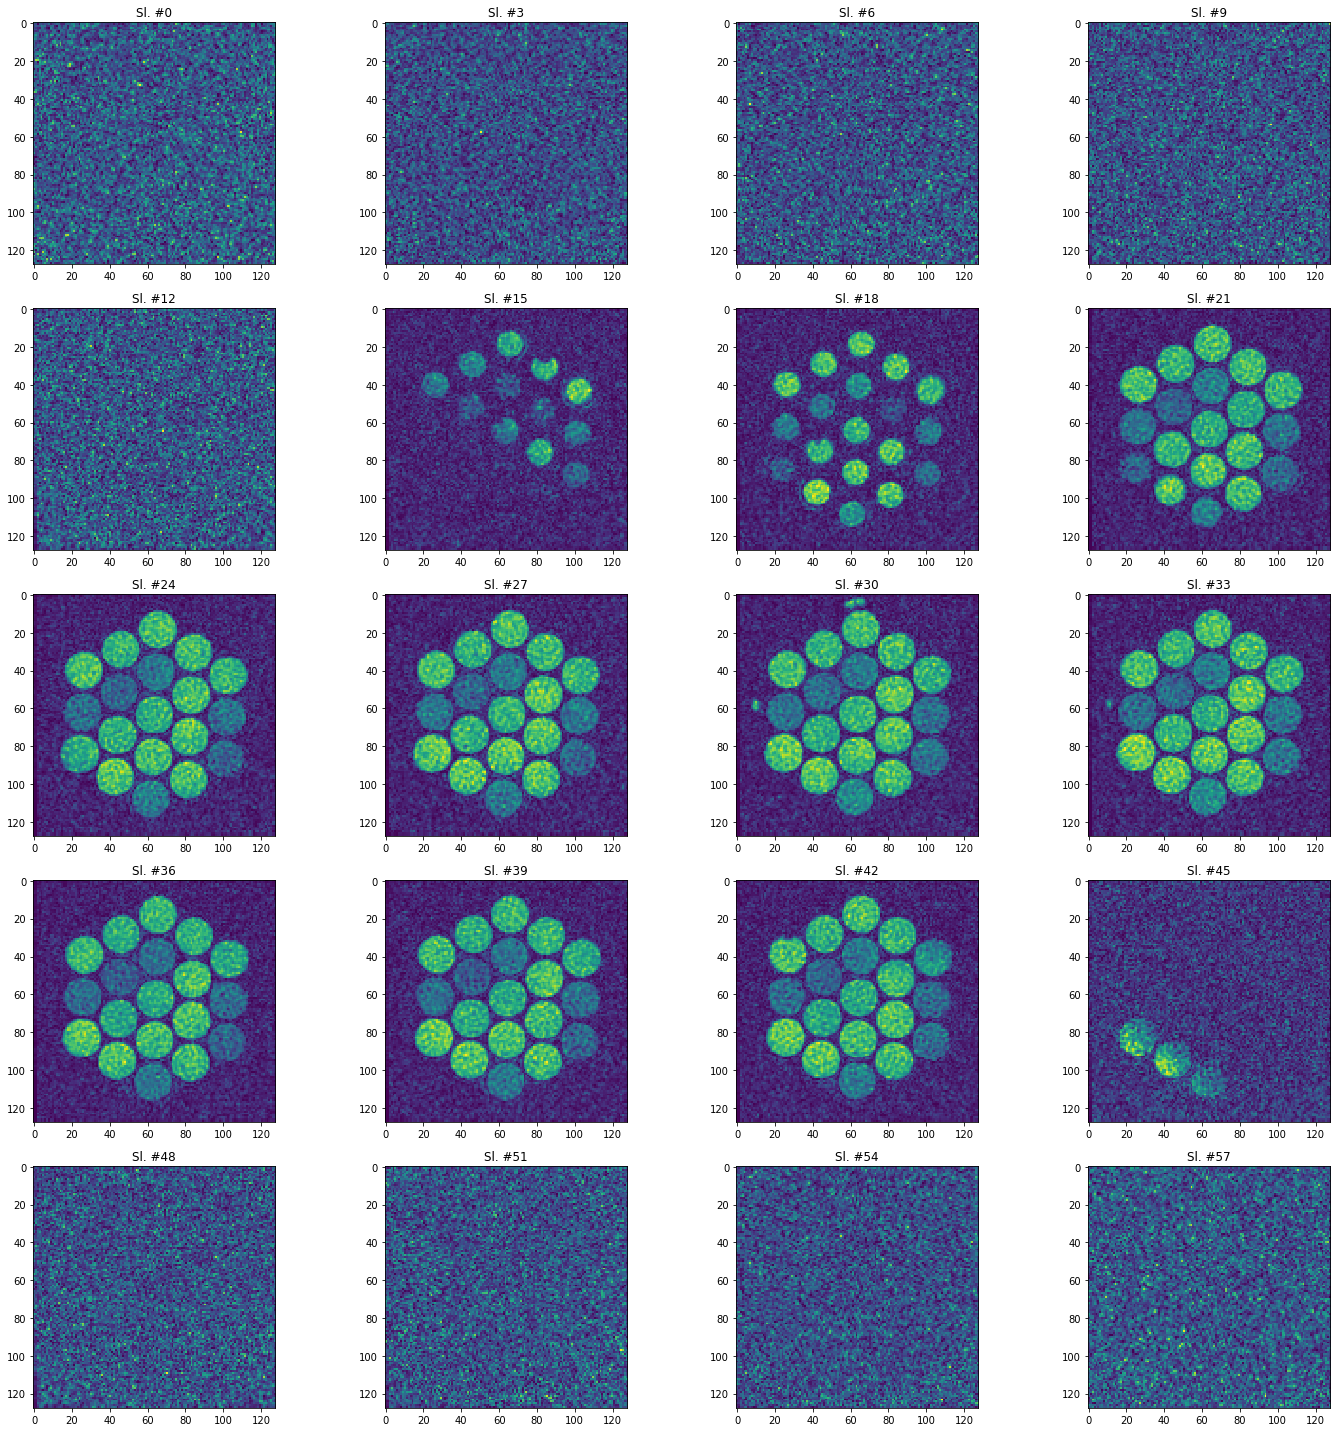

In [3]:
# plot a couple slices (sanity check)

plt.close()
plt.figure(figsize=(20.0, 20.0))

slices = np.arange(0, nz, np.ceil(nz/20), dtype=np.uint8)
#print((nx,ny,nz),axial_planes)
fig, ax = plt.subplots(5, 4, figsize=(20.0, 20.0))
for pl, zi in enumerate(slices):
    ai=ax[int(pl/4)][int(pl%4)]
    ai.imshow(vol[:,:,zi])
    ai.set_title('Sl. #{:d}'.format(zi))

fig.tight_layout()
fig.patch.set_facecolor('#ffffff')
plt.show()

fig.savefig('ia_rf1-20000.png')

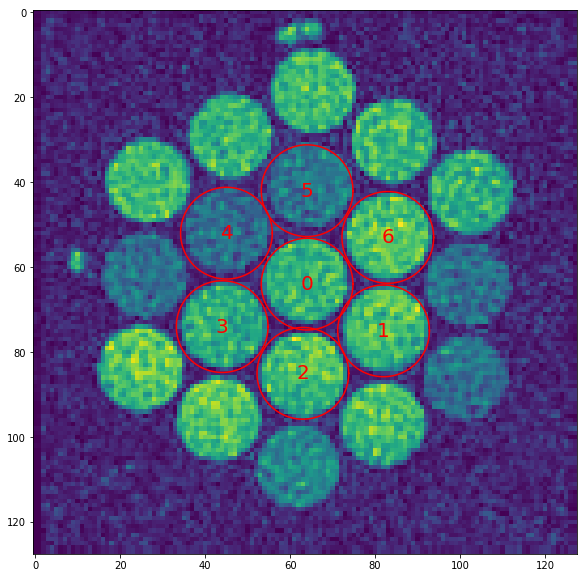

In [4]:
plt.close()
fig = plt.figure(figsize=(10.0, 10.0))

sli = 30
scl_slice = (vol[:,:,sli] - np.min(vol[:,:,sli]))/(np.max(vol[:,:,sli]) - np.min(vol[:,:,sli]))
plt.imshow(scl_slice)

rc = 13.5 # mm
cx0 = int(nx/2)
cy0 = int(ny/2)

#plt.plot(cx0, cy0, 'rx')
plt.text(cy0, cx0, '{:d}'.format(0), fontdict = {
    'color': 'red',
    'fontsize': 20,
    'horizontalalignment' : 'center',
    'verticalalignment' : 'center'
})
th = np.linspace(0.0, 2*np.pi, 100)
xx = rc/dx * np.cos(th) + cy0
yy = rc/dy * np.sin(th) + cx0
plt.plot(xx, yy, 'r')

dth = np.pi / 3.1
for ci in range(6):
    thi = dth - ci * np.pi / 3.0
    cx = int(((cx0 * dx) + (2 * rc * np.cos(thi)))/dx)
    cy = int(((cy0 * dy) + (2 * rc * np.sin(thi)))/dy)
    #plt.plot(cx, cy, 'rx')
    th = np.linspace(0.0, 2*np.pi, 100)
    xx = rc/dy * np.cos(th) + cy
    yy = rc/dx * np.sin(th) + cx
    plt.plot(xx, yy, 'r')
    plt.text(cy, cx, '{:d}'.format(ci+1), fontdict = {
        'color': 'red',
        'fontsize': 20,
        'horizontalalignment' : 'center',
        'verticalalignment' : 'center'
    })

plt.show()

fig.savefig('ia_rf1-20000_sl-{:d}.png'.format(sli))

In [5]:
# Generate ROIs

# Container dimensions
nc = 18
rc = 13.5 # Container radius (mm)
hc = 95.25 # Container height (mm) NOTE: outer dimensions

# ROI dimensions (use the approx. center)
rr = rc * 0.25
hr = hc * 0.5

# image center
im_cx = nx * dx / 2.0
im_cy = ny * dy / 2.0
im_cz = nz * dz / 2.0

# some fudge factors
del_th = np.pi / 3.1 # angle offset
cz0 = 30.0 * dz # center of 10-dram vials is at approx. axial slice 35

cy0 = im_cy + (0.0 * dy)
cx0 = im_cx + (0.0 * dx)

# ROI labels
roi_labels = [ # All updated
    '0: (D01) Deuterium Oxide 10%',
    '1: (A03.1) Isopropyl Alcohol',
    '2: (A03.2) Isopropyl Alcohol',
    '3: (W01.1) Water',
    '4: (W01.2) Water',
    '5: (A06.1) Coconut Oil',
    '6: (A06.2) Coconut Oil',
    '7: (A04.1) Propargyl Alcohol',
    '8: (A04.2) Propargyl Alcohol',
    '9: (A02.1) Acetone',
    '10: (A02.2) Acetone',
    '11: (A05.1) Gelatin',
    '12: (A05.2) Gelatin',
    '13: (B01.2)',
    '14: (B01.1)',
    '15: (D02.2) Deuterium Oxide 5%',
    '16: (D02.1) Deuterium Oxide 5%',
    '17: (D03.1) Deuterium Oxide ~2%',
    '18: (D03.2) Deuterium Oxide ~2%',
]

import roi

roi_info = []

# Center container:
roi_info.append({})
roi_info[0]['cx'] = cx0
roi_info[0]['cy'] = cy0
roi_info[0]['cz'] = cz0

roi_info[0]['ht'] = hr
roi_info[0]['rd'] = rr

roi_info[0]['mask'] = roi.CylinderROI(
    roi_info[0]['cx'],
    roi_info[0]['cy'],
    roi_info[0]['cz'],
    roi_info[0]['ht'],
    roi_info[0]['rd']
).generate_mask(nx, ny, nz, dx, dy, dz)

roi_info[0]['label'] = roi_labels[0]

# Other containers:
for ci in range(nc):
    if (ci < 12):
        if (ci % 2 == 0):
            thi = del_th - np.floor(ci/2) * np.pi / 3.0
            del_cx = 2 * rc * np.cos(thi)
            del_cy = 2 * rc * np.sin(thi)
        else:
            thi = np.pi + del_th - np.floor(ci/2) * np.pi / 3.0
            del_cx = 4 * rc * np.cos(thi)
            del_cy = 4 * rc * np.sin(thi)
    else:
        if (ci % 2 == 0):
            thi = np.pi/6.0 + del_th - np.floor(ci/2) * np.pi / 3.0
            del_cx = 2 * rc * np.cos(thi) * 2 * np.cos(np.pi / 6.0)
            del_cy = 2 * rc * np.sin(thi) * 2 * np.cos(np.pi / 6.0)
        else:
            thi = np.pi/6.0 + np.pi + del_th - np.floor(ci/2) * np.pi / 3.0
            del_cx = 2 * rc * np.cos(thi) * 2 * np.cos(np.pi / 6.0)
            del_cy = 2 * rc * np.sin(thi) * 2 * np.cos(np.pi / 6.0)
    
    roi_info.append({})
    roi_info[ci+1]['cx'] = cx0 + del_cx
    roi_info[ci+1]['cy'] = cy0 + del_cy
    roi_info[ci+1]['cz'] = cz0
    
    roi_info[ci+1]['ht'] = hr
    roi_info[ci+1]['rd'] = rr
    
    roi_info[ci+1]['mask'] = roi.CylinderROI(
        roi_info[ci+1]['cx'],
        roi_info[ci+1]['cy'],
        roi_info[ci+1]['cz'],
        roi_info[ci+1]['ht'],
        roi_info[ci+1]['rd']
    ).generate_mask(nx, ny, nz, dx, dy, dz)
    
    roi_info[ci+1]['label'] = roi_labels[ci+1]

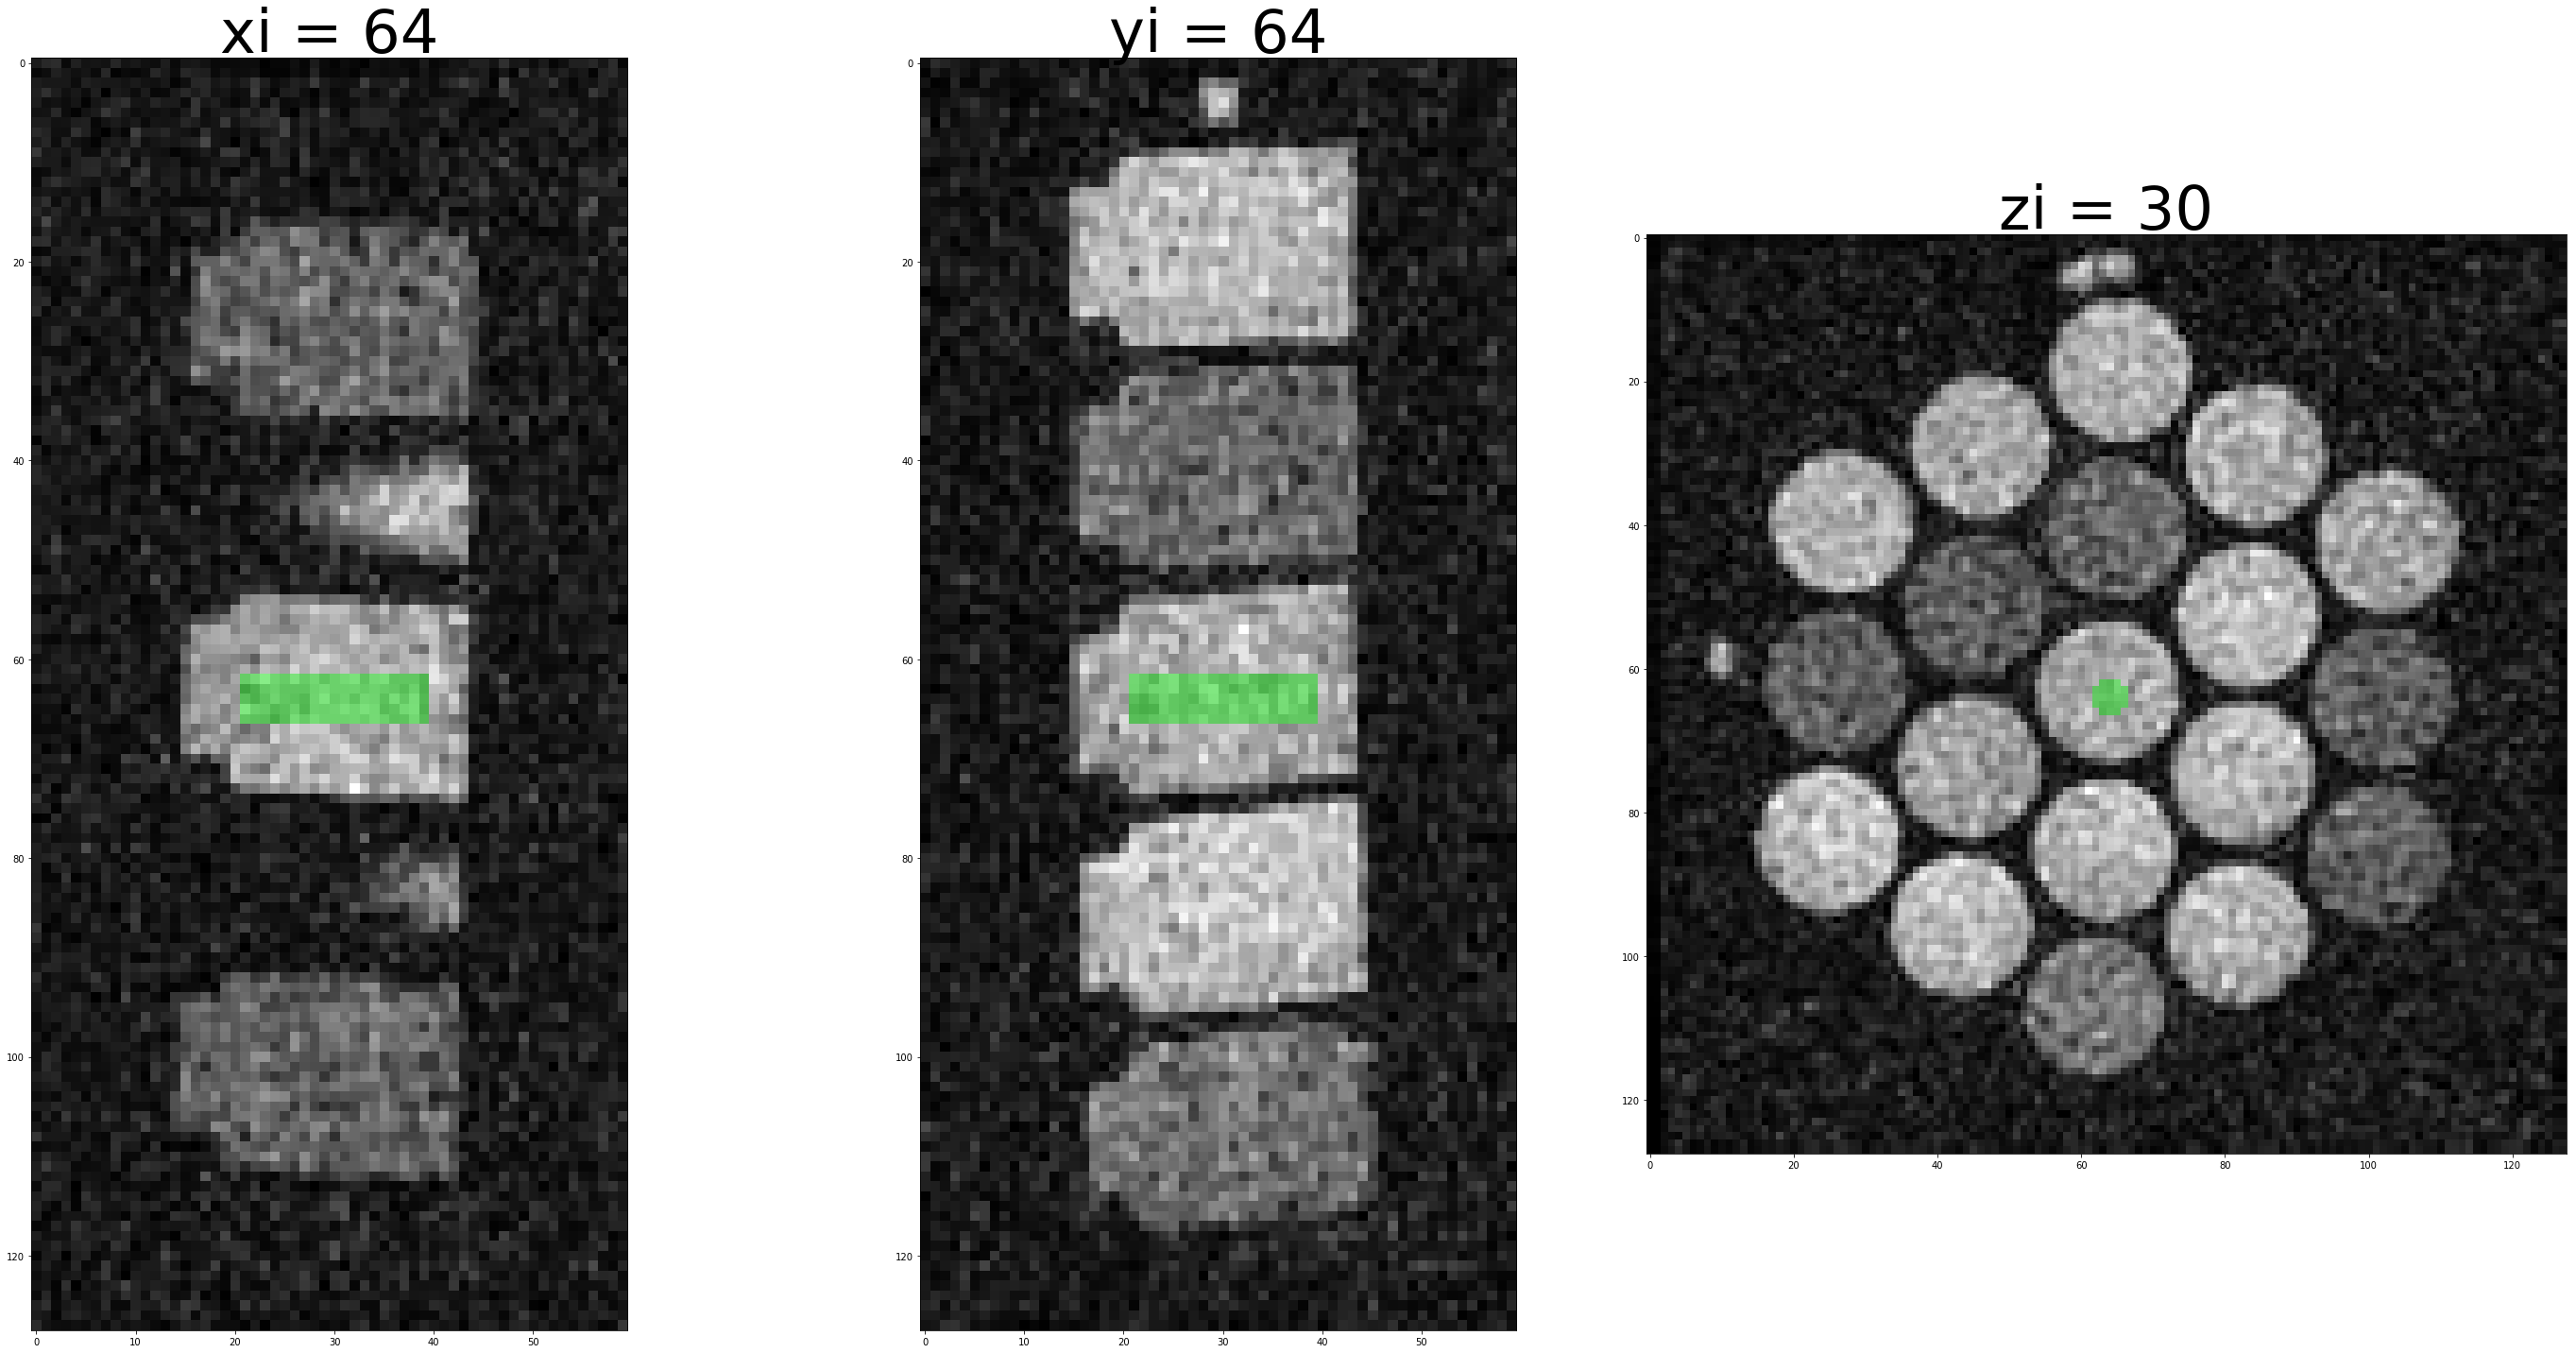

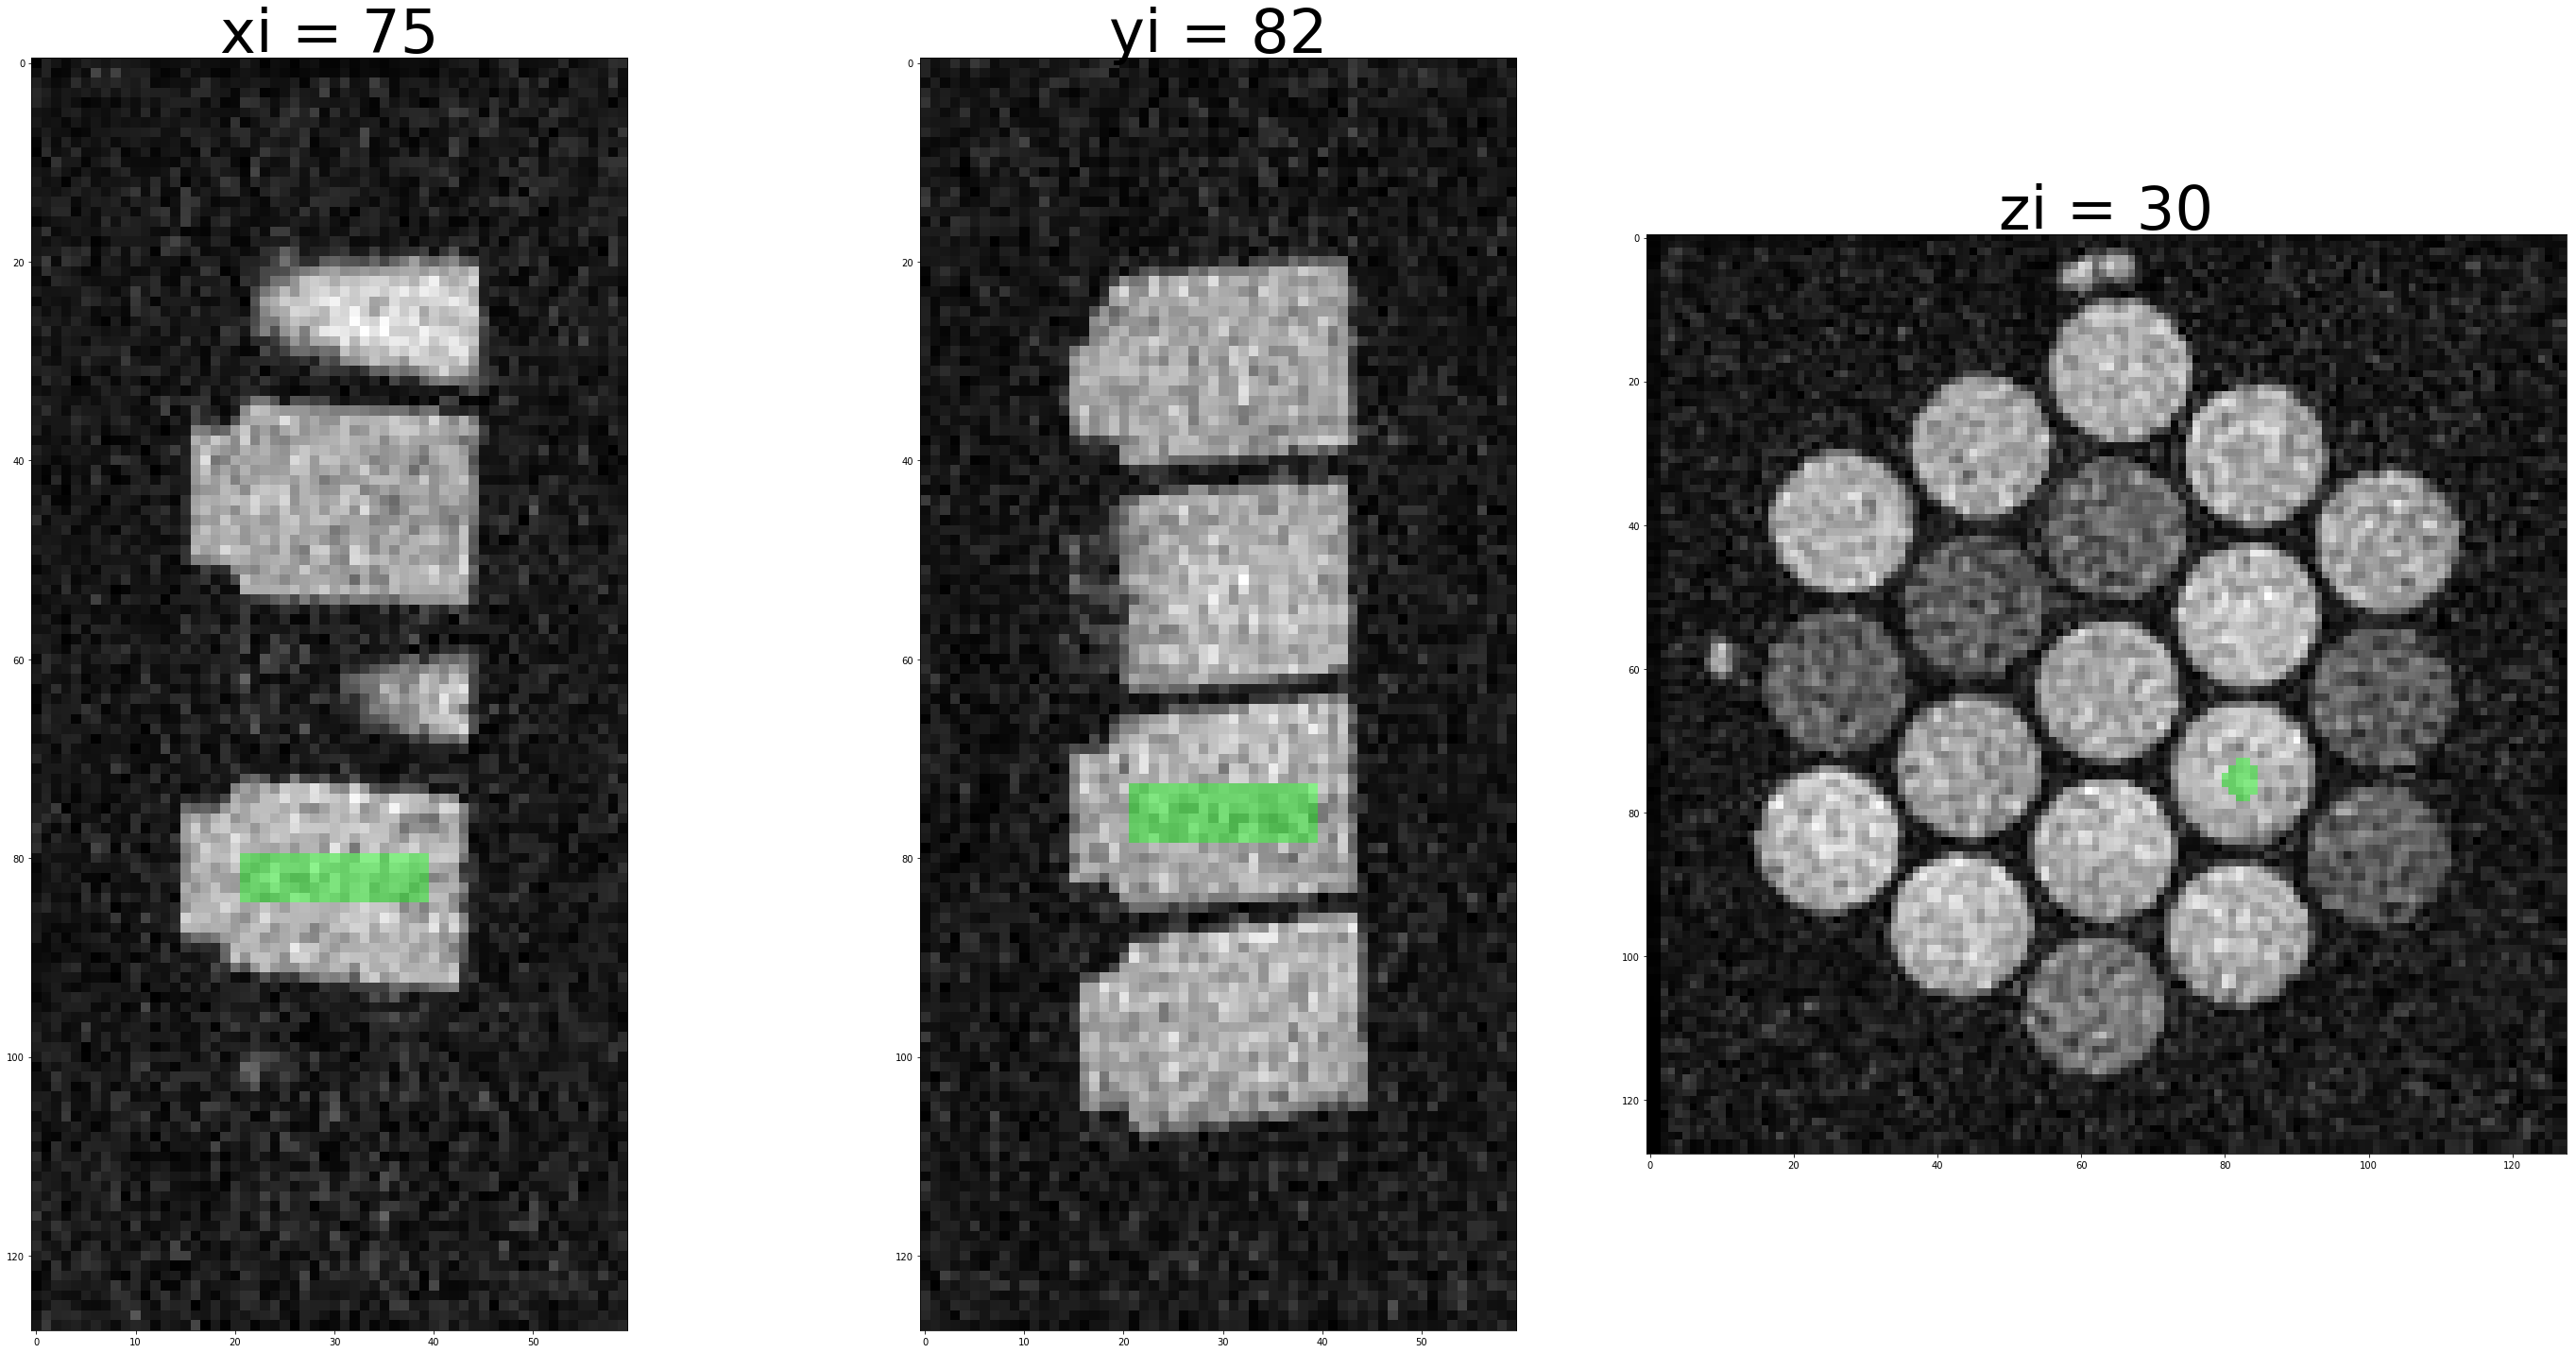

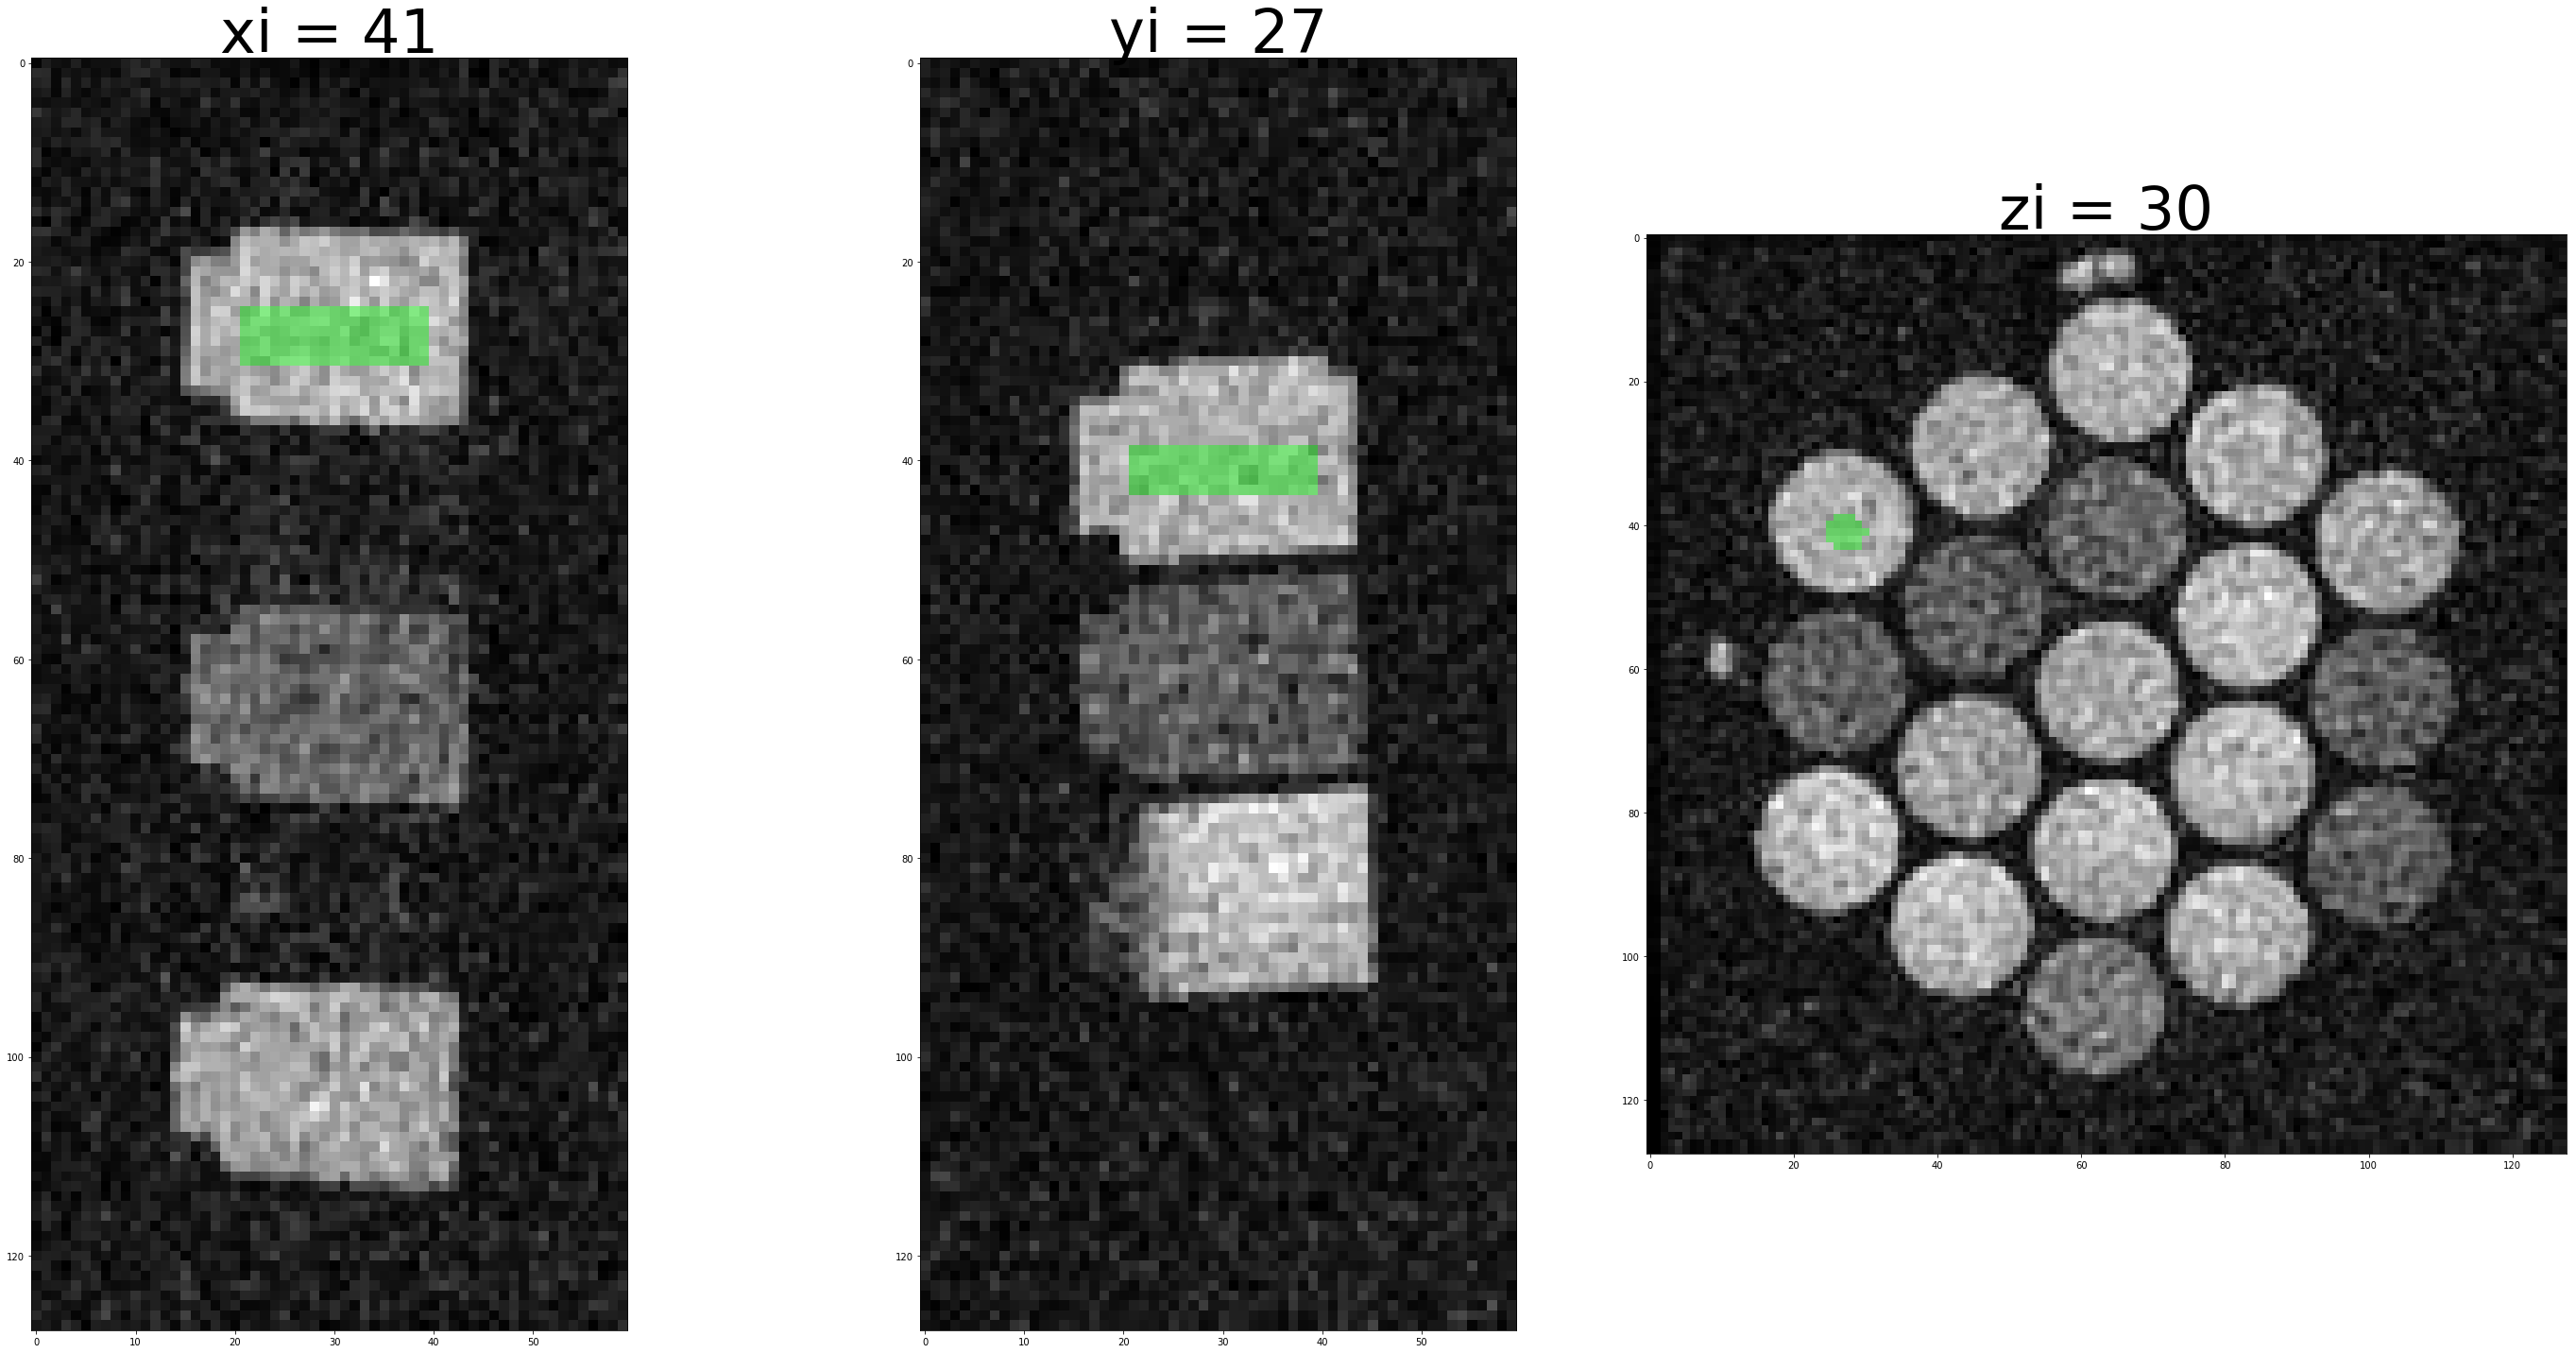

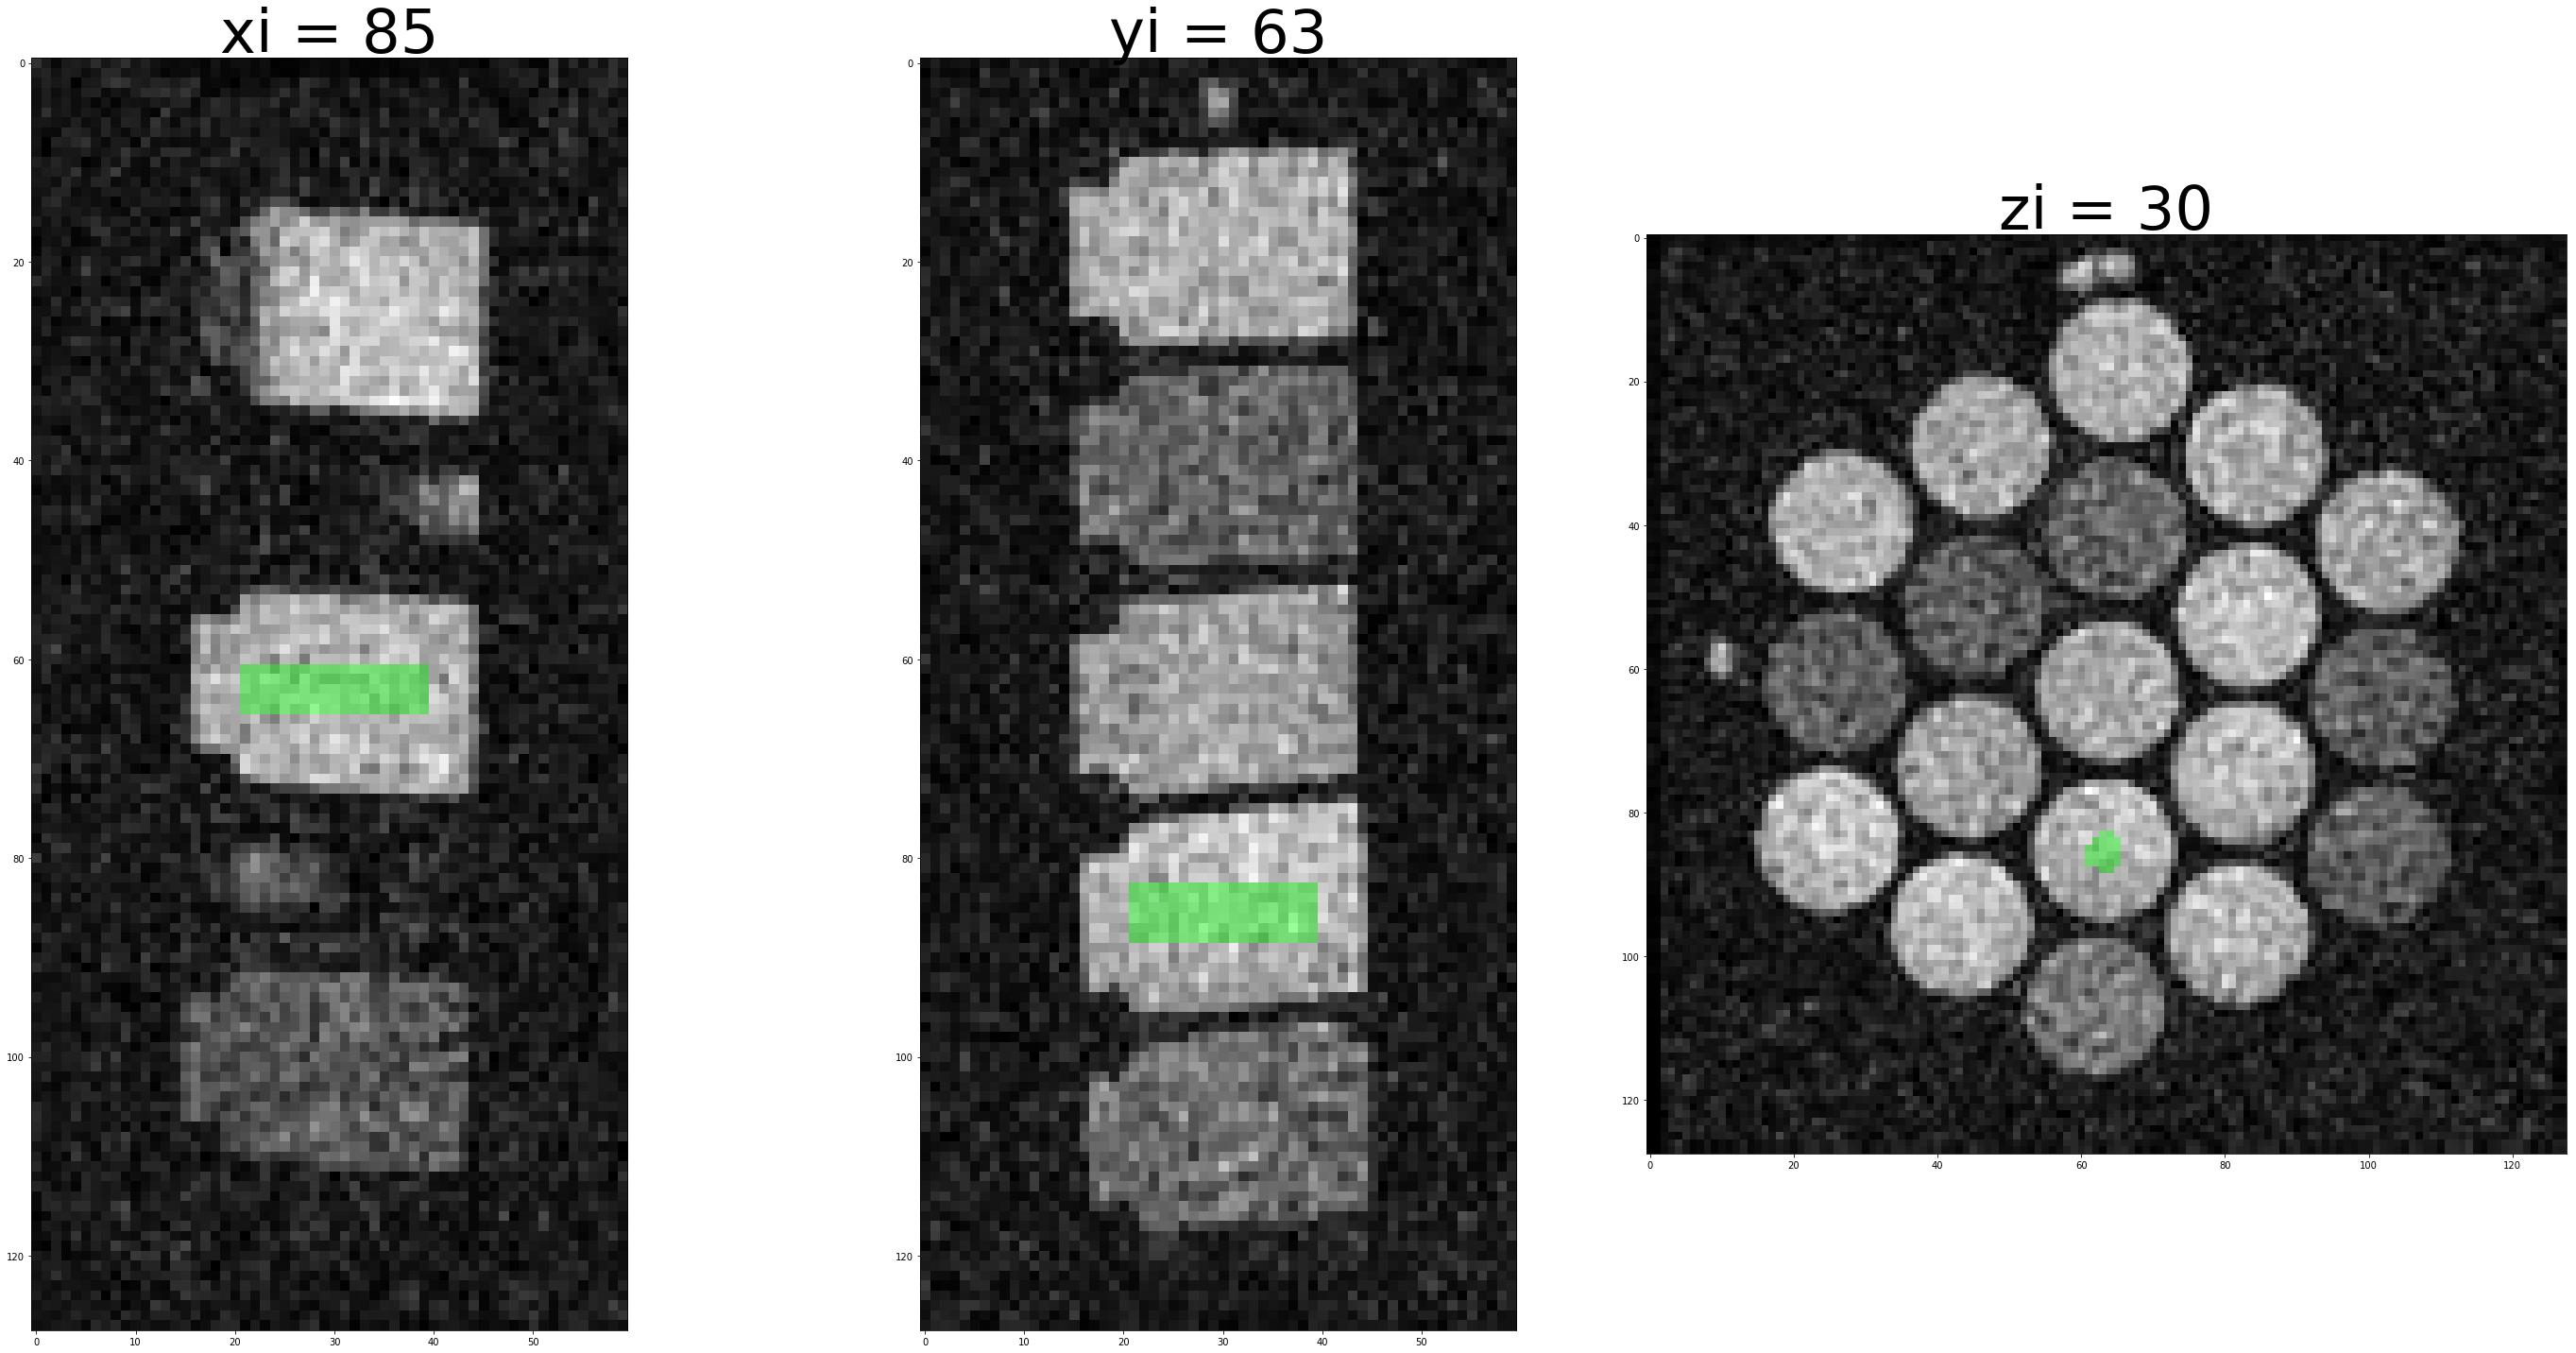

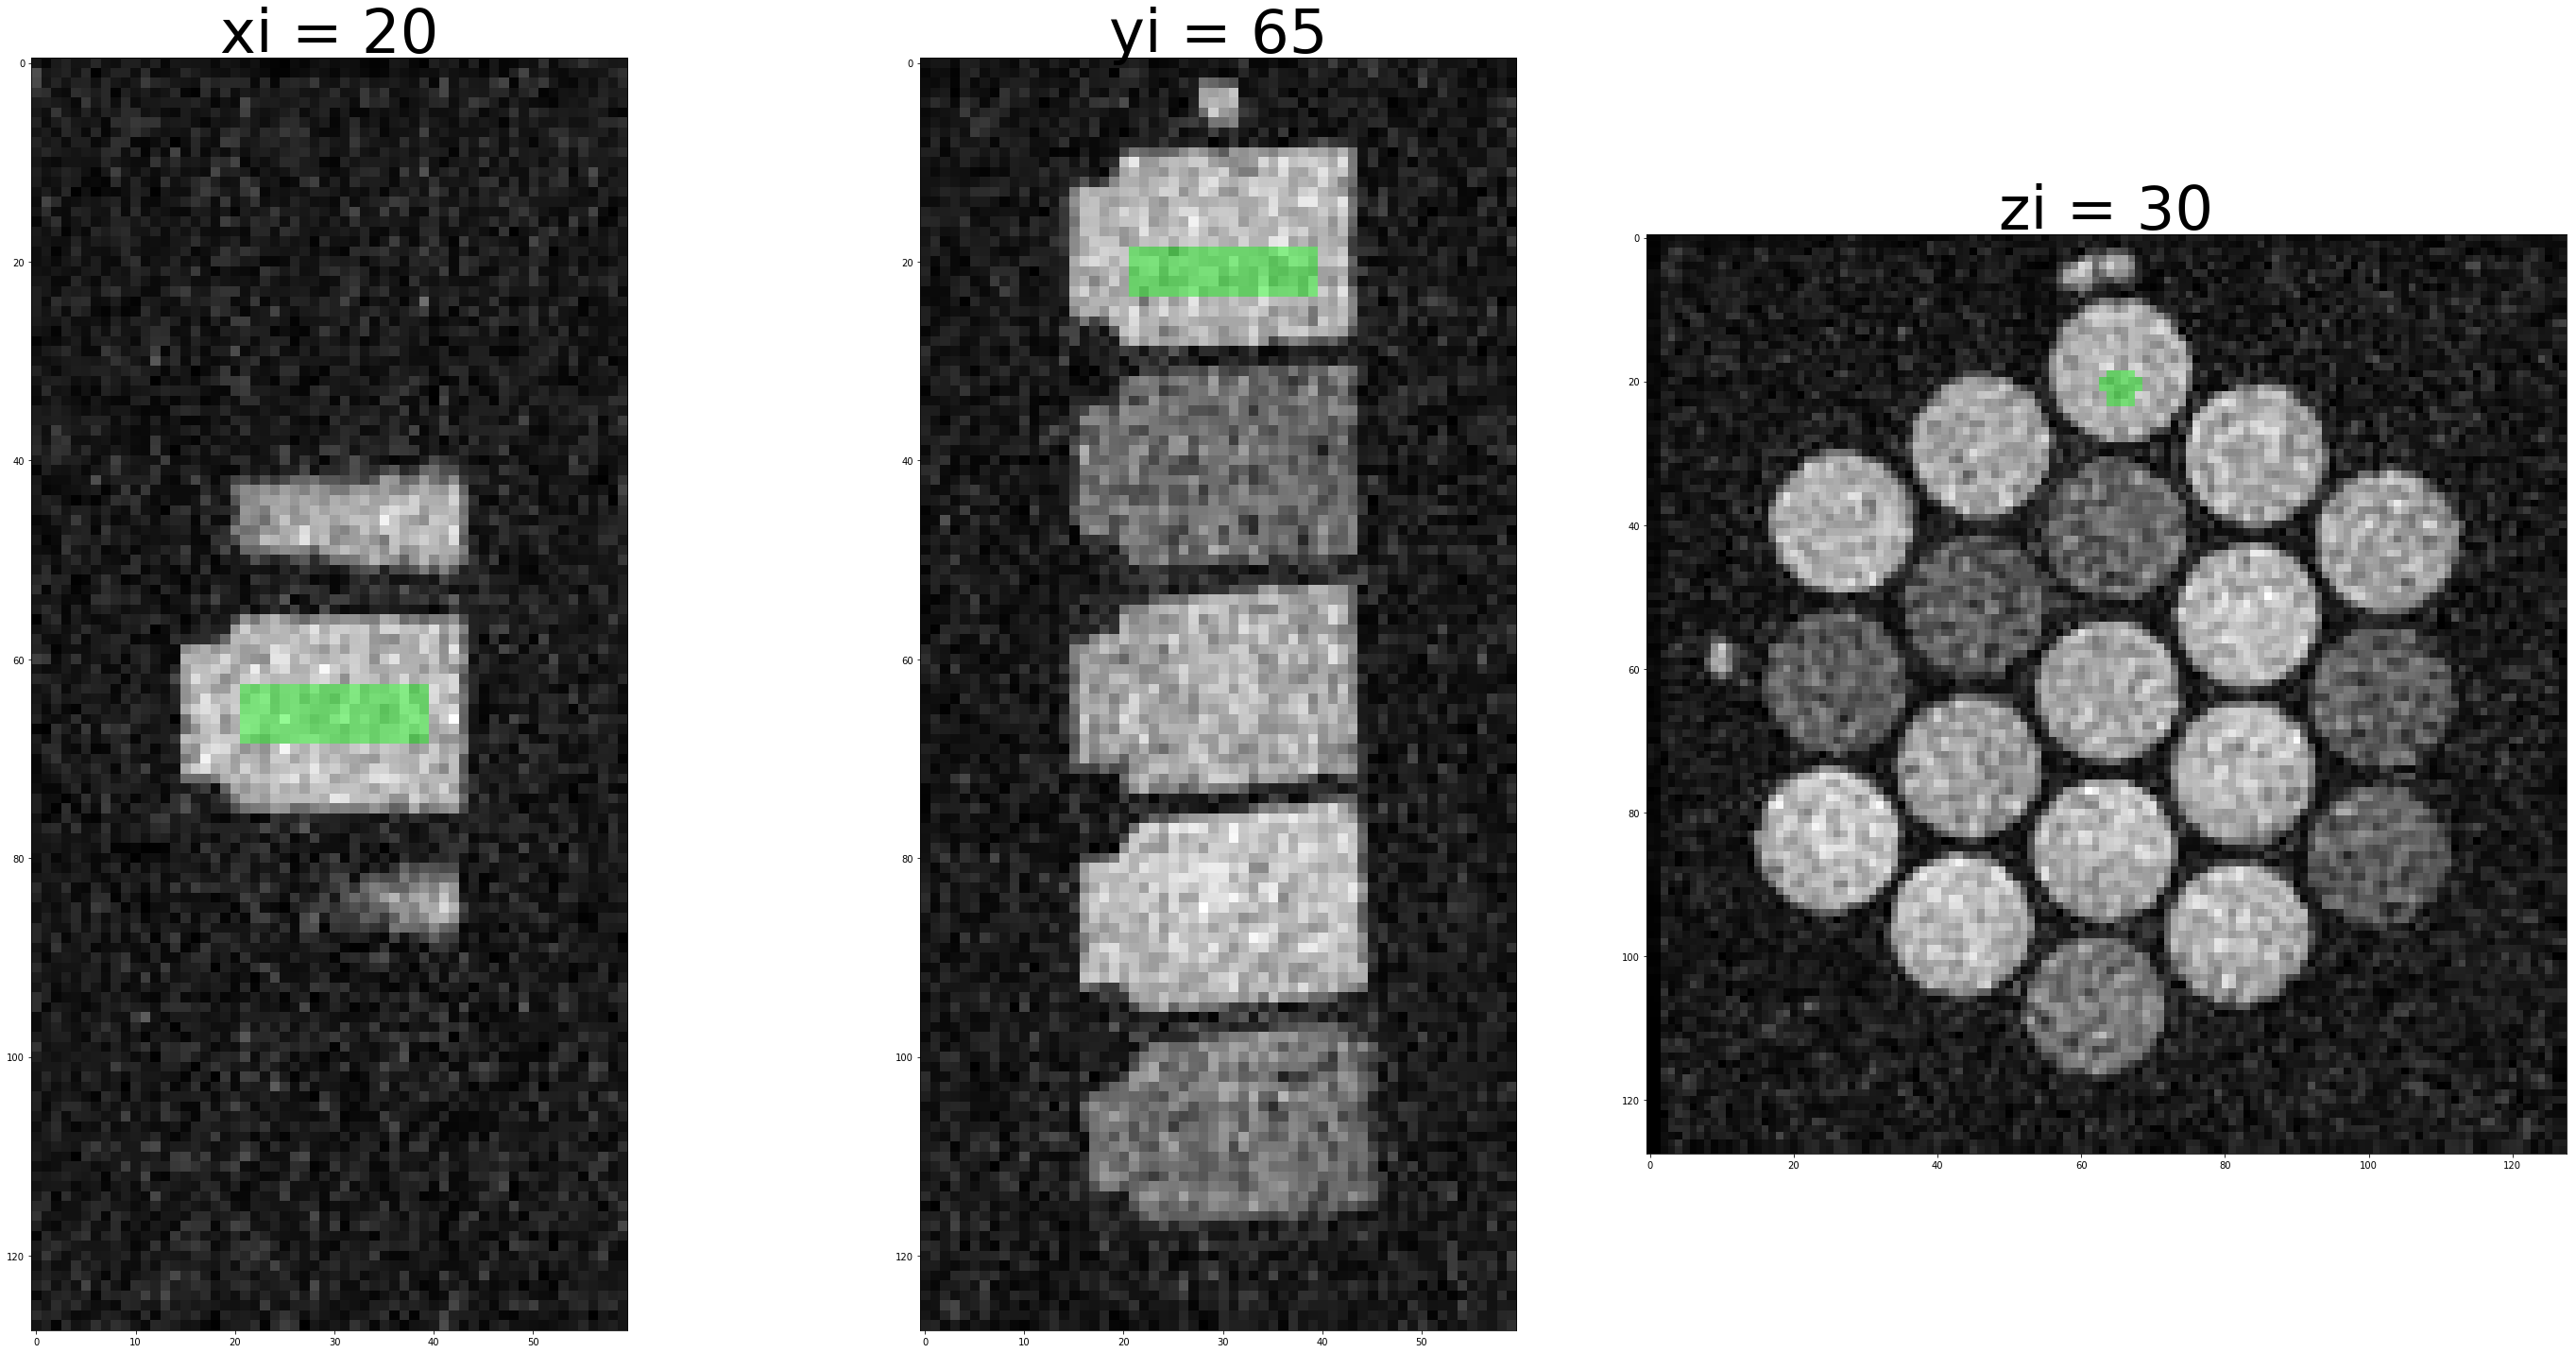

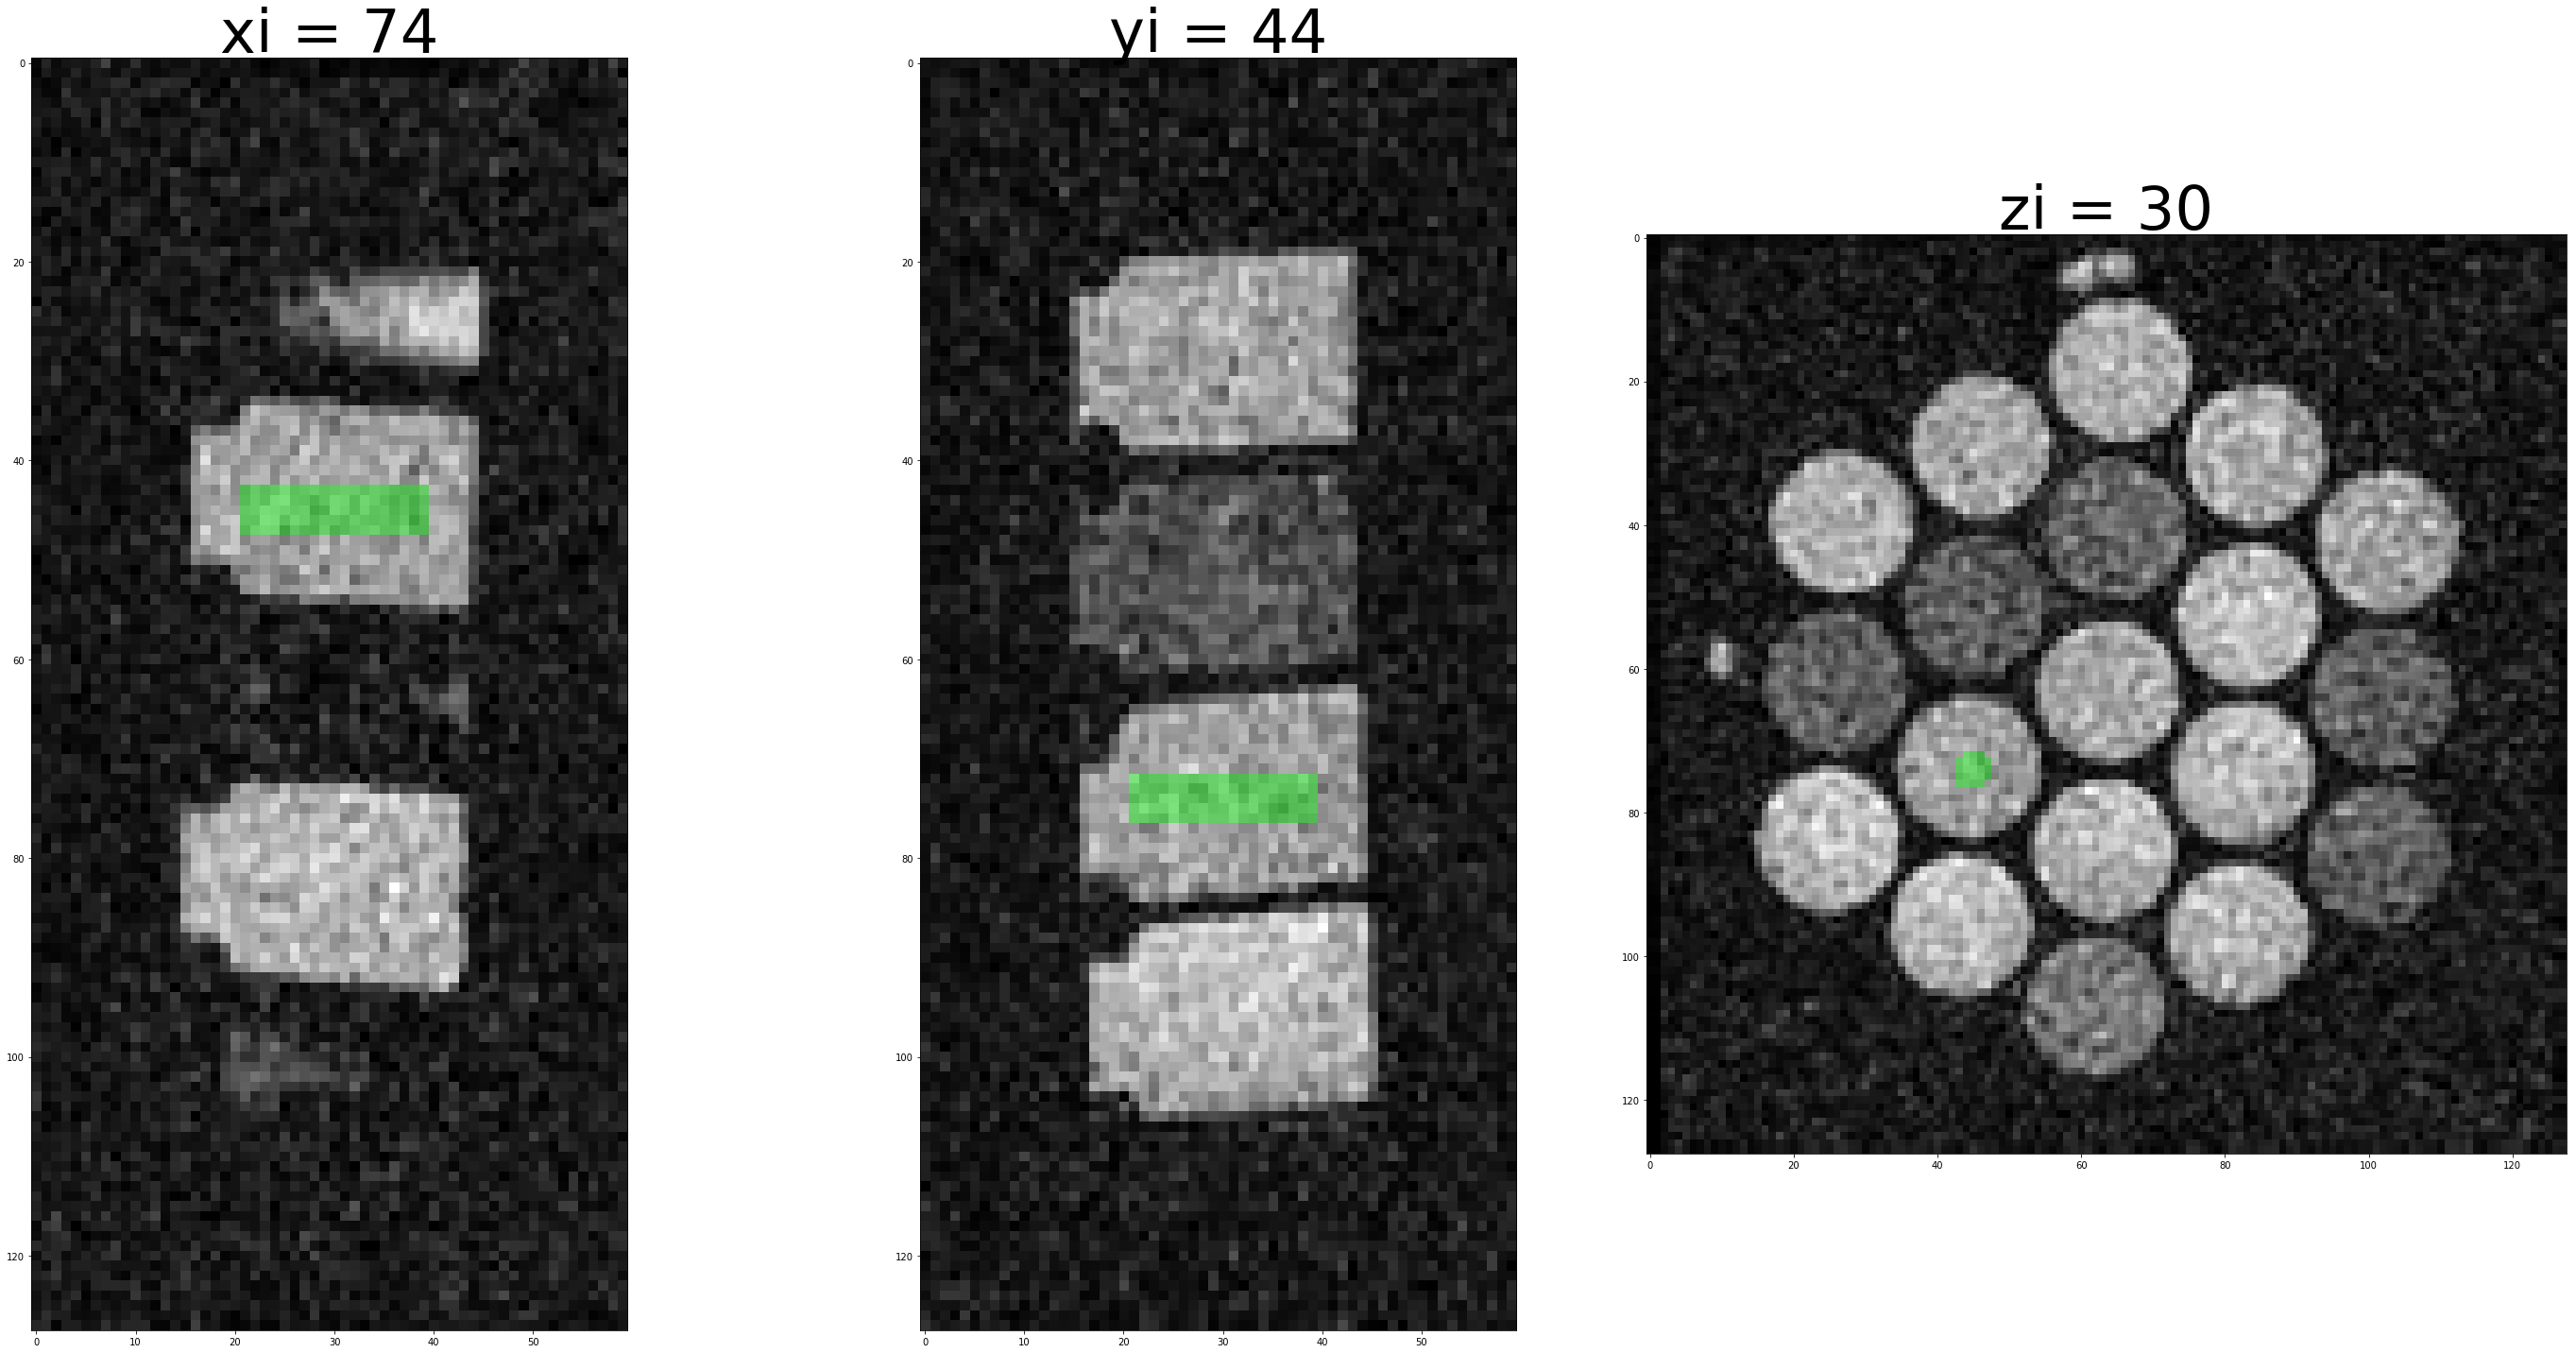

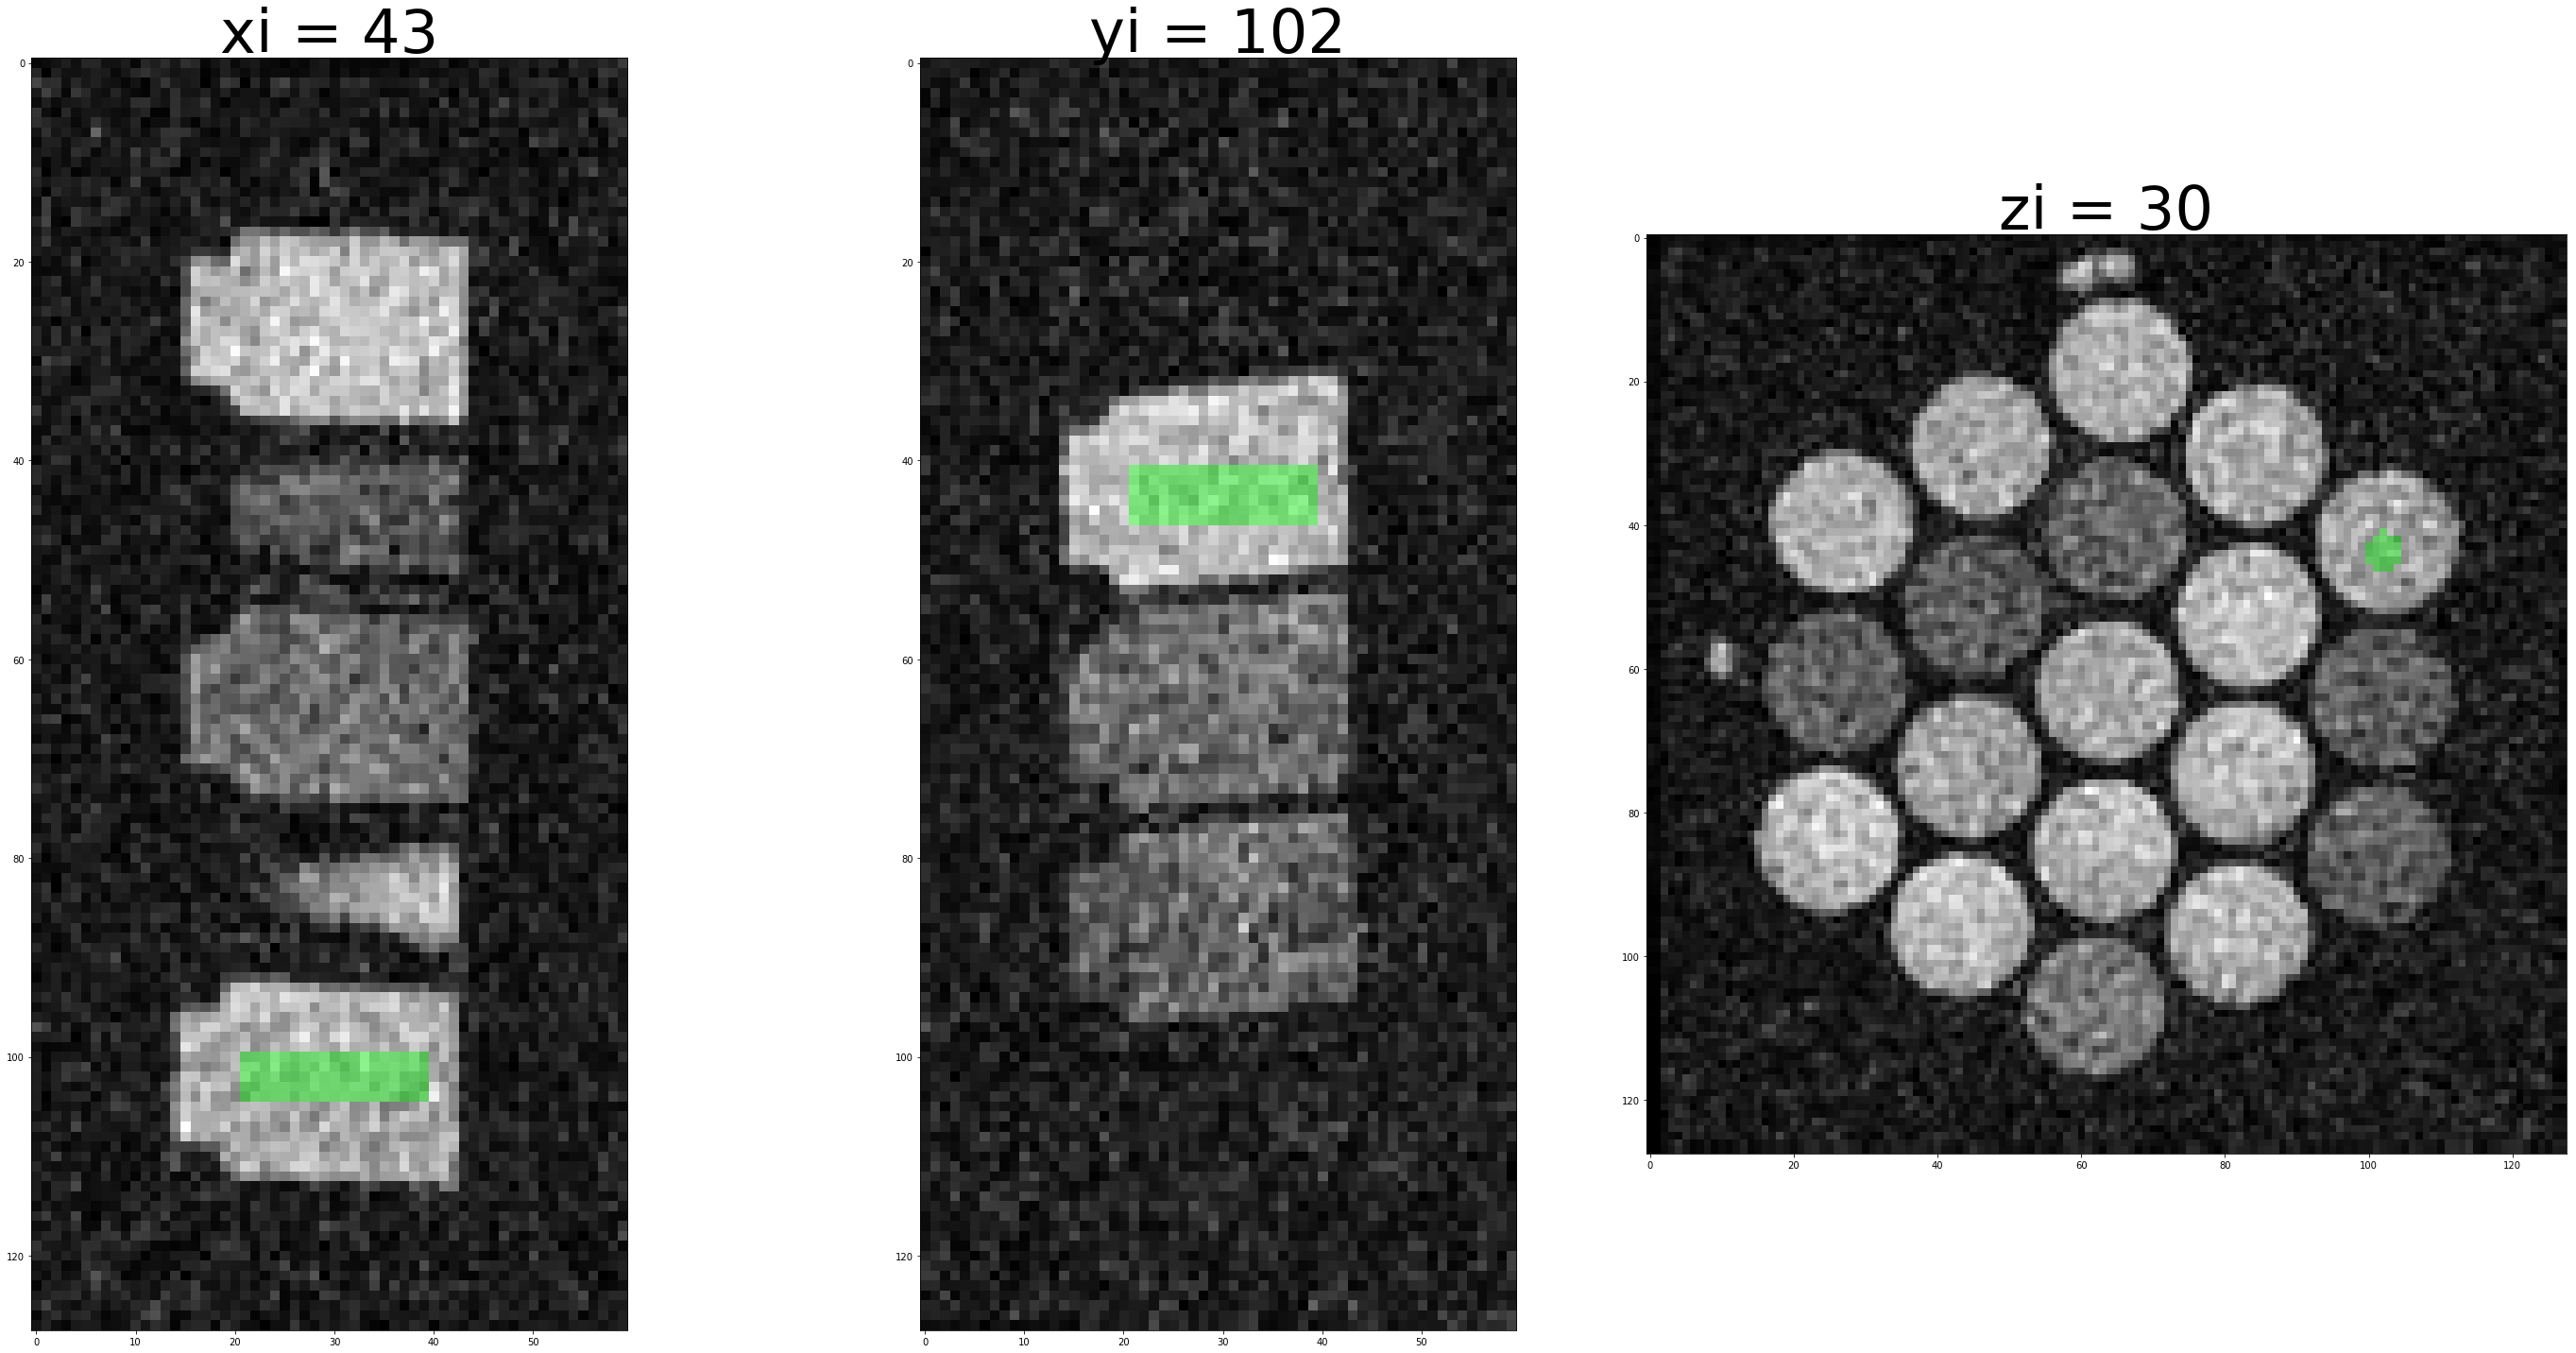

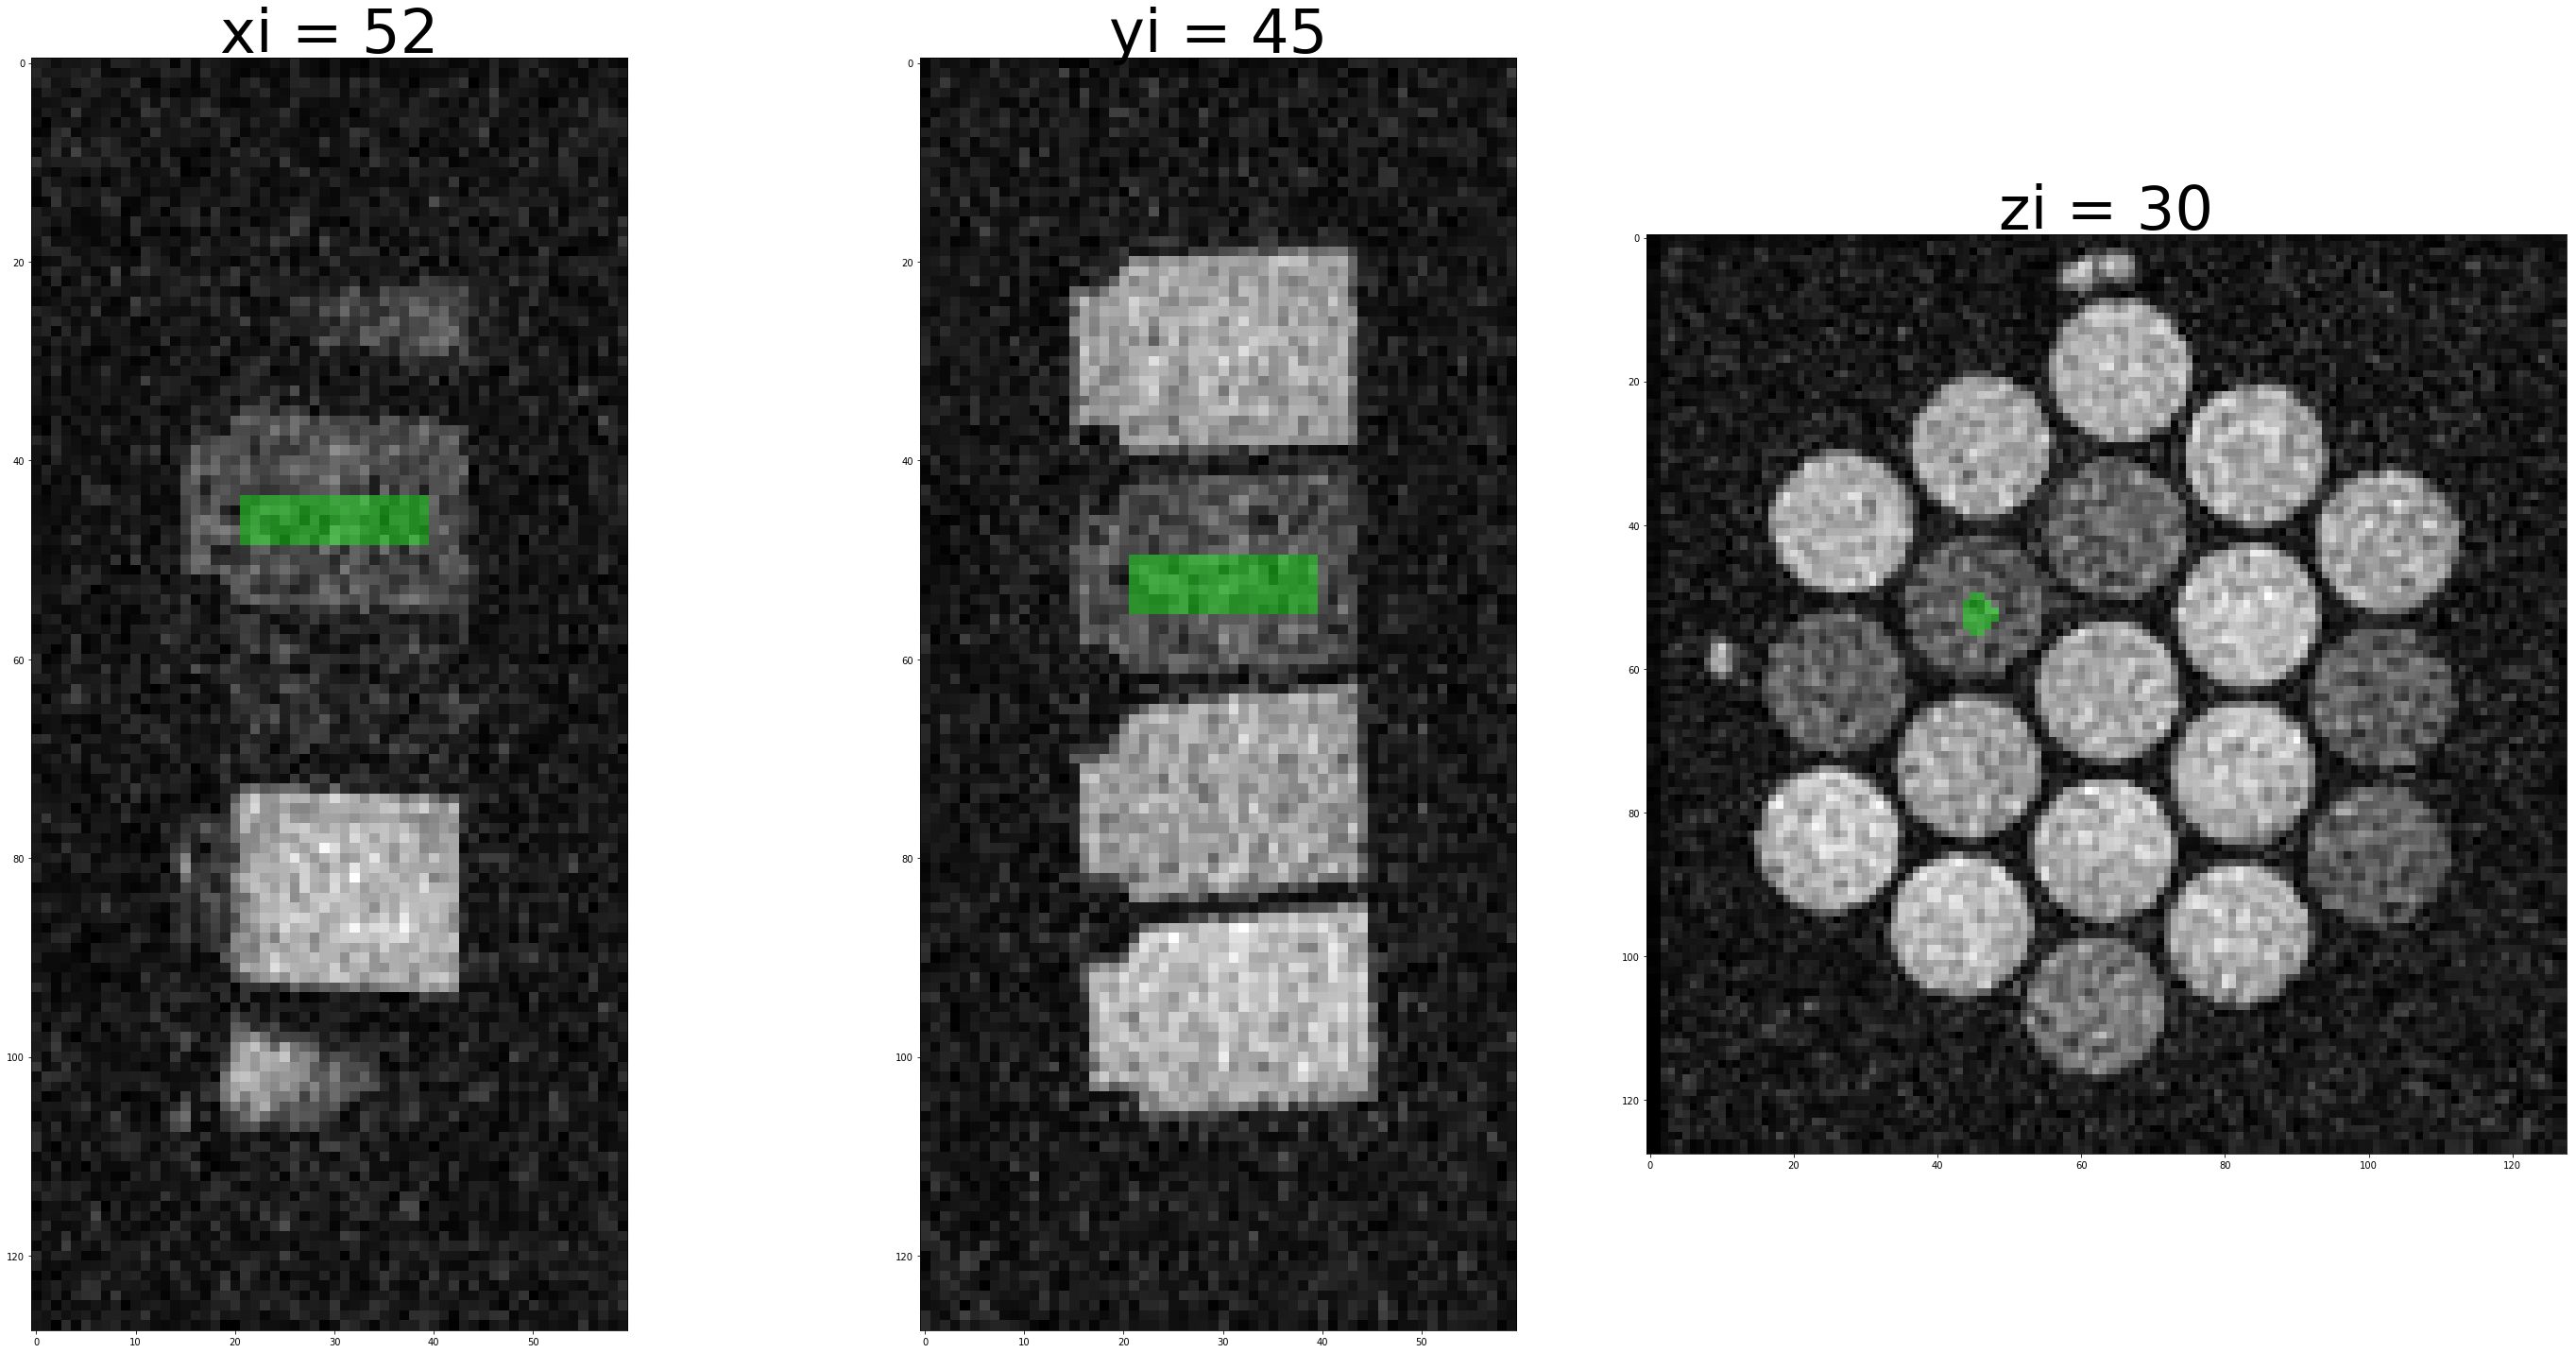

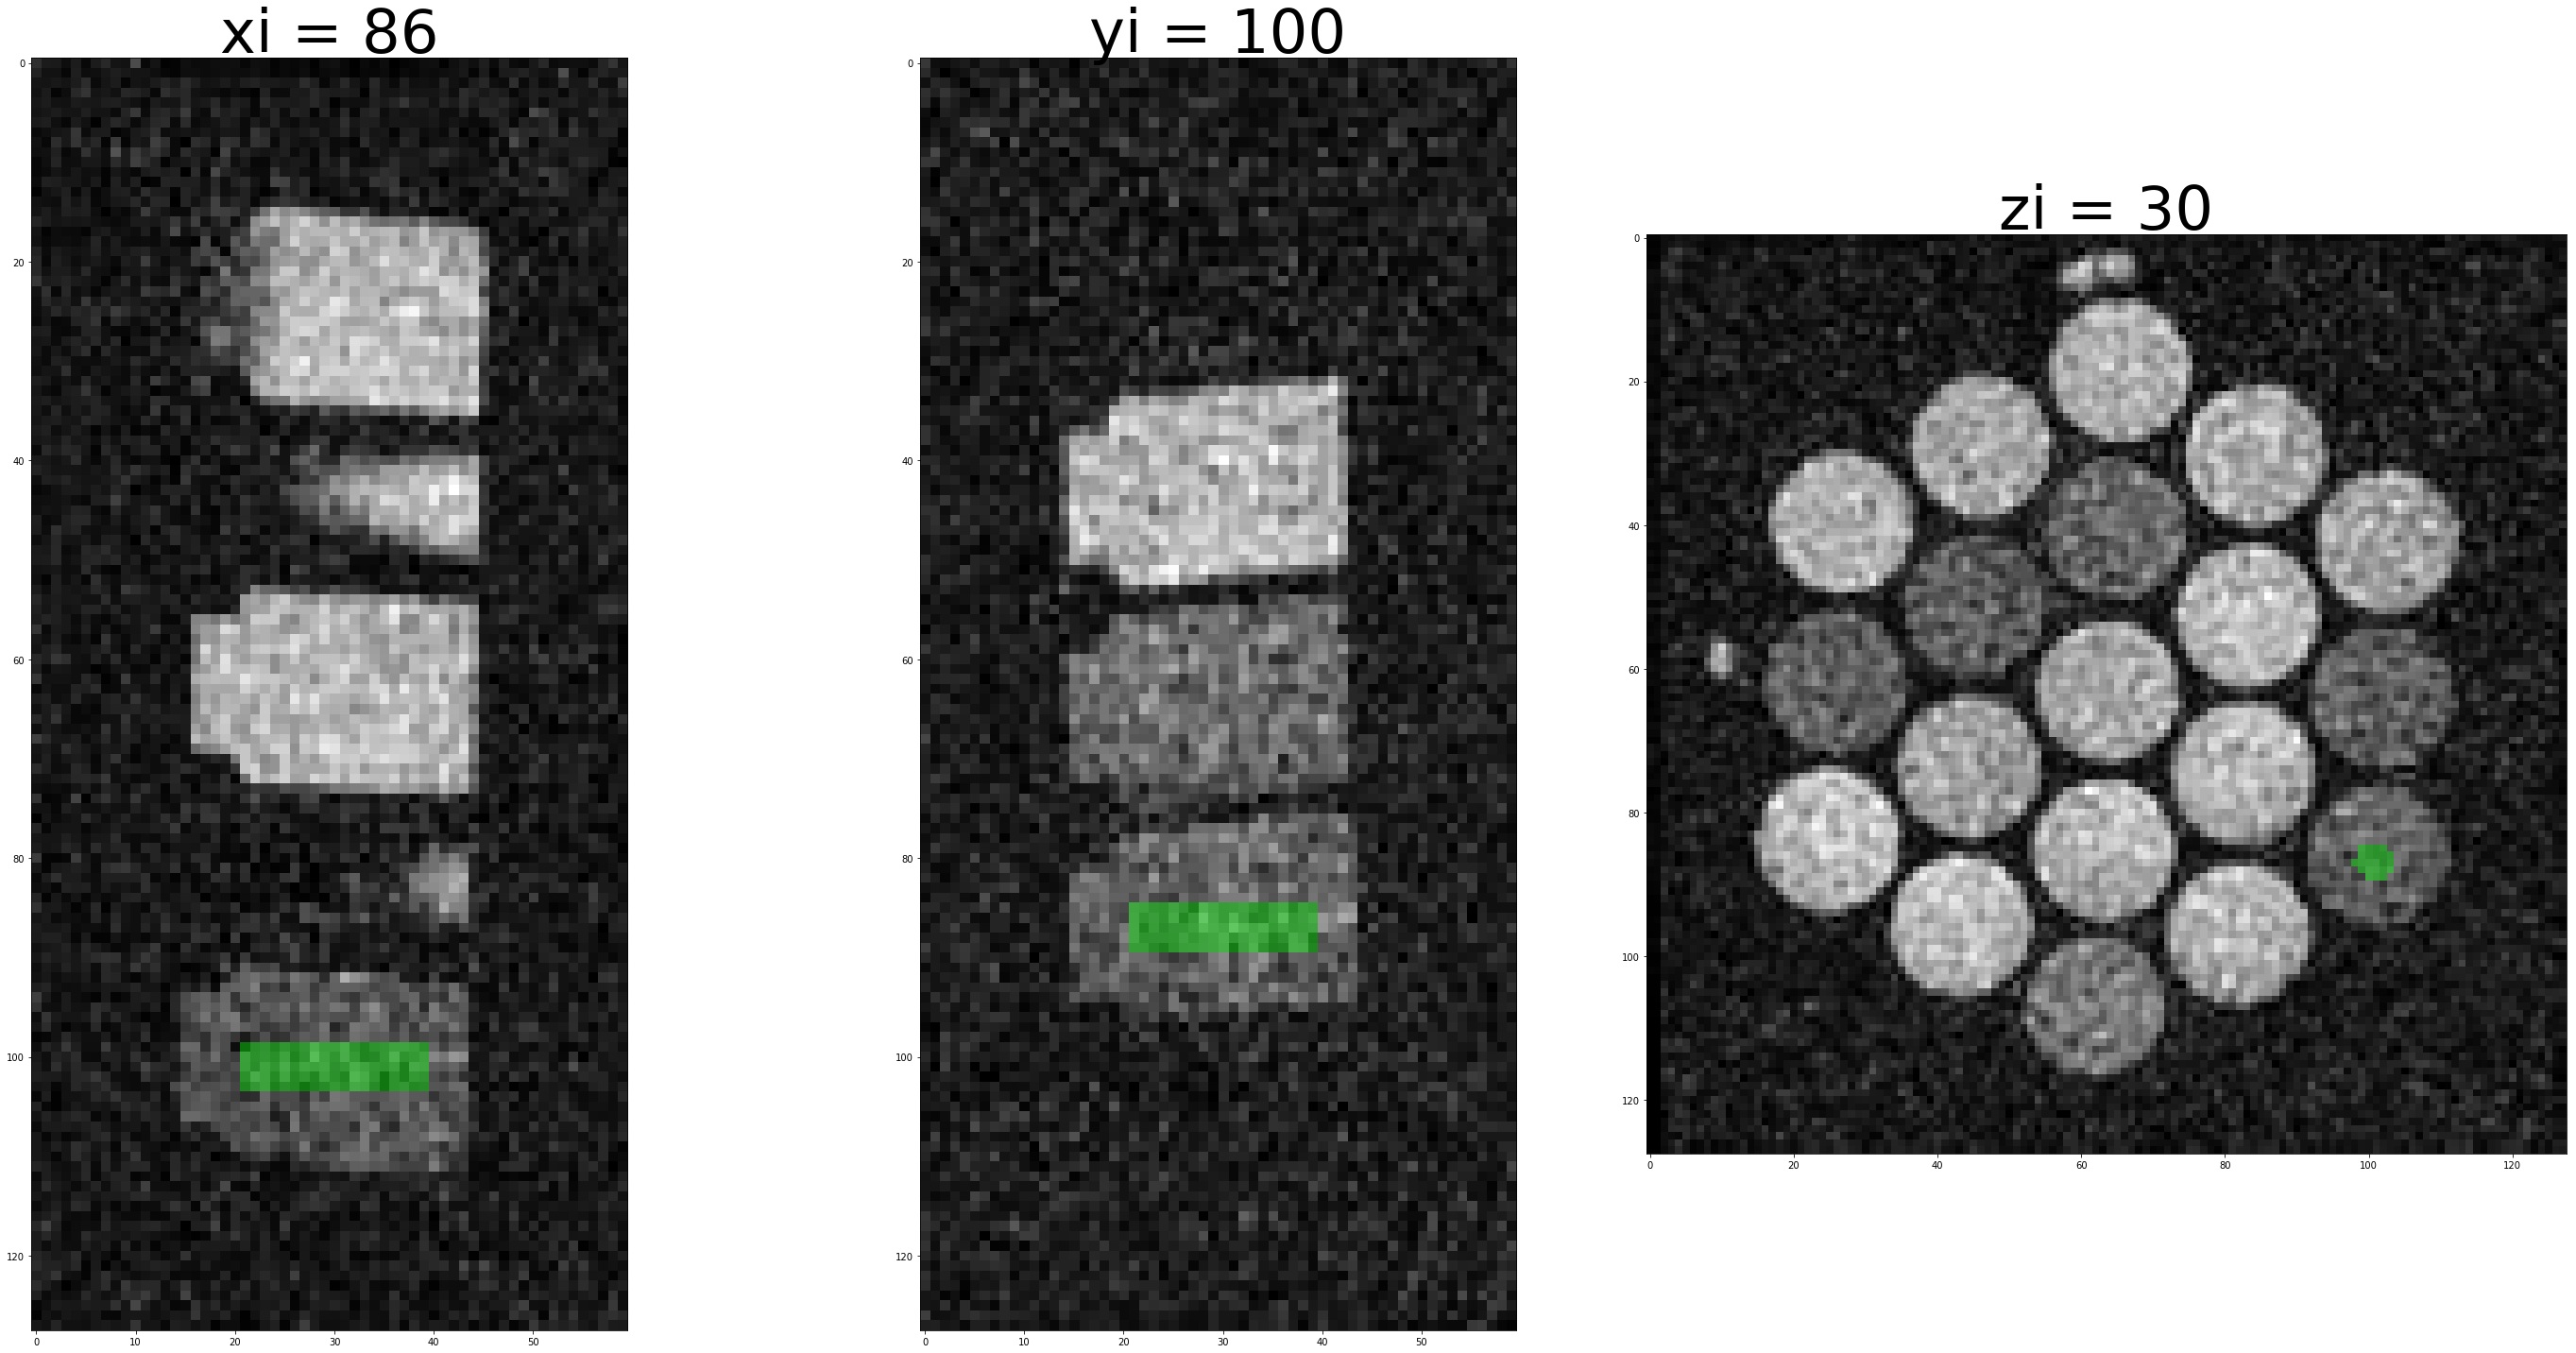

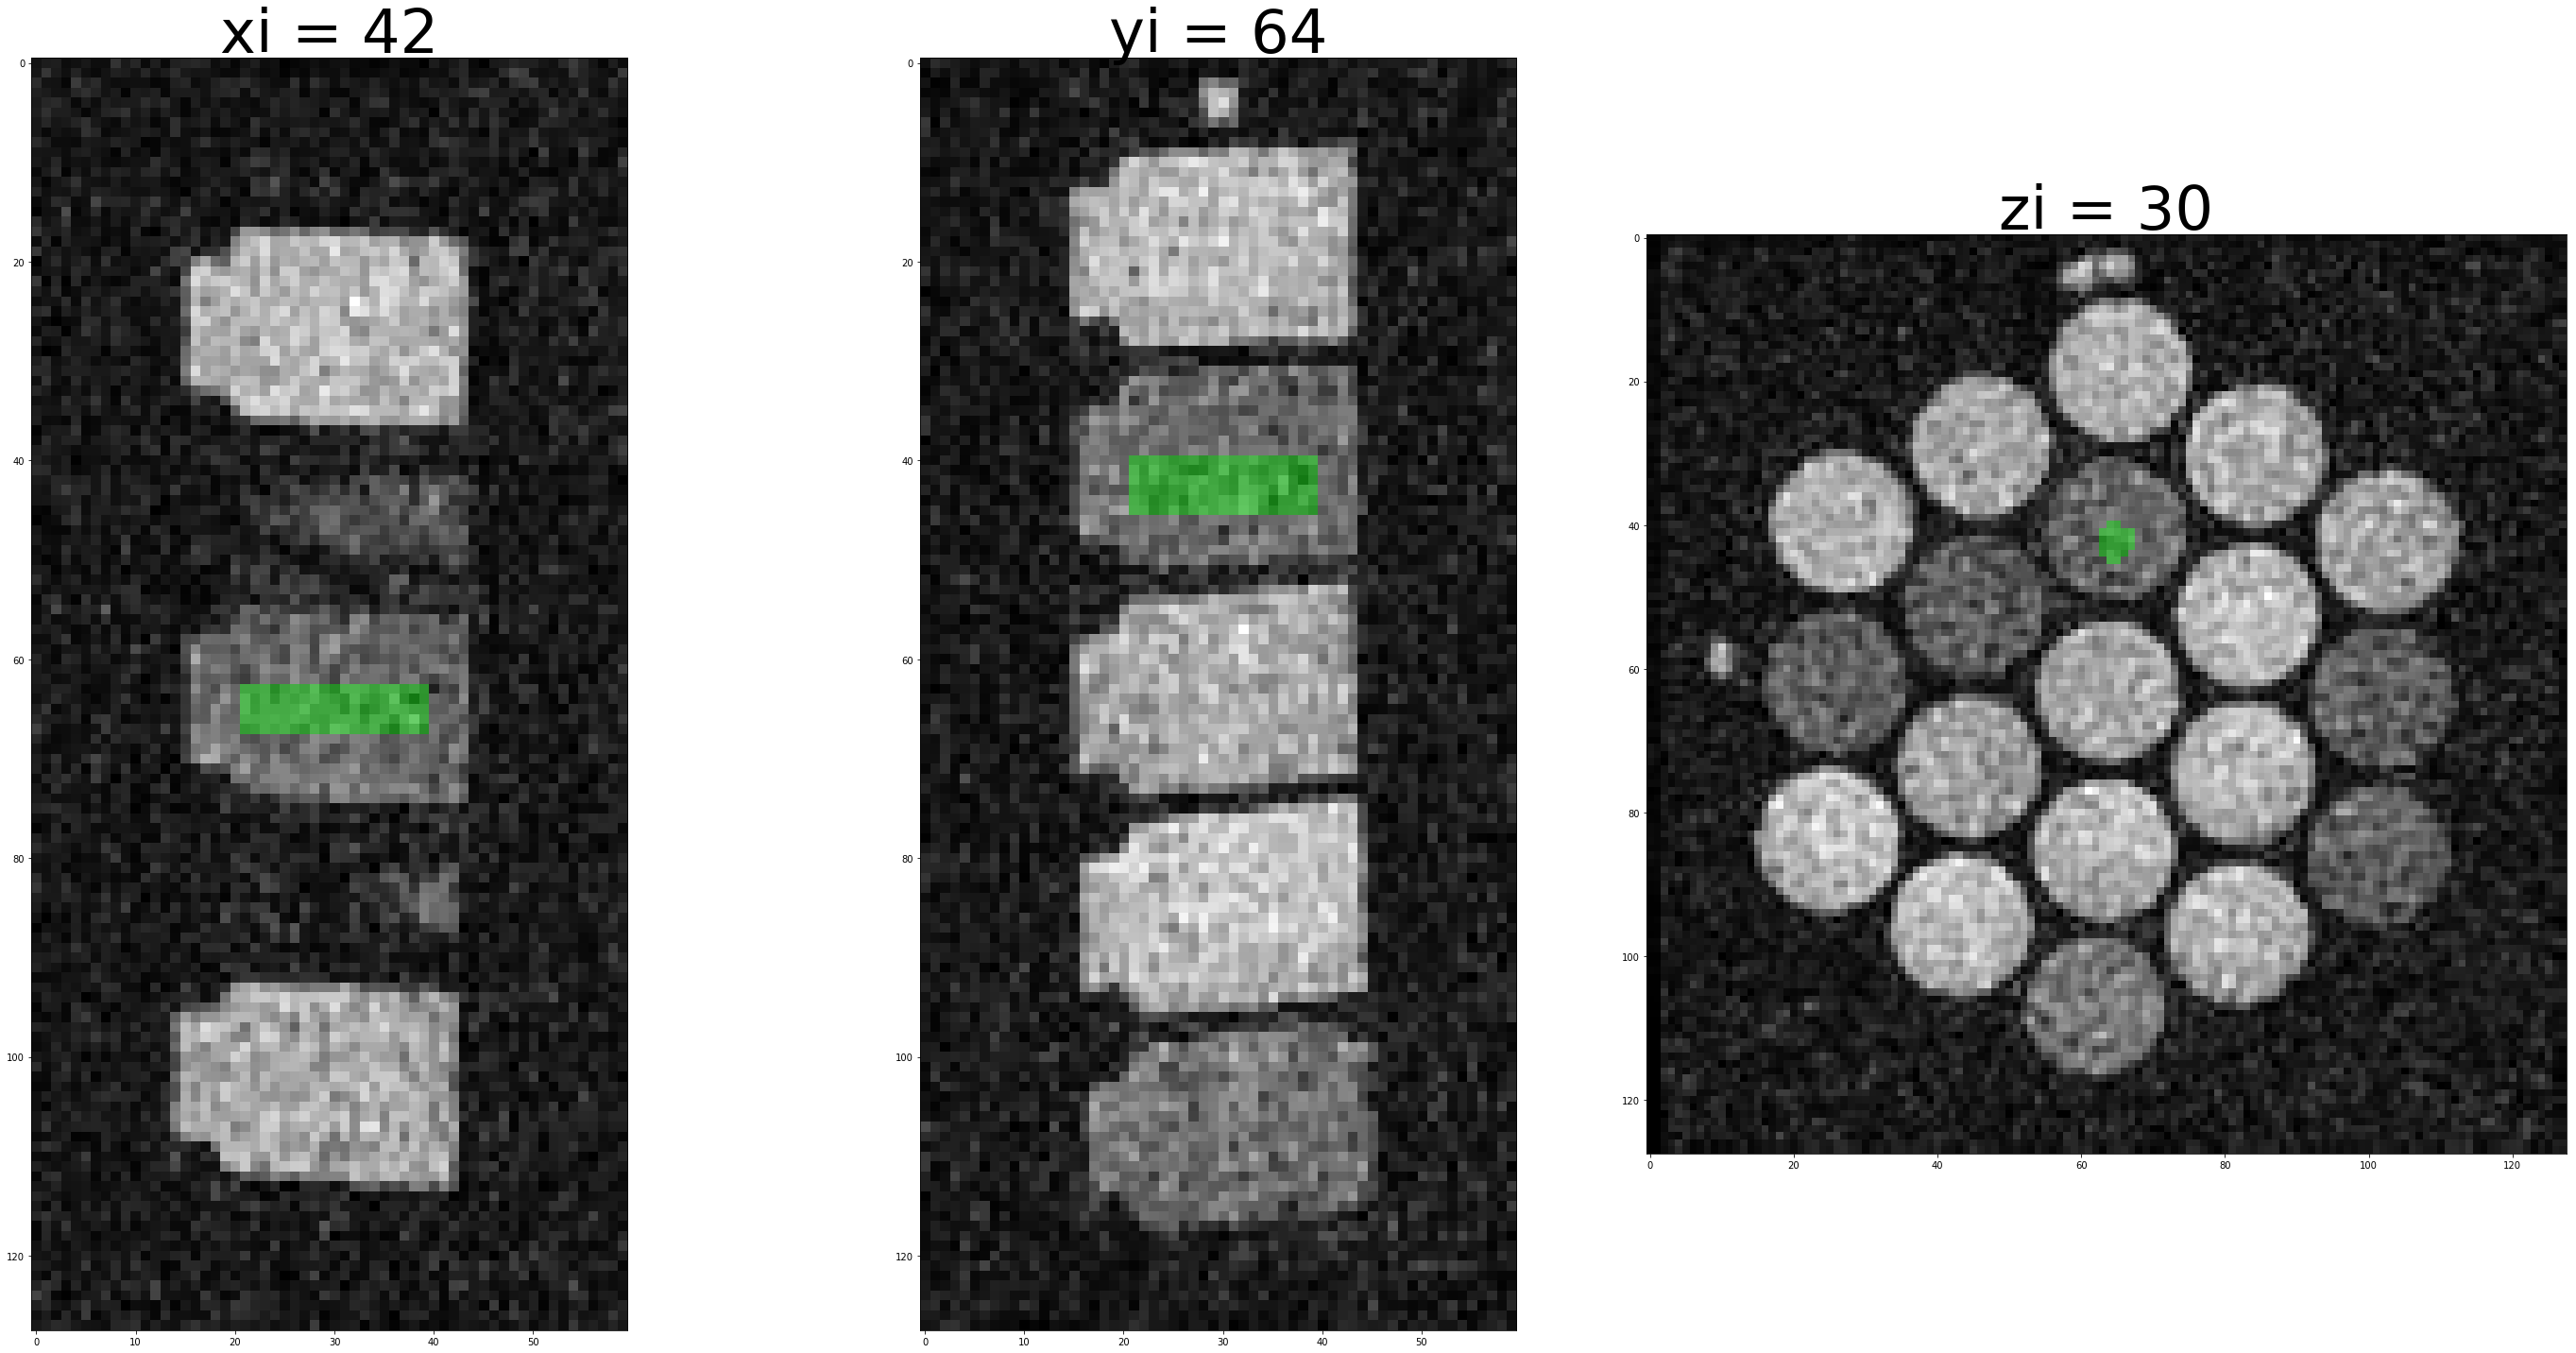

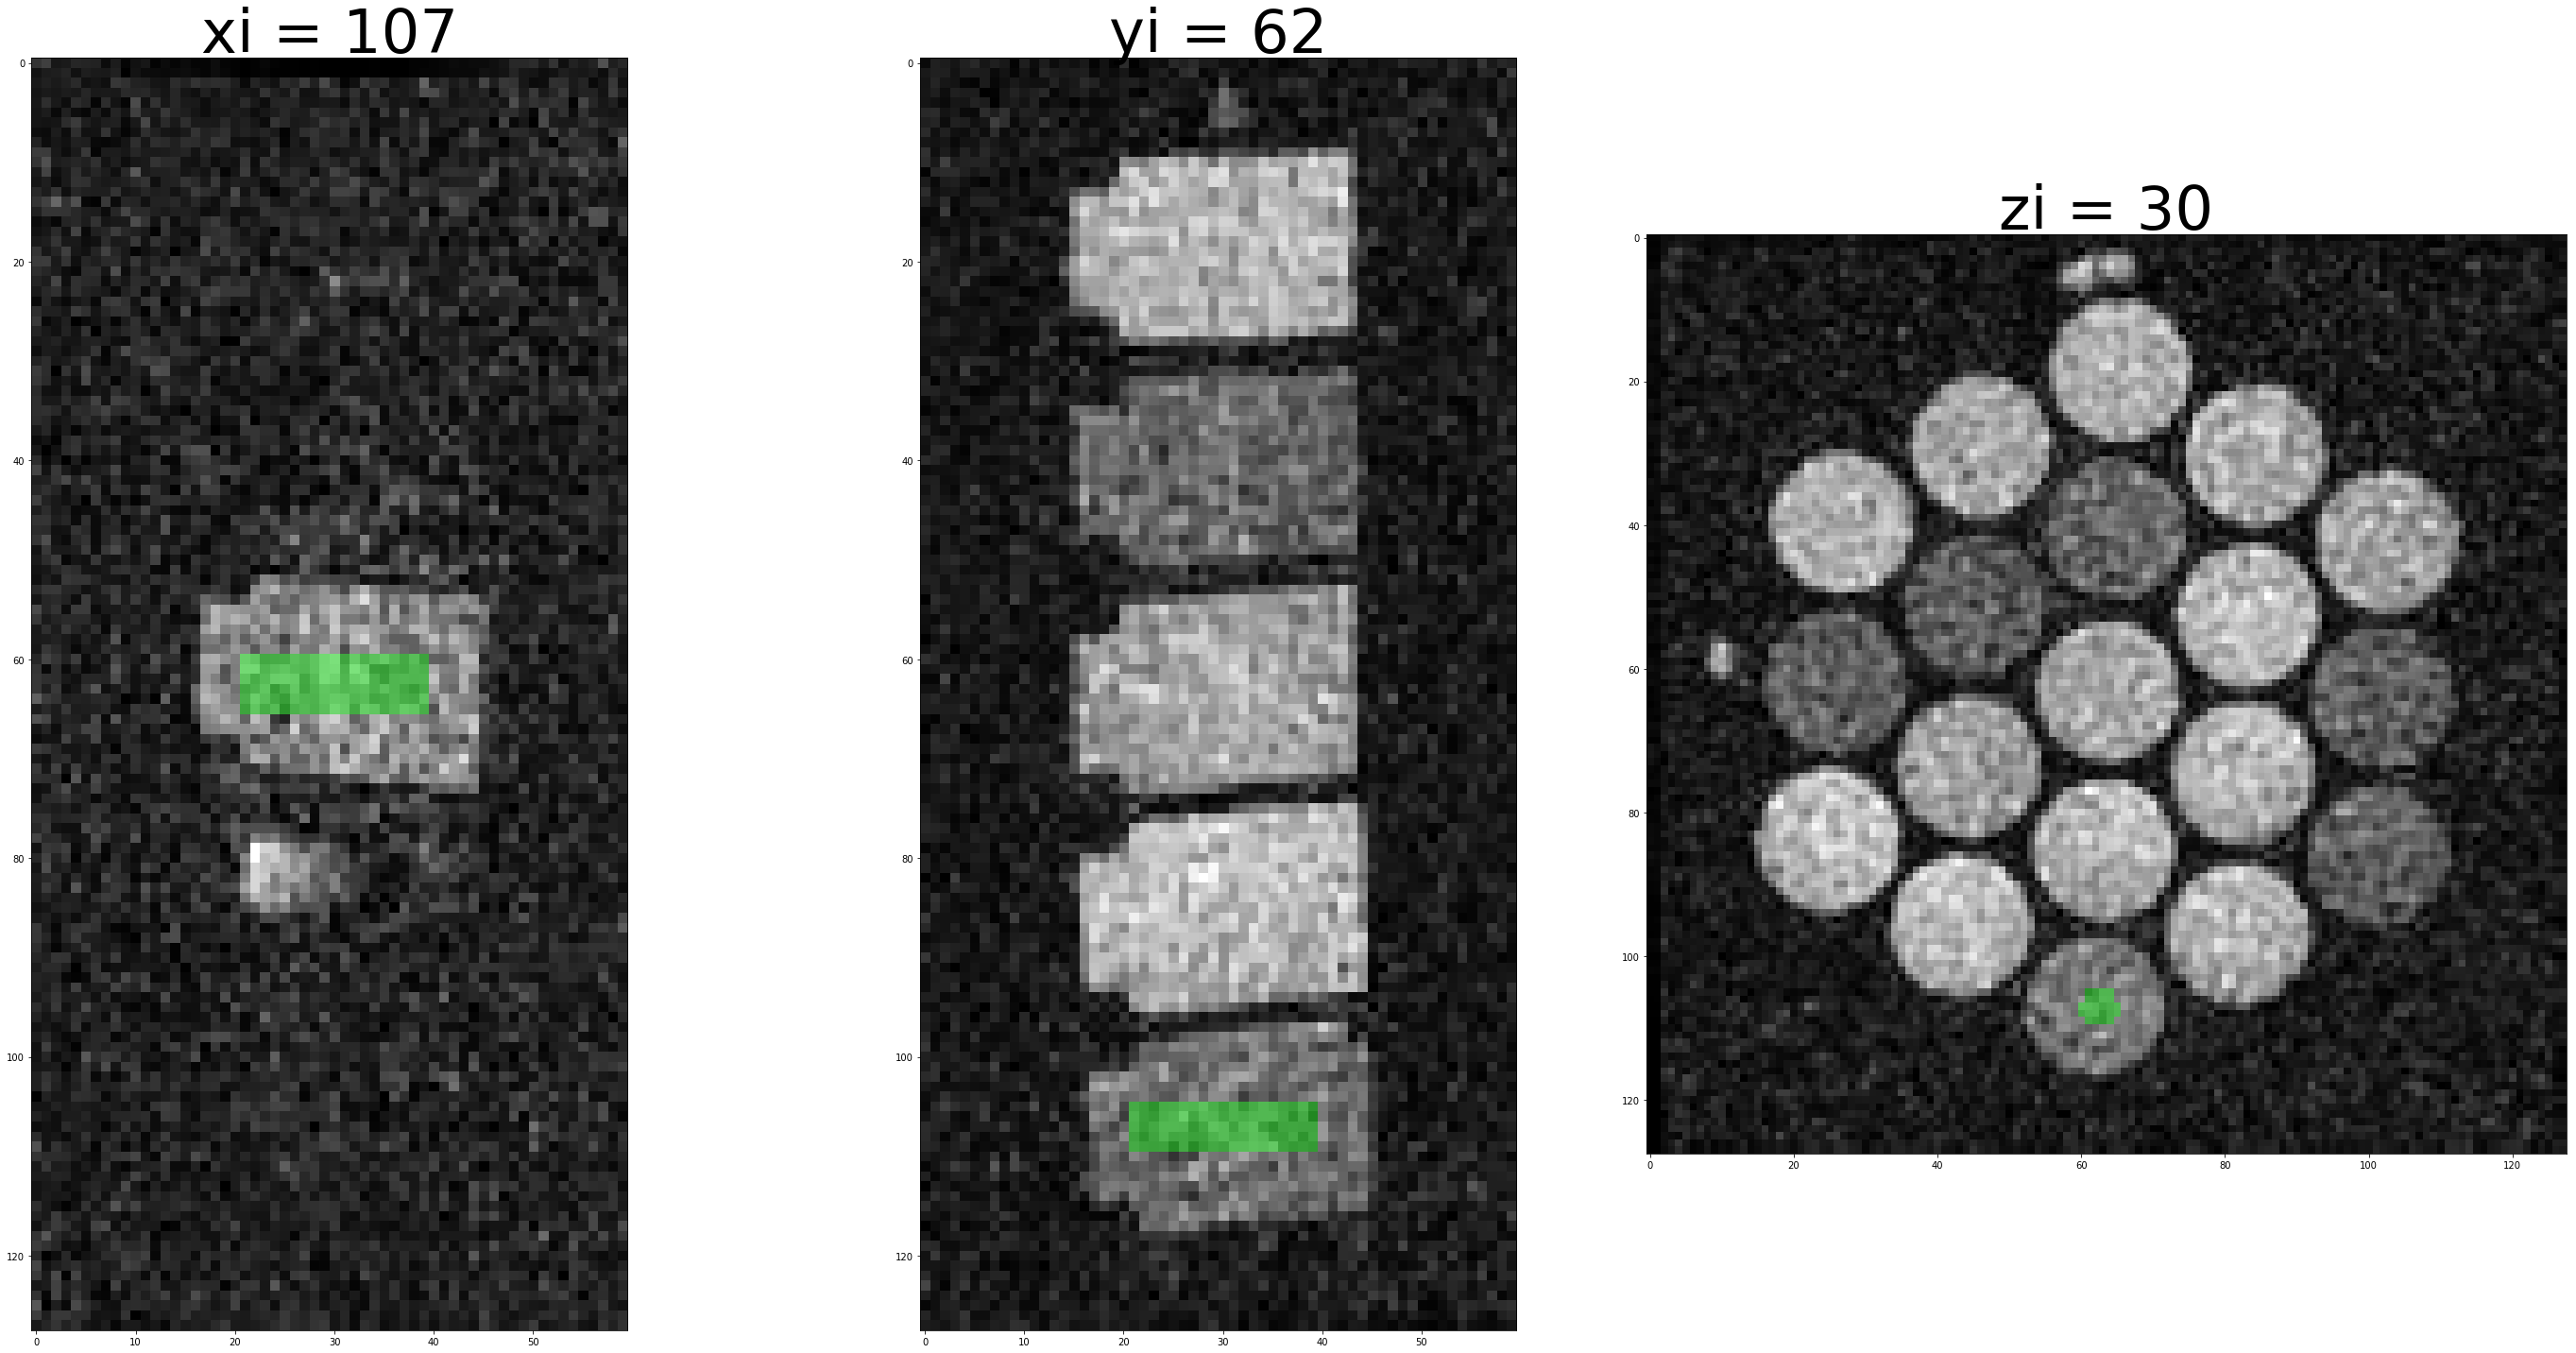

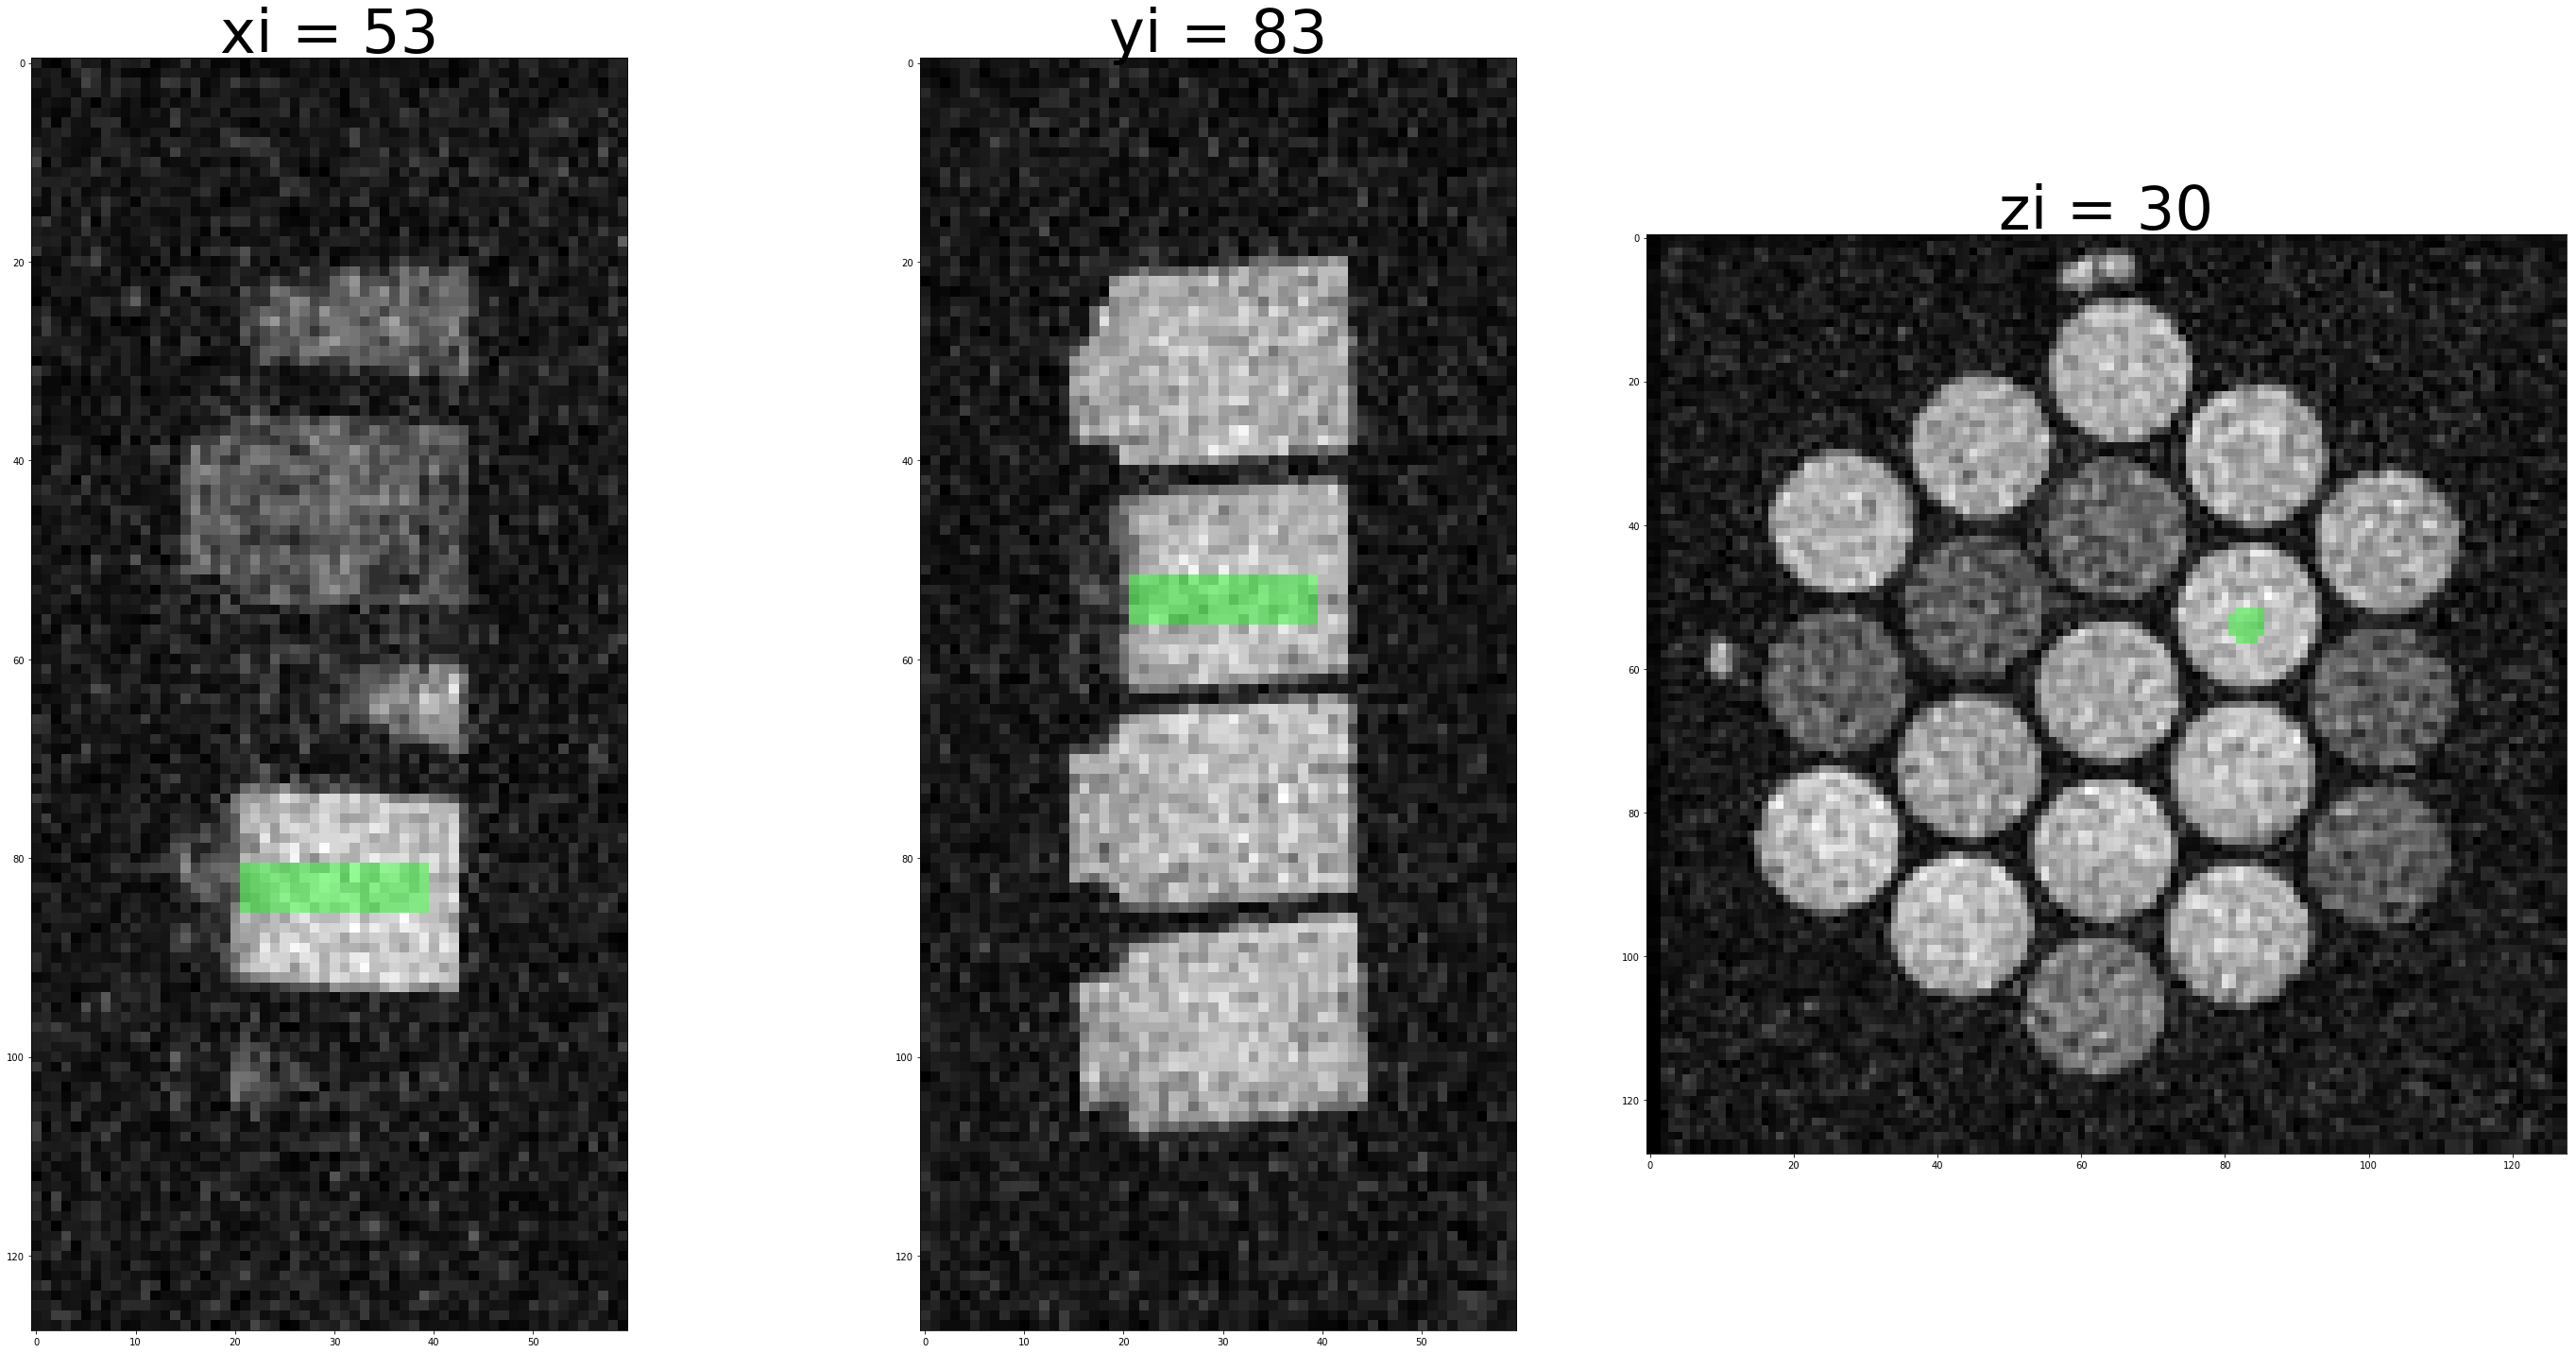

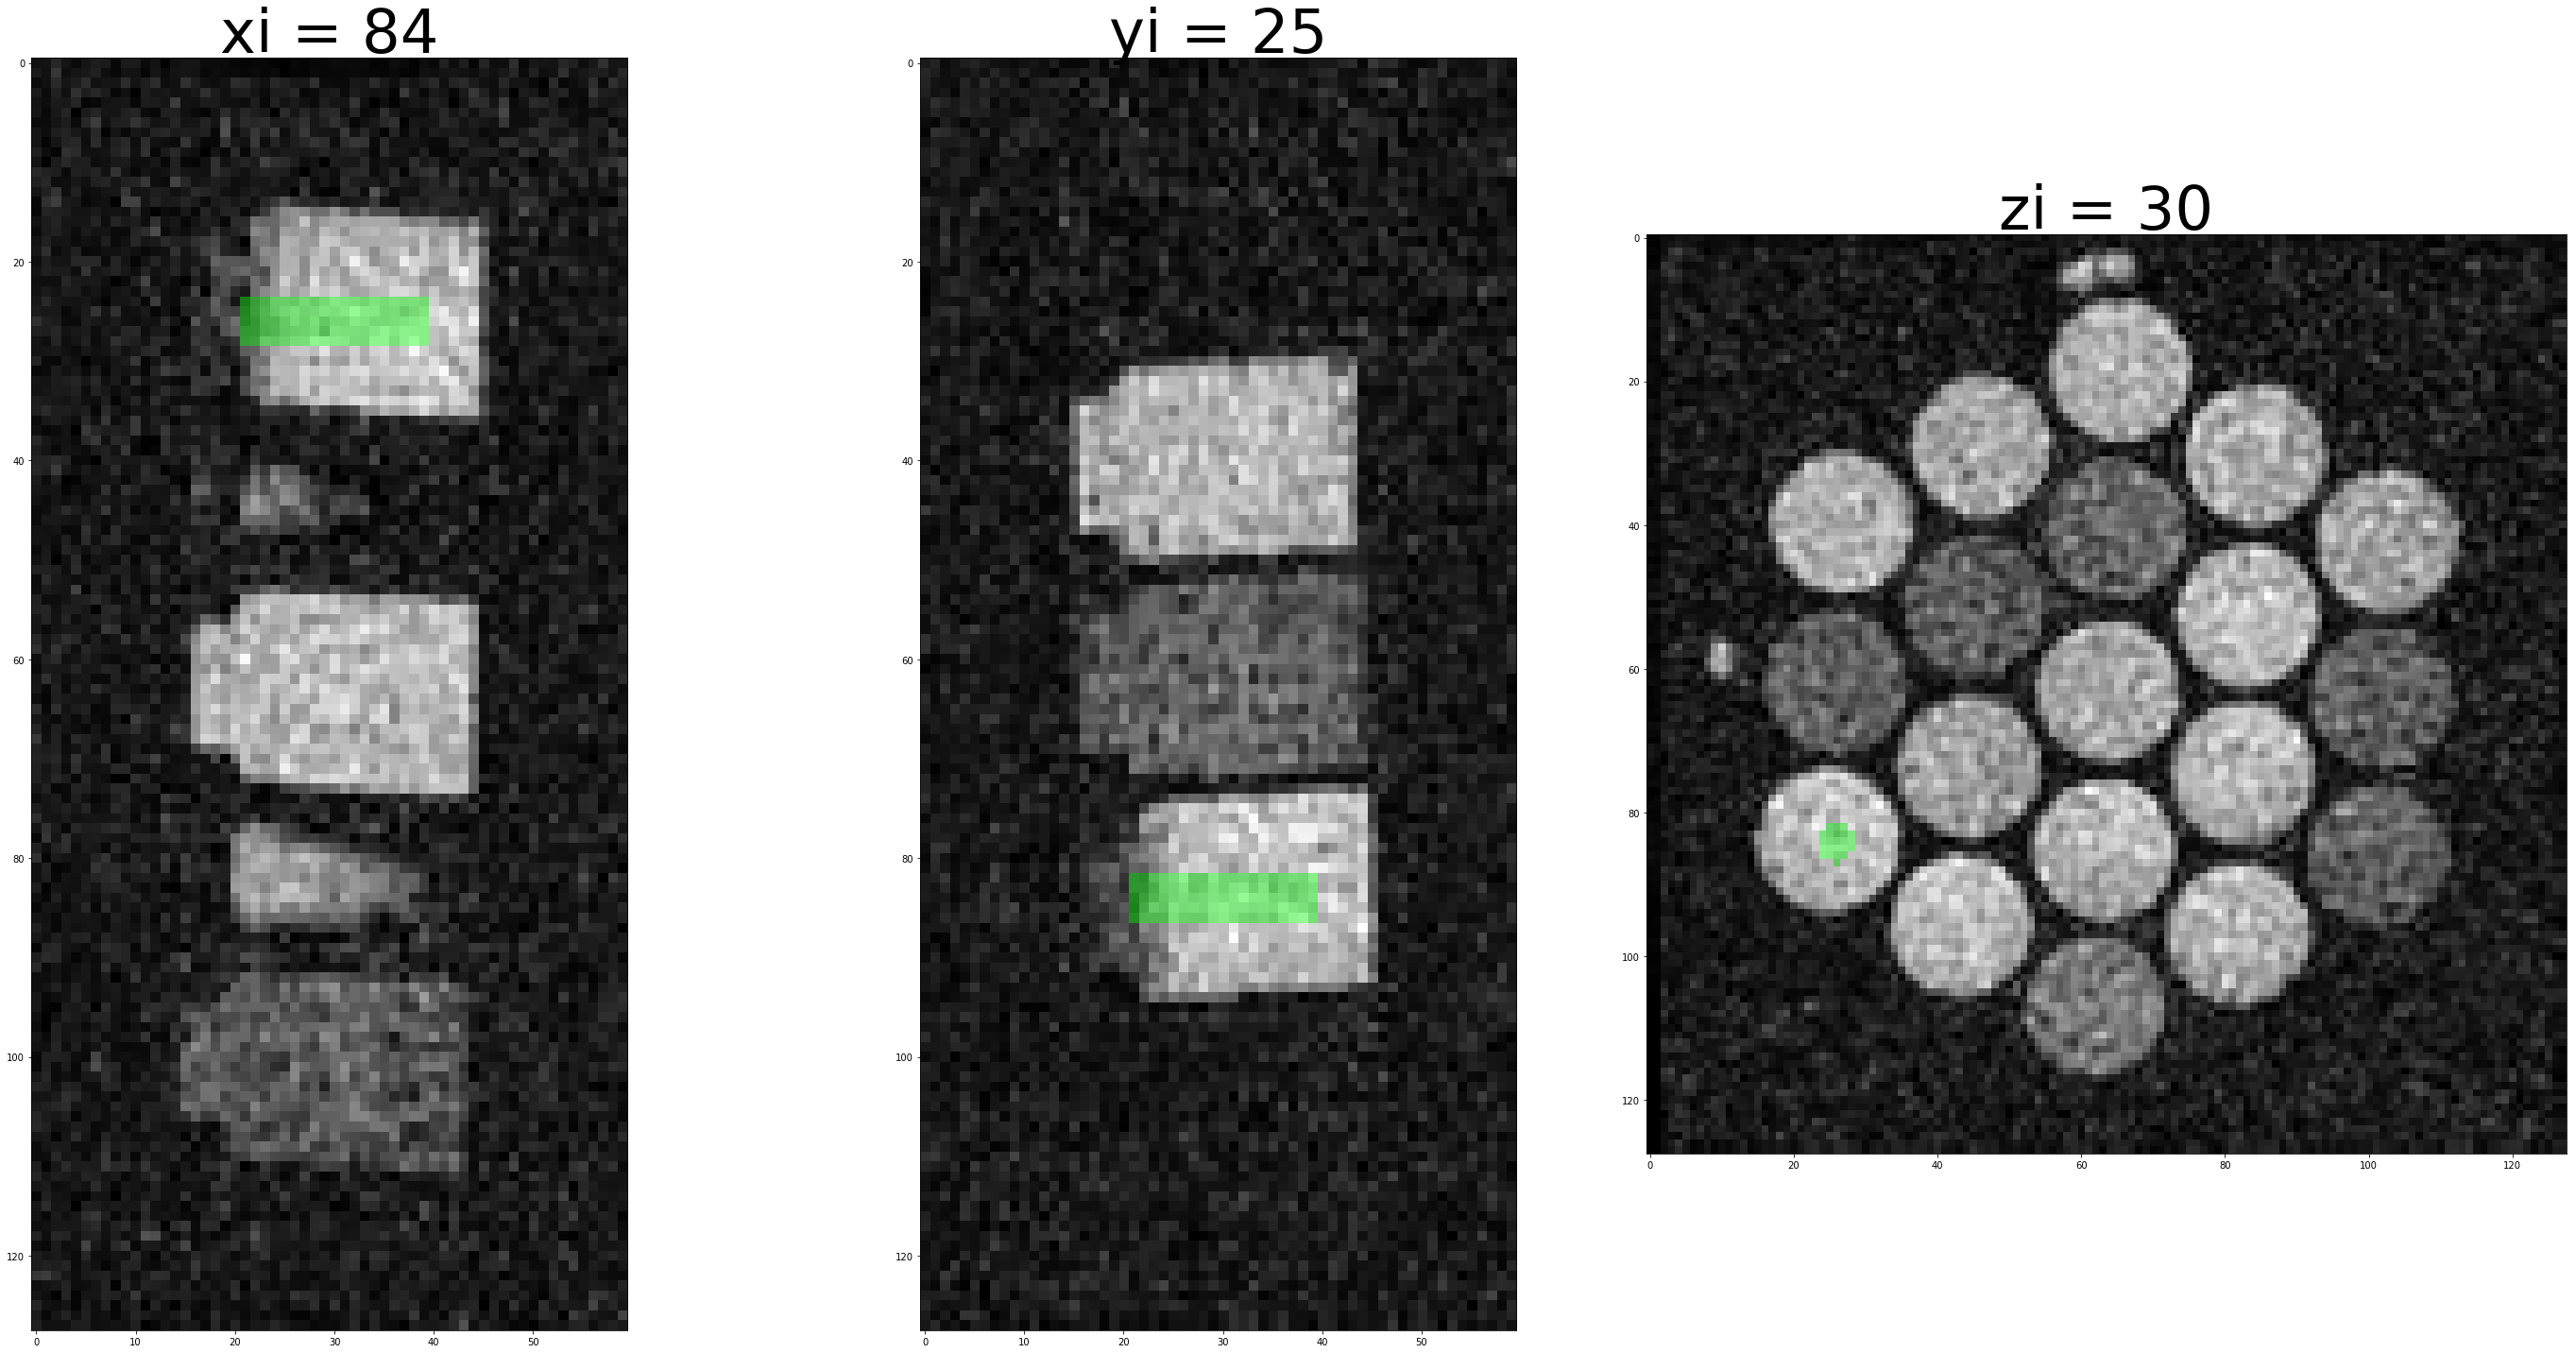

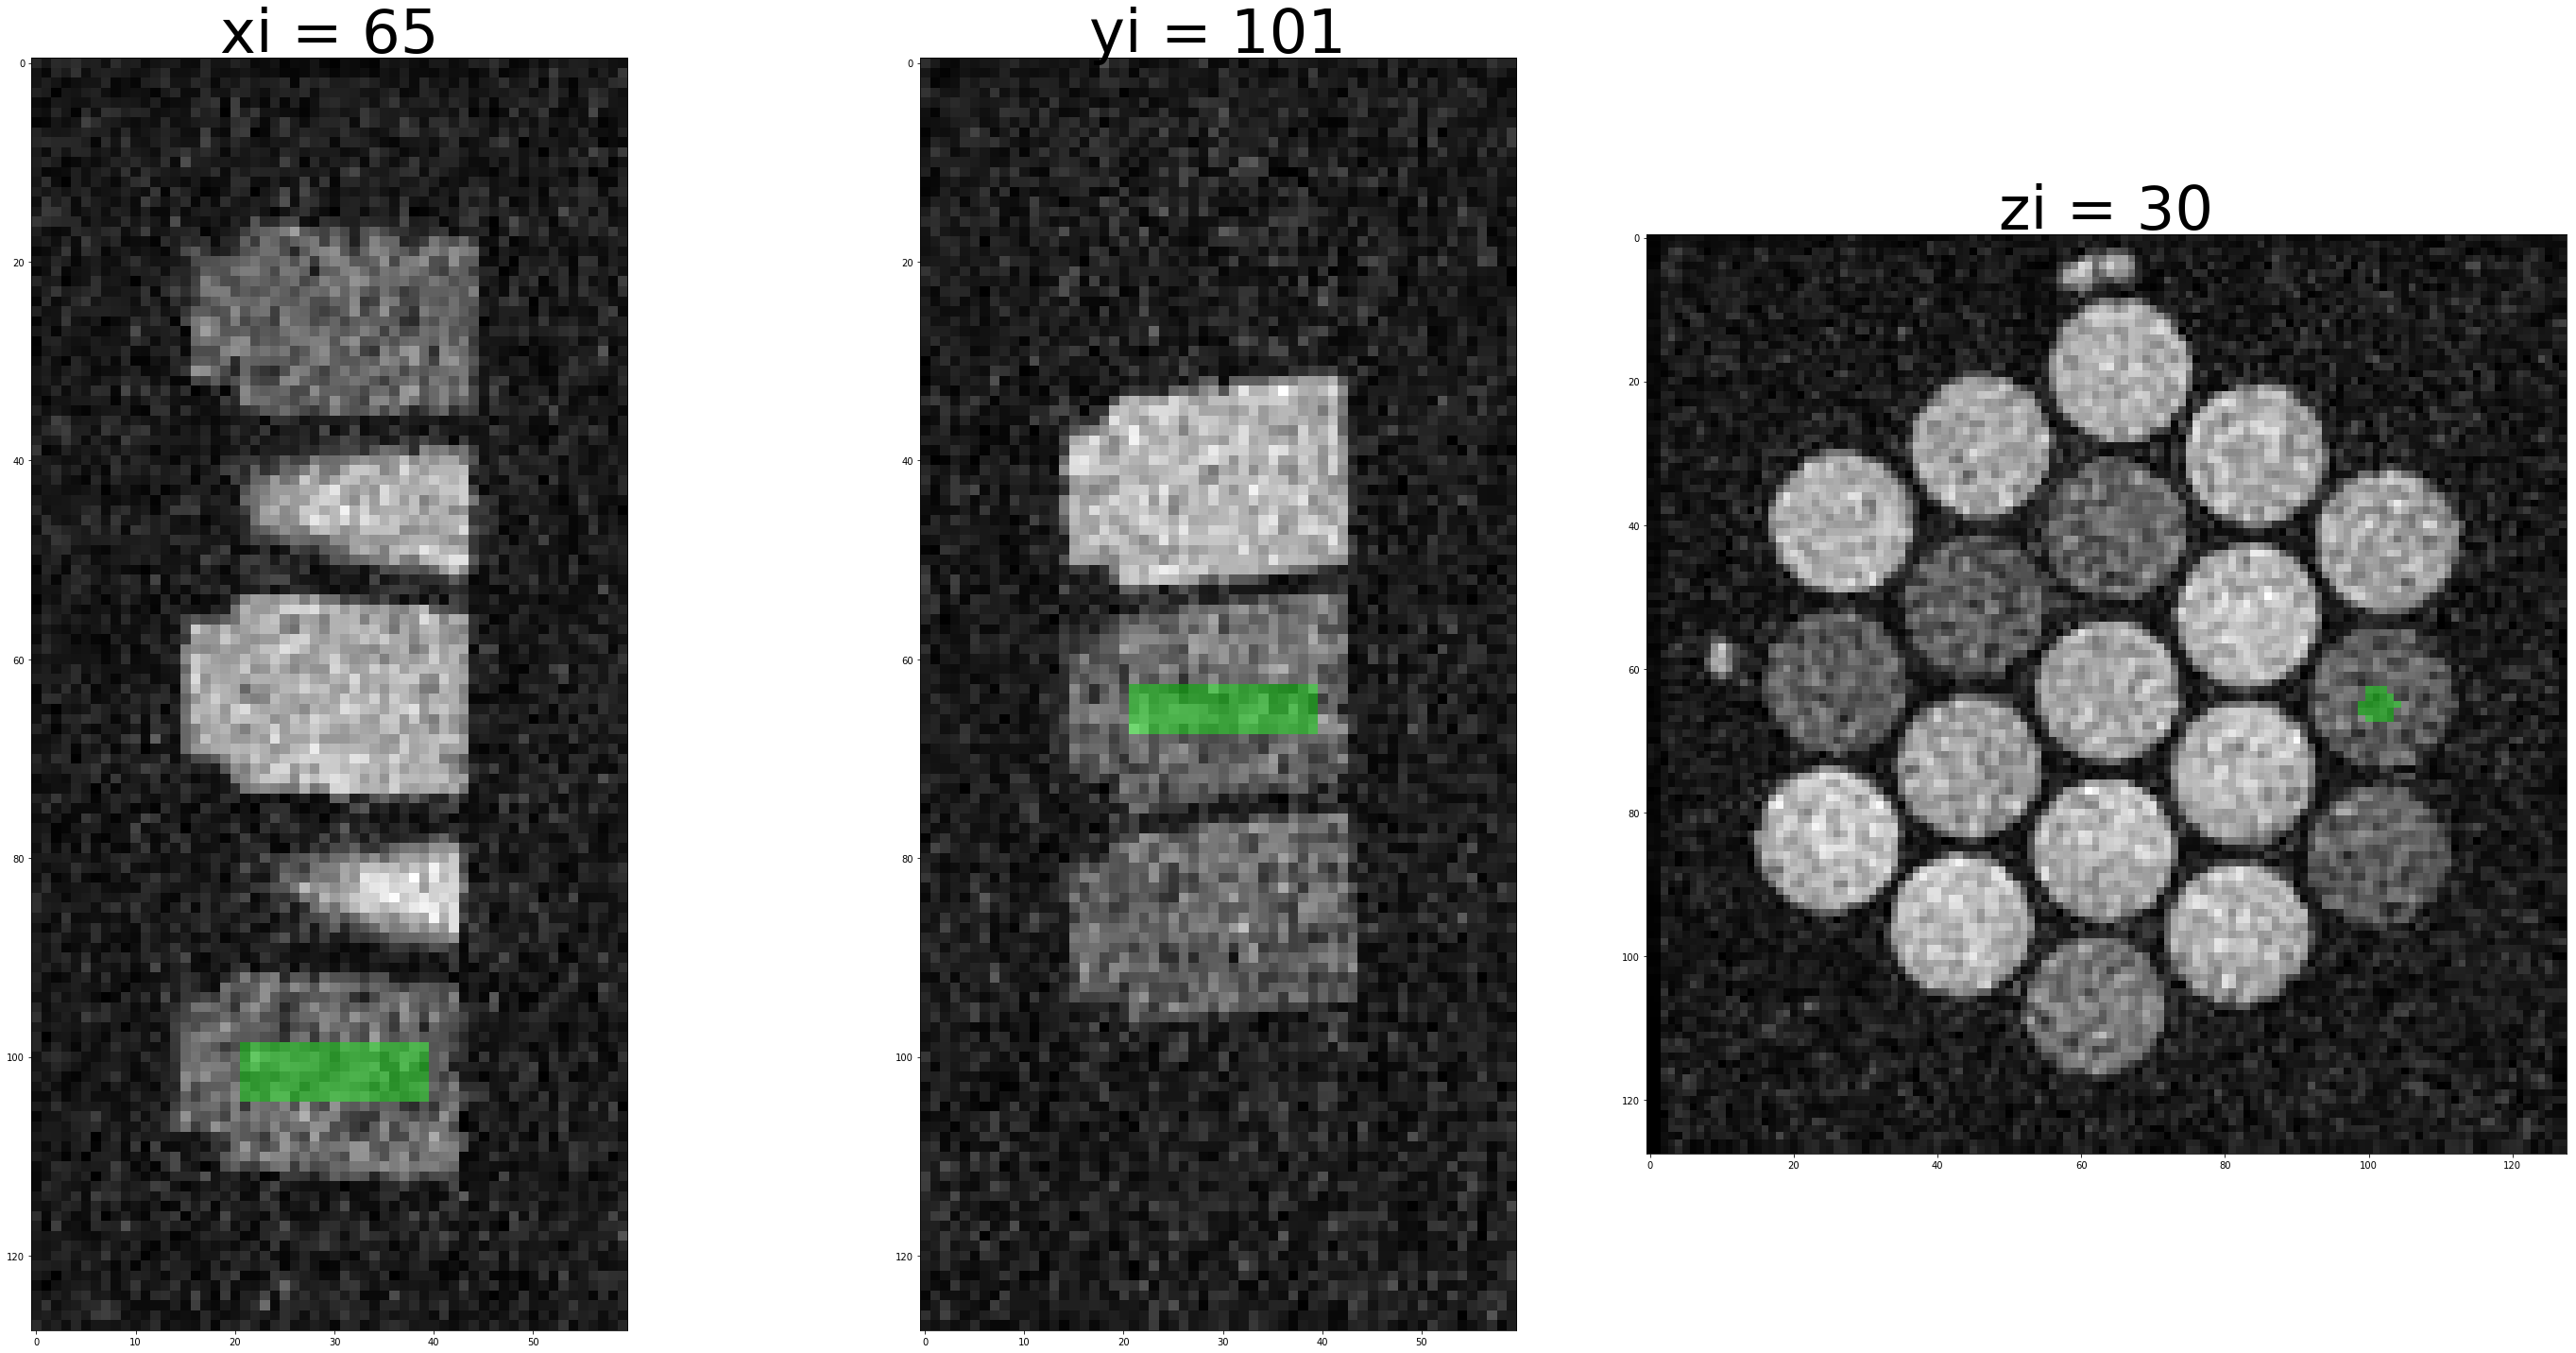

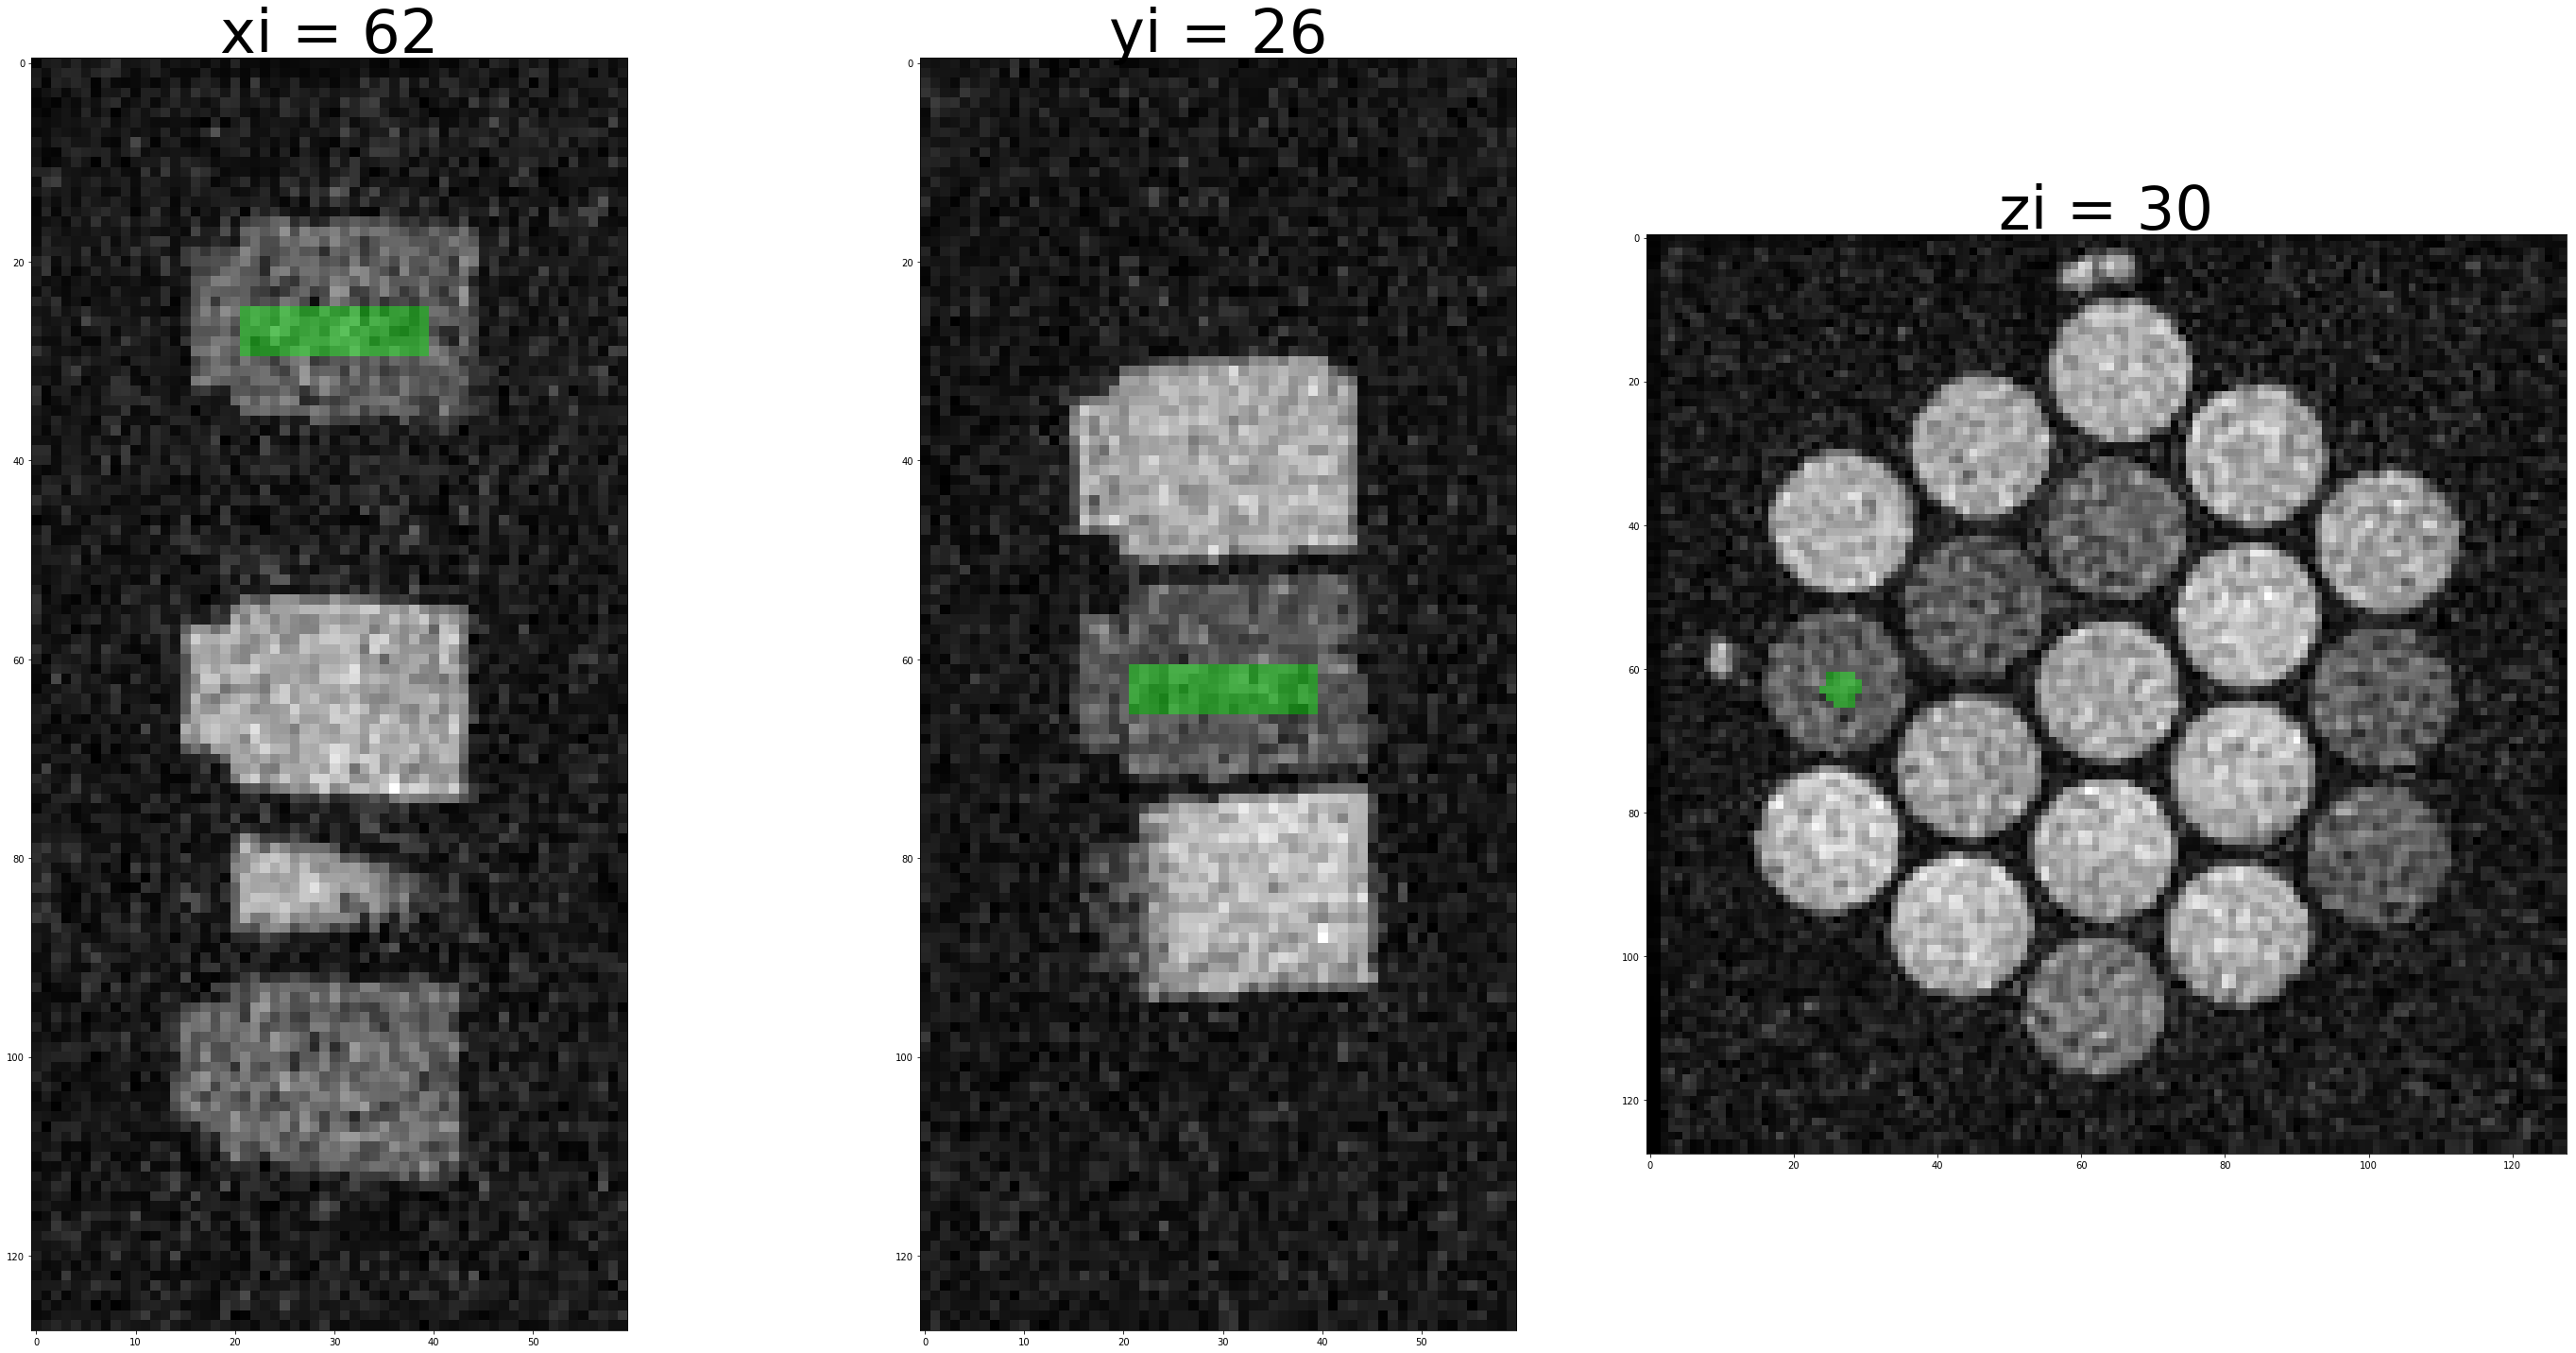

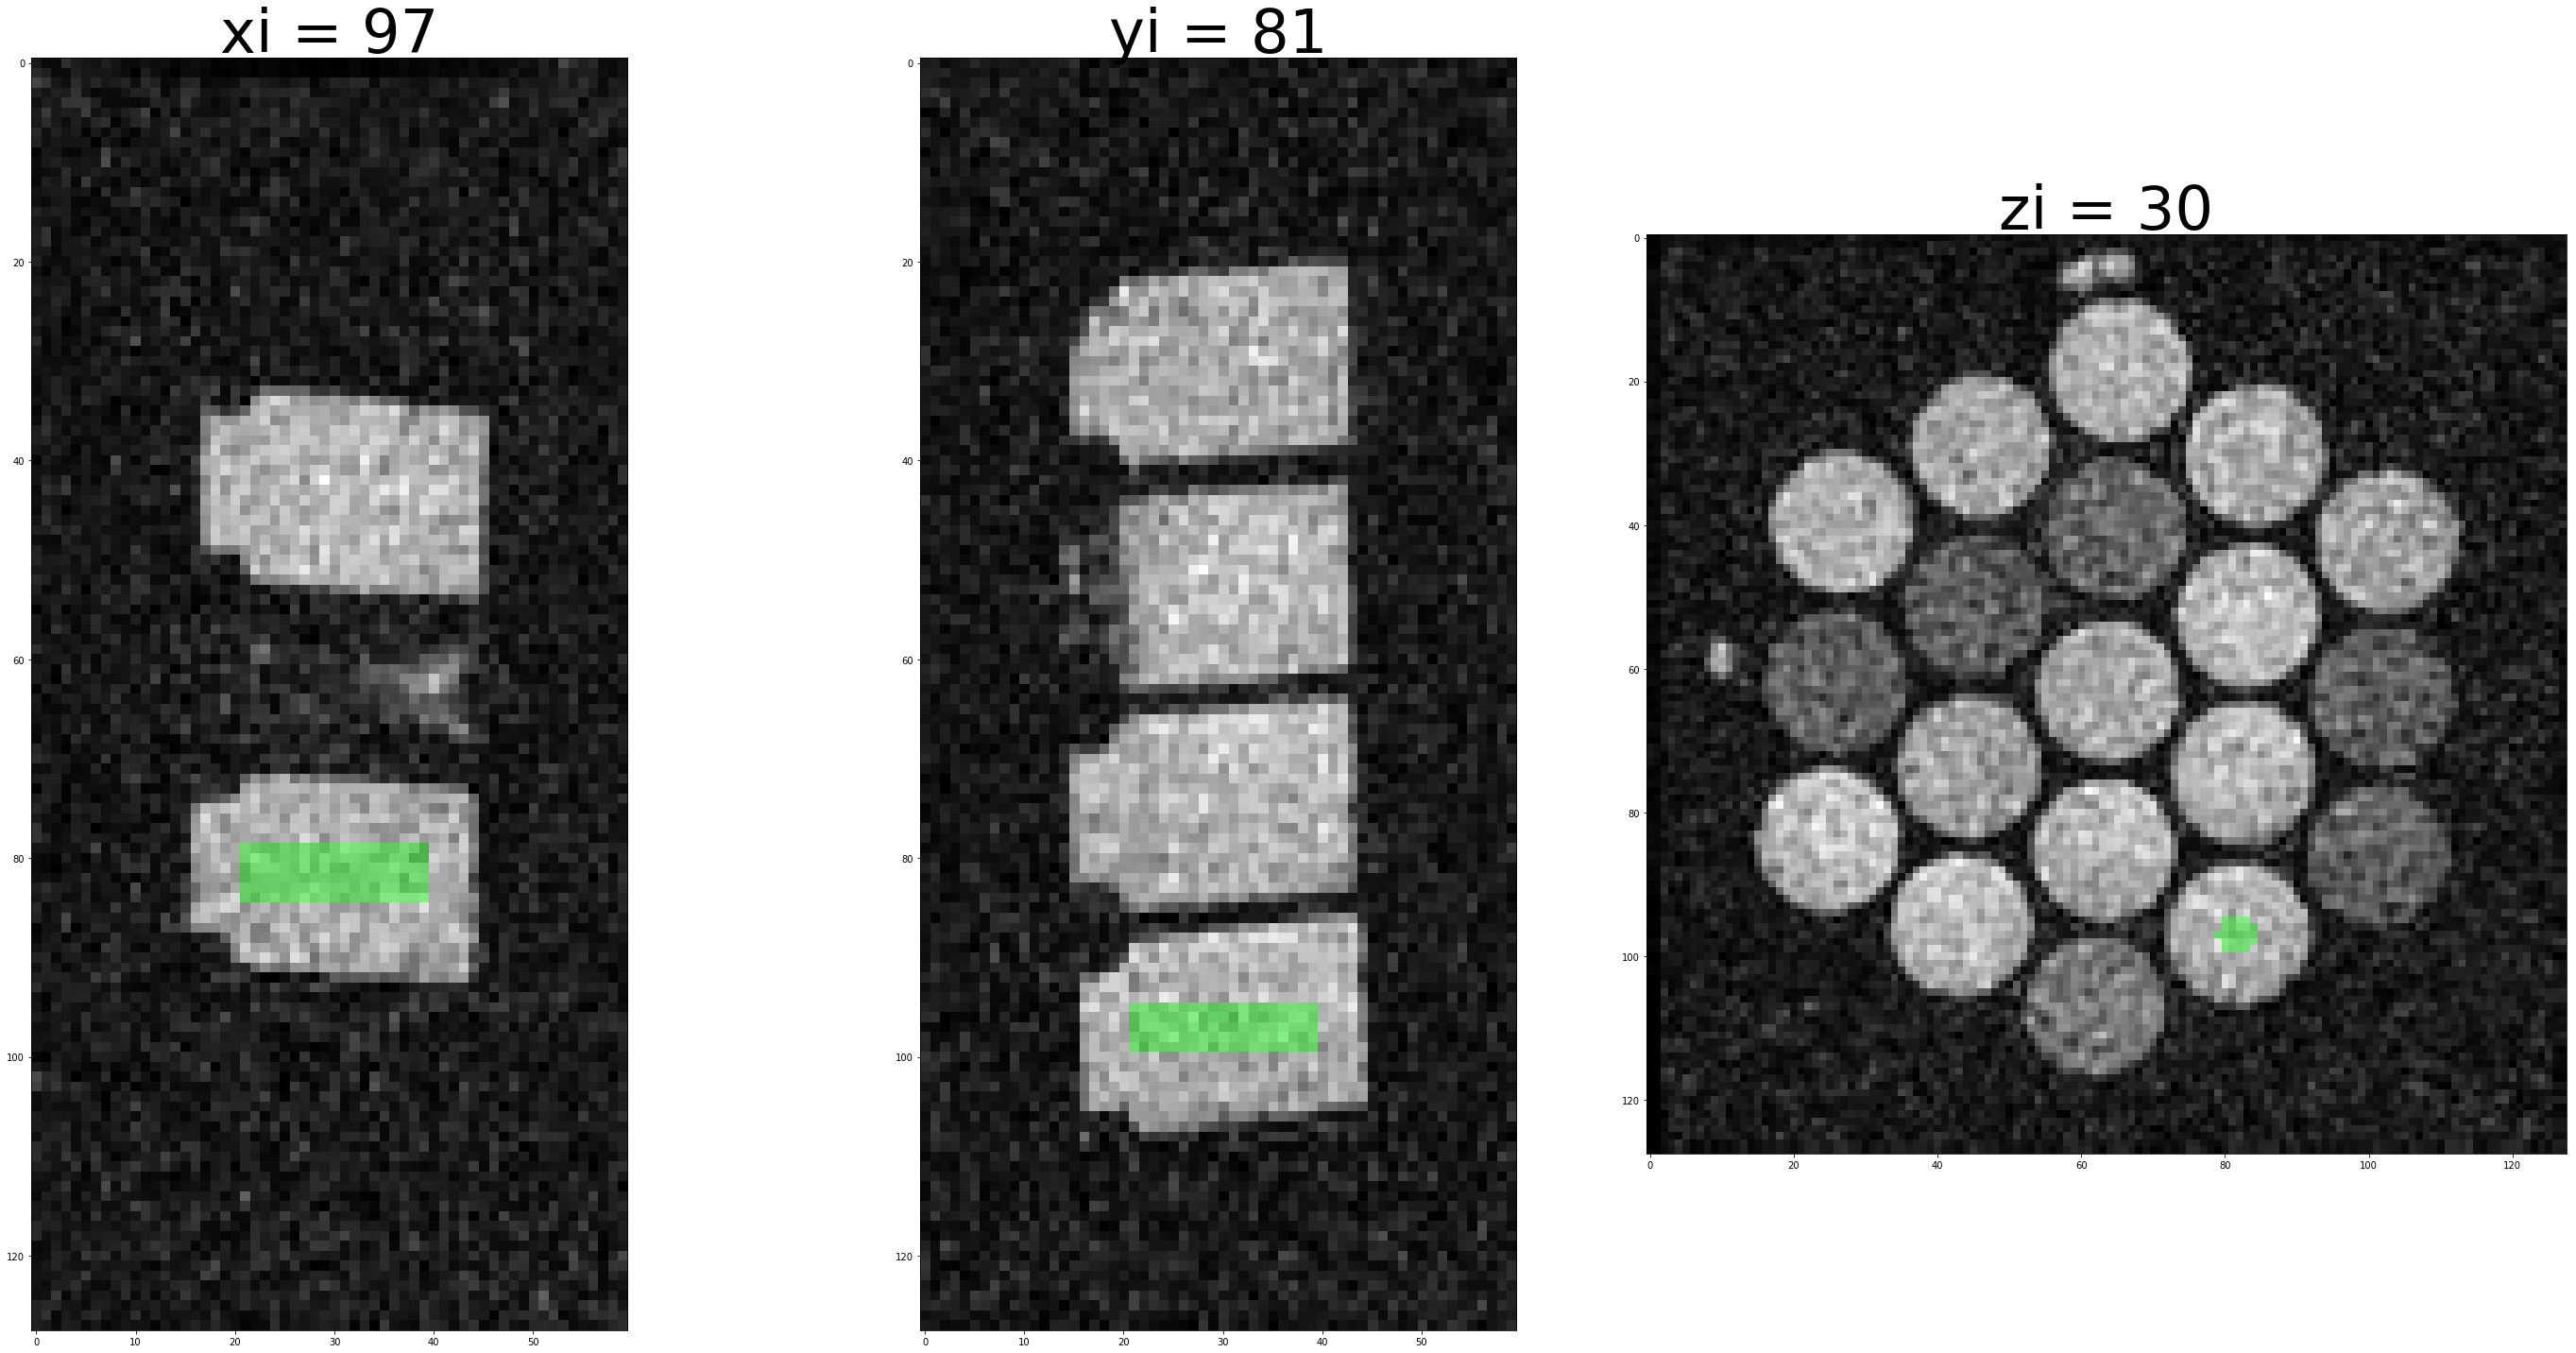

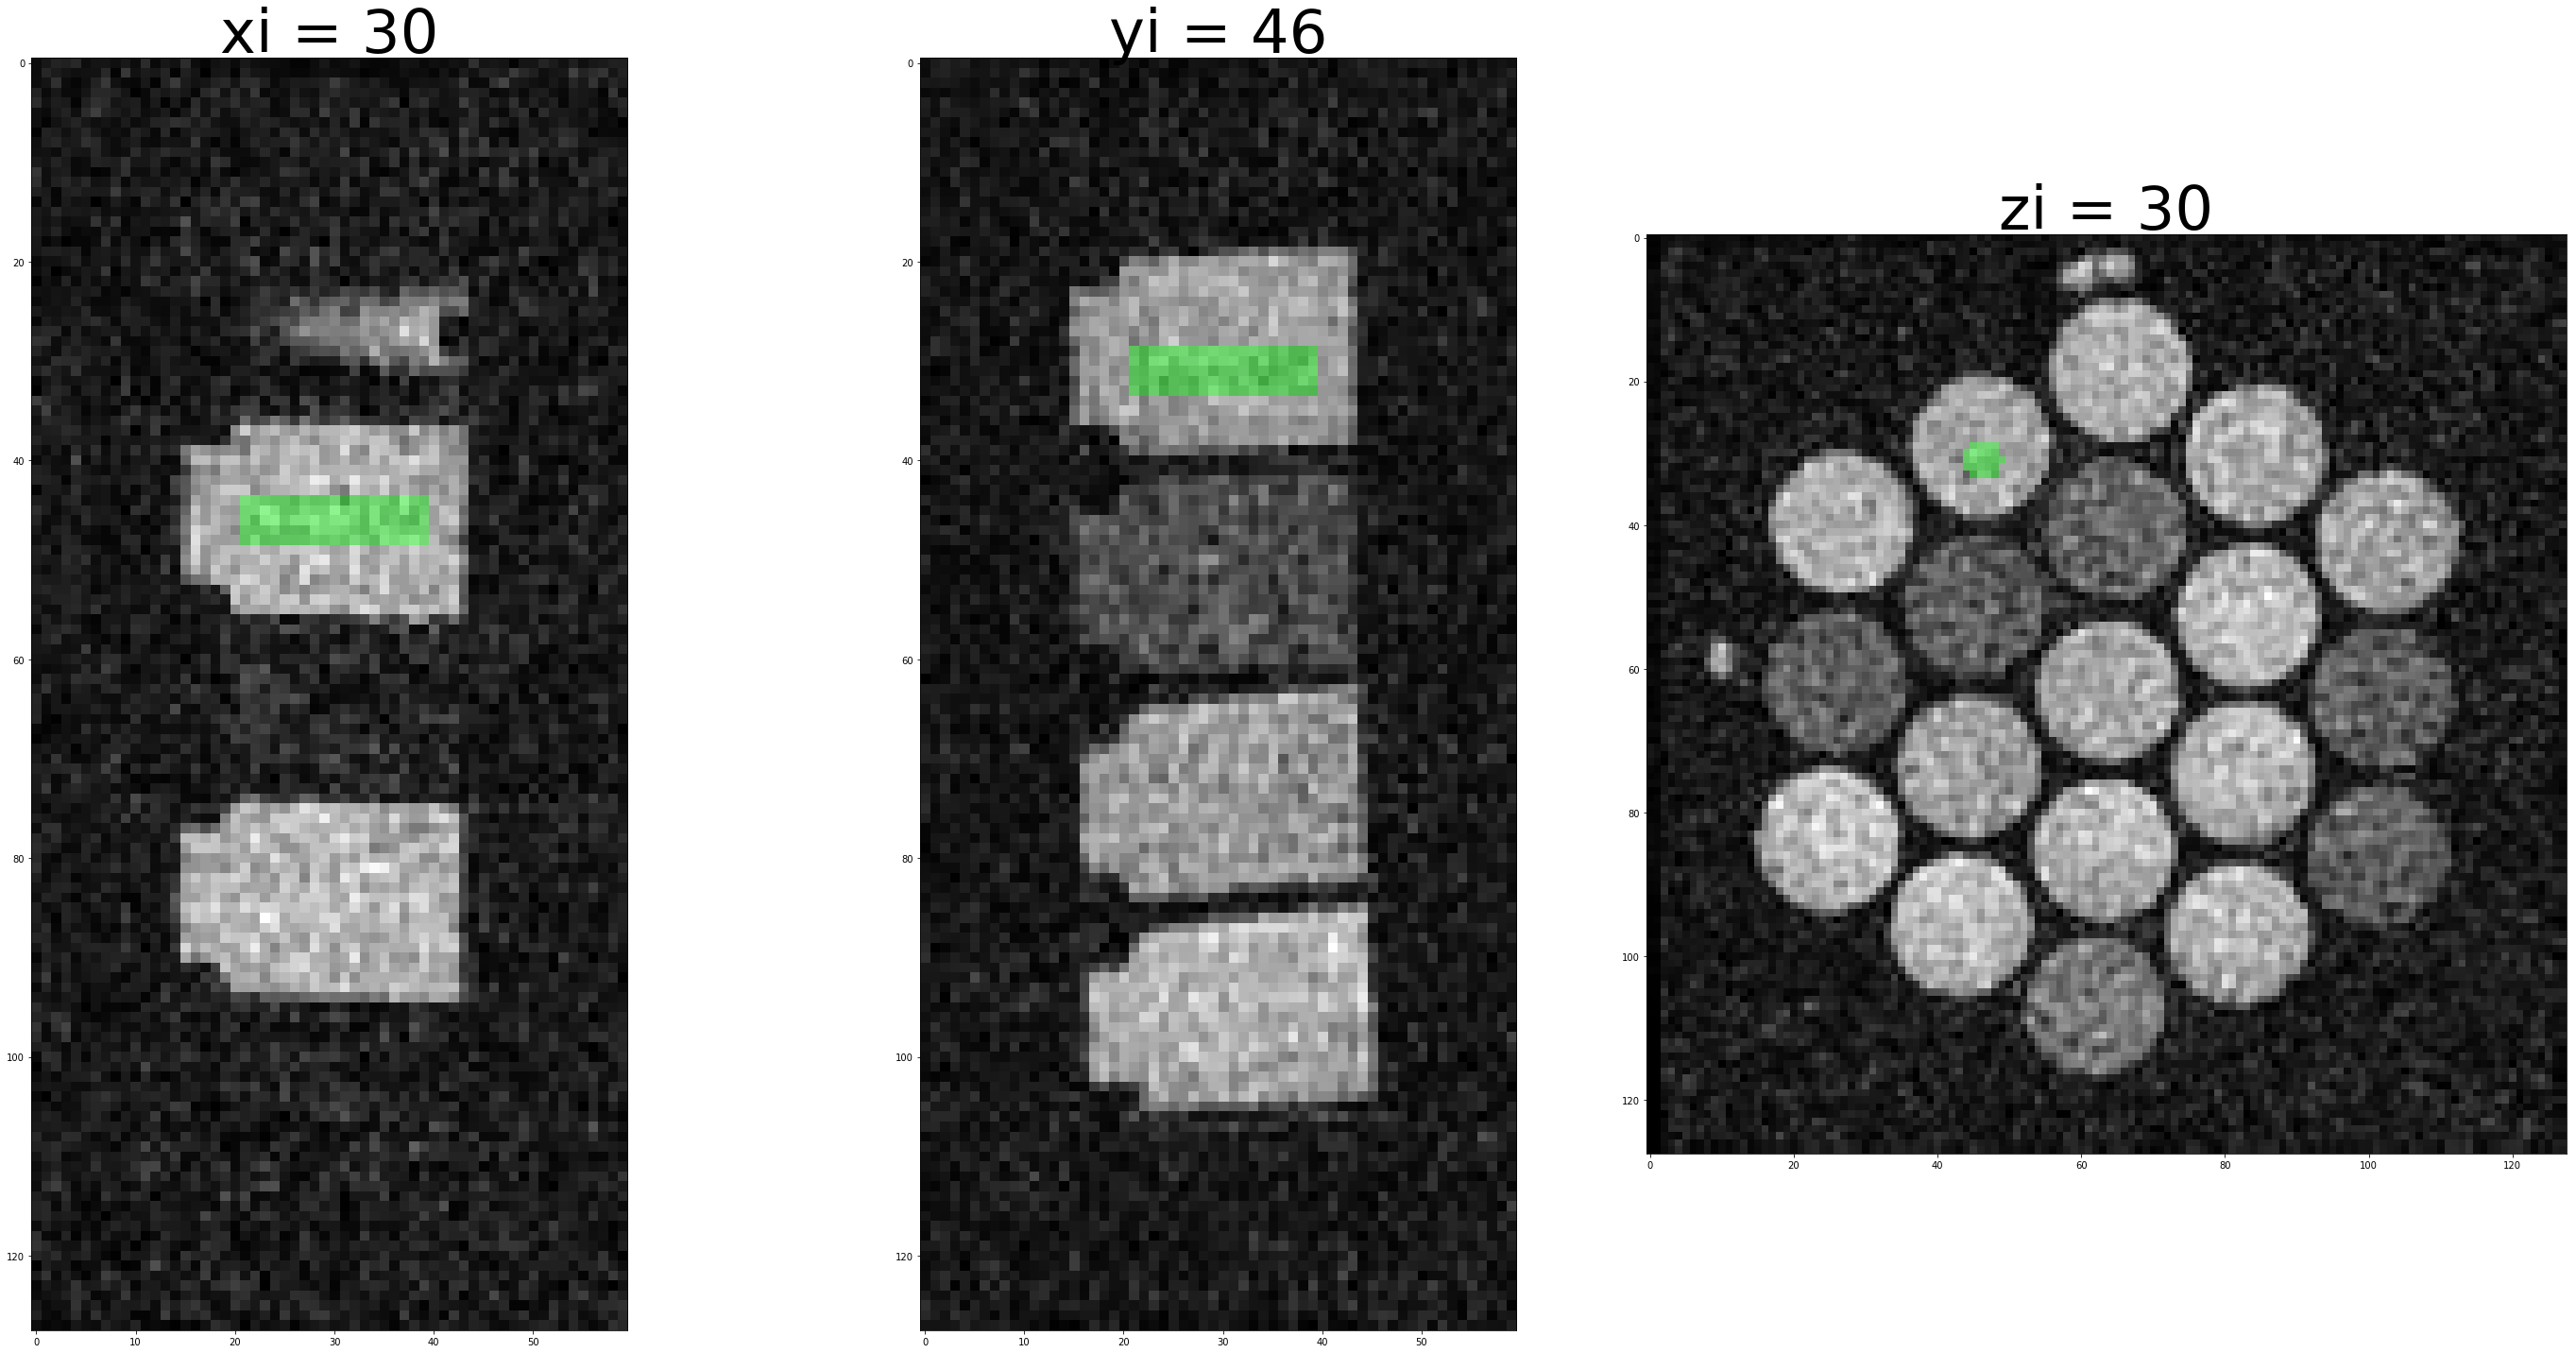

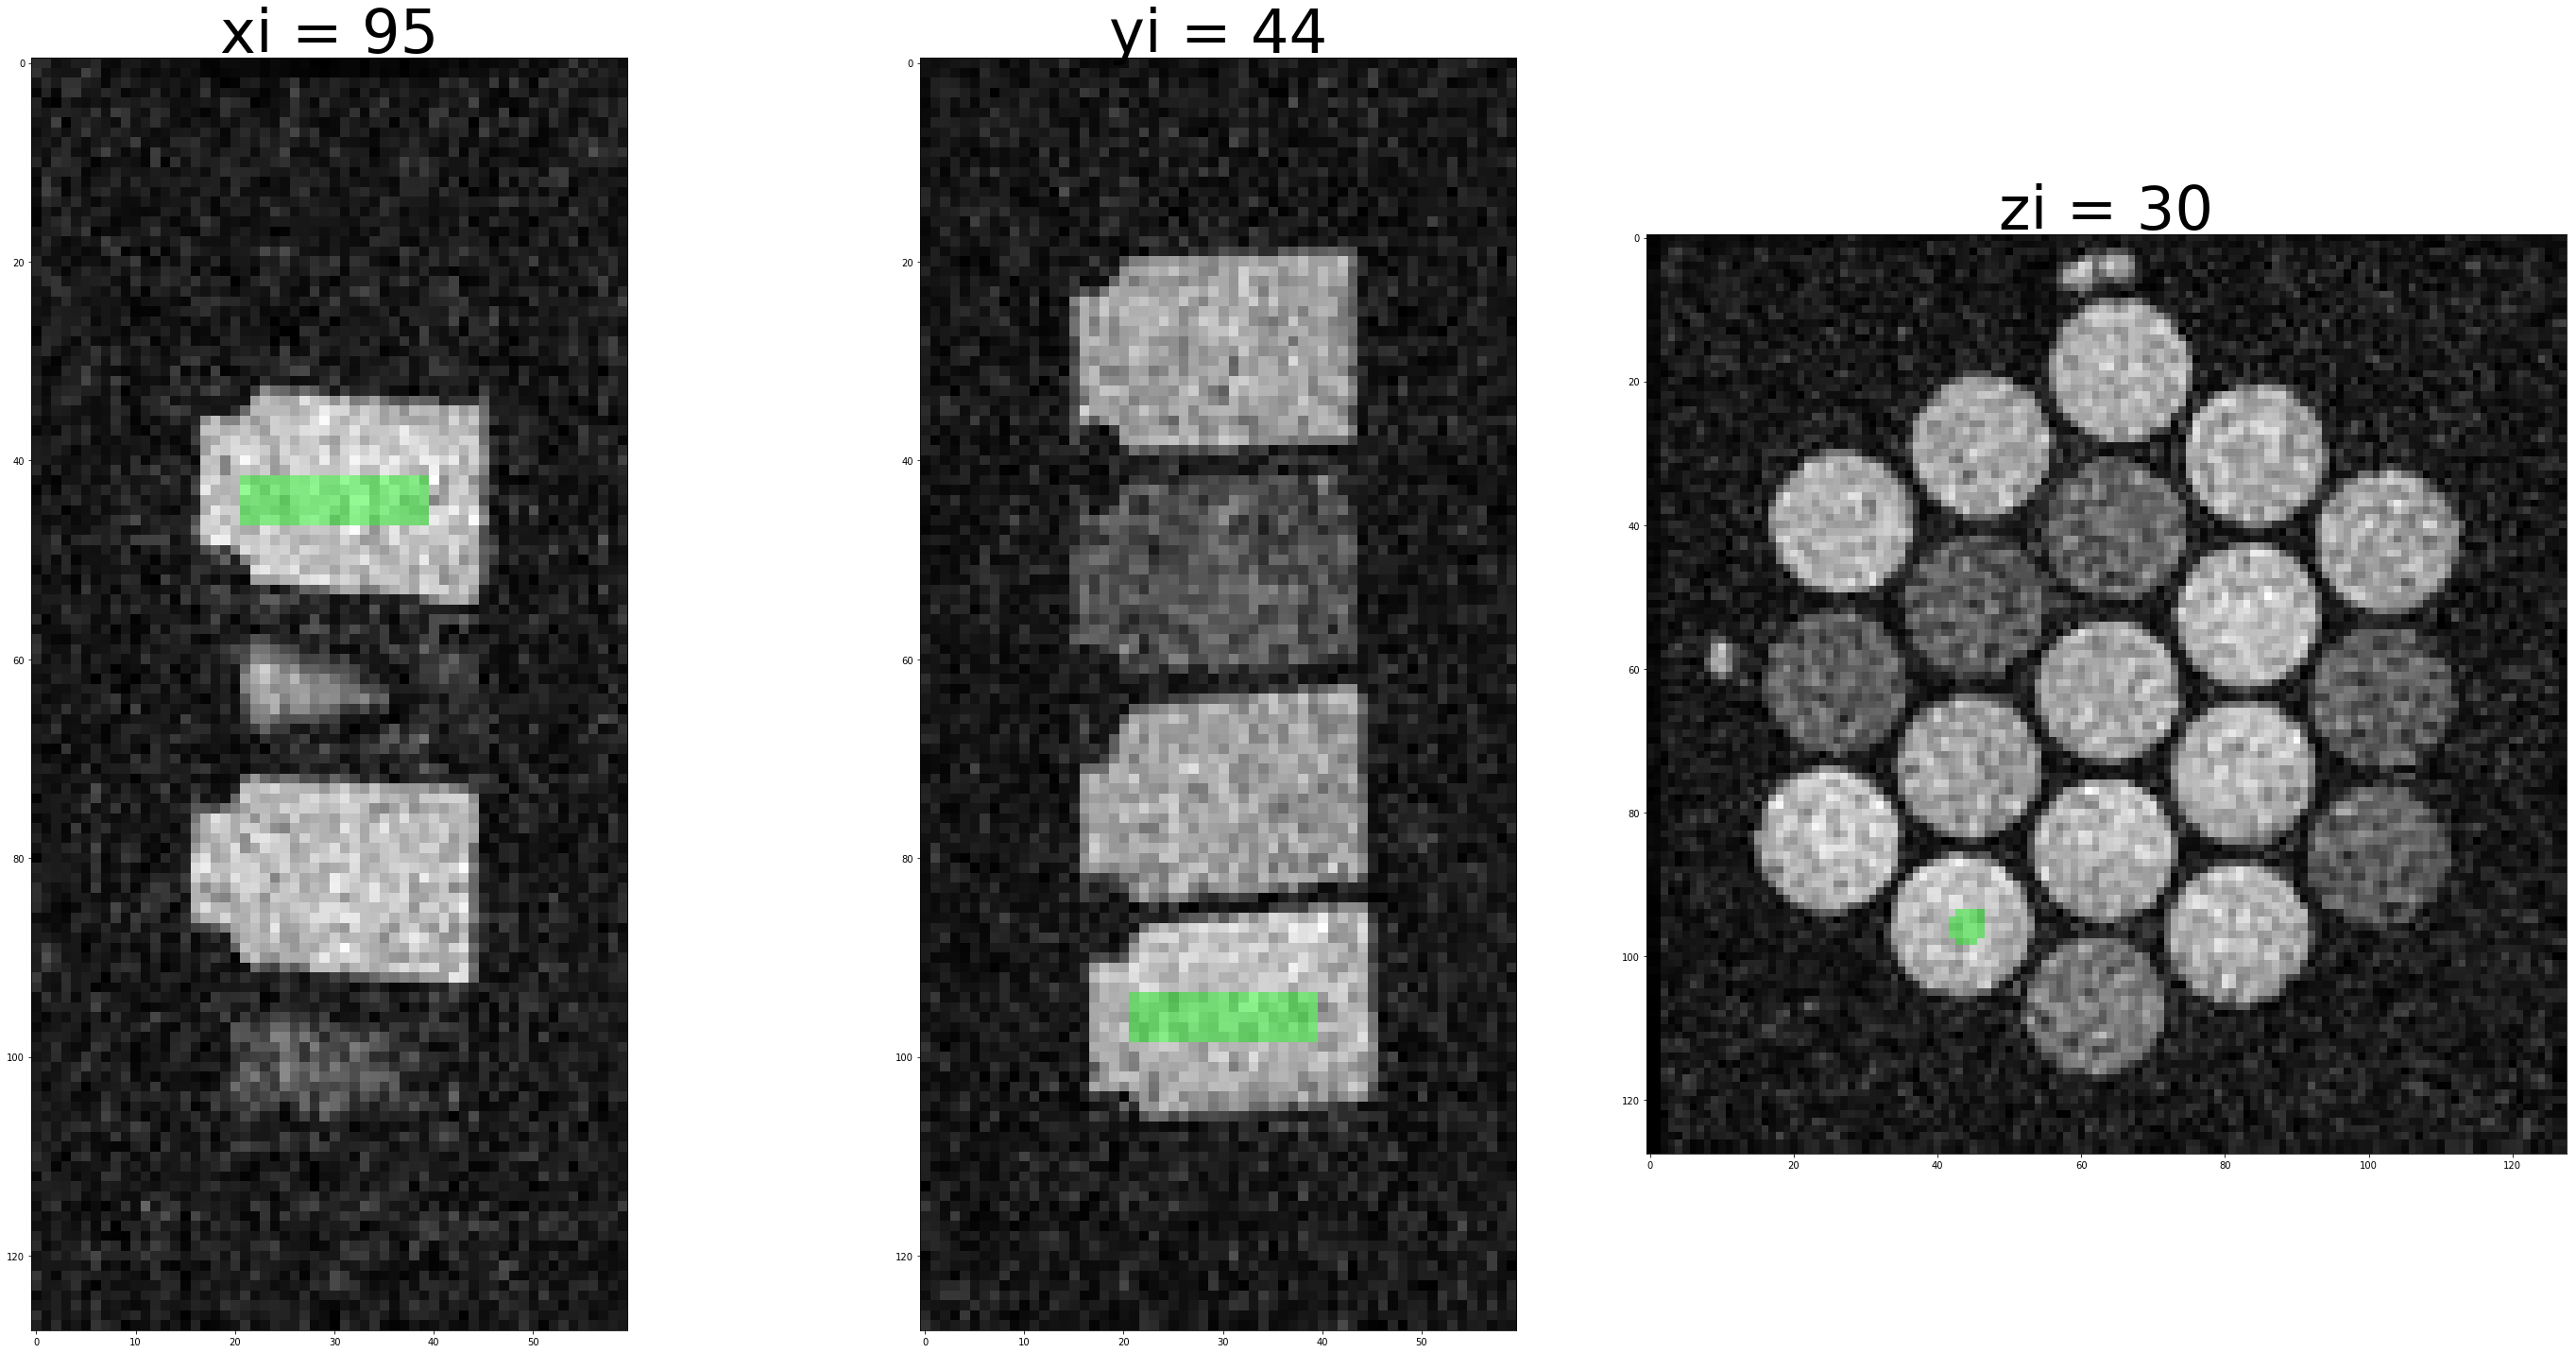

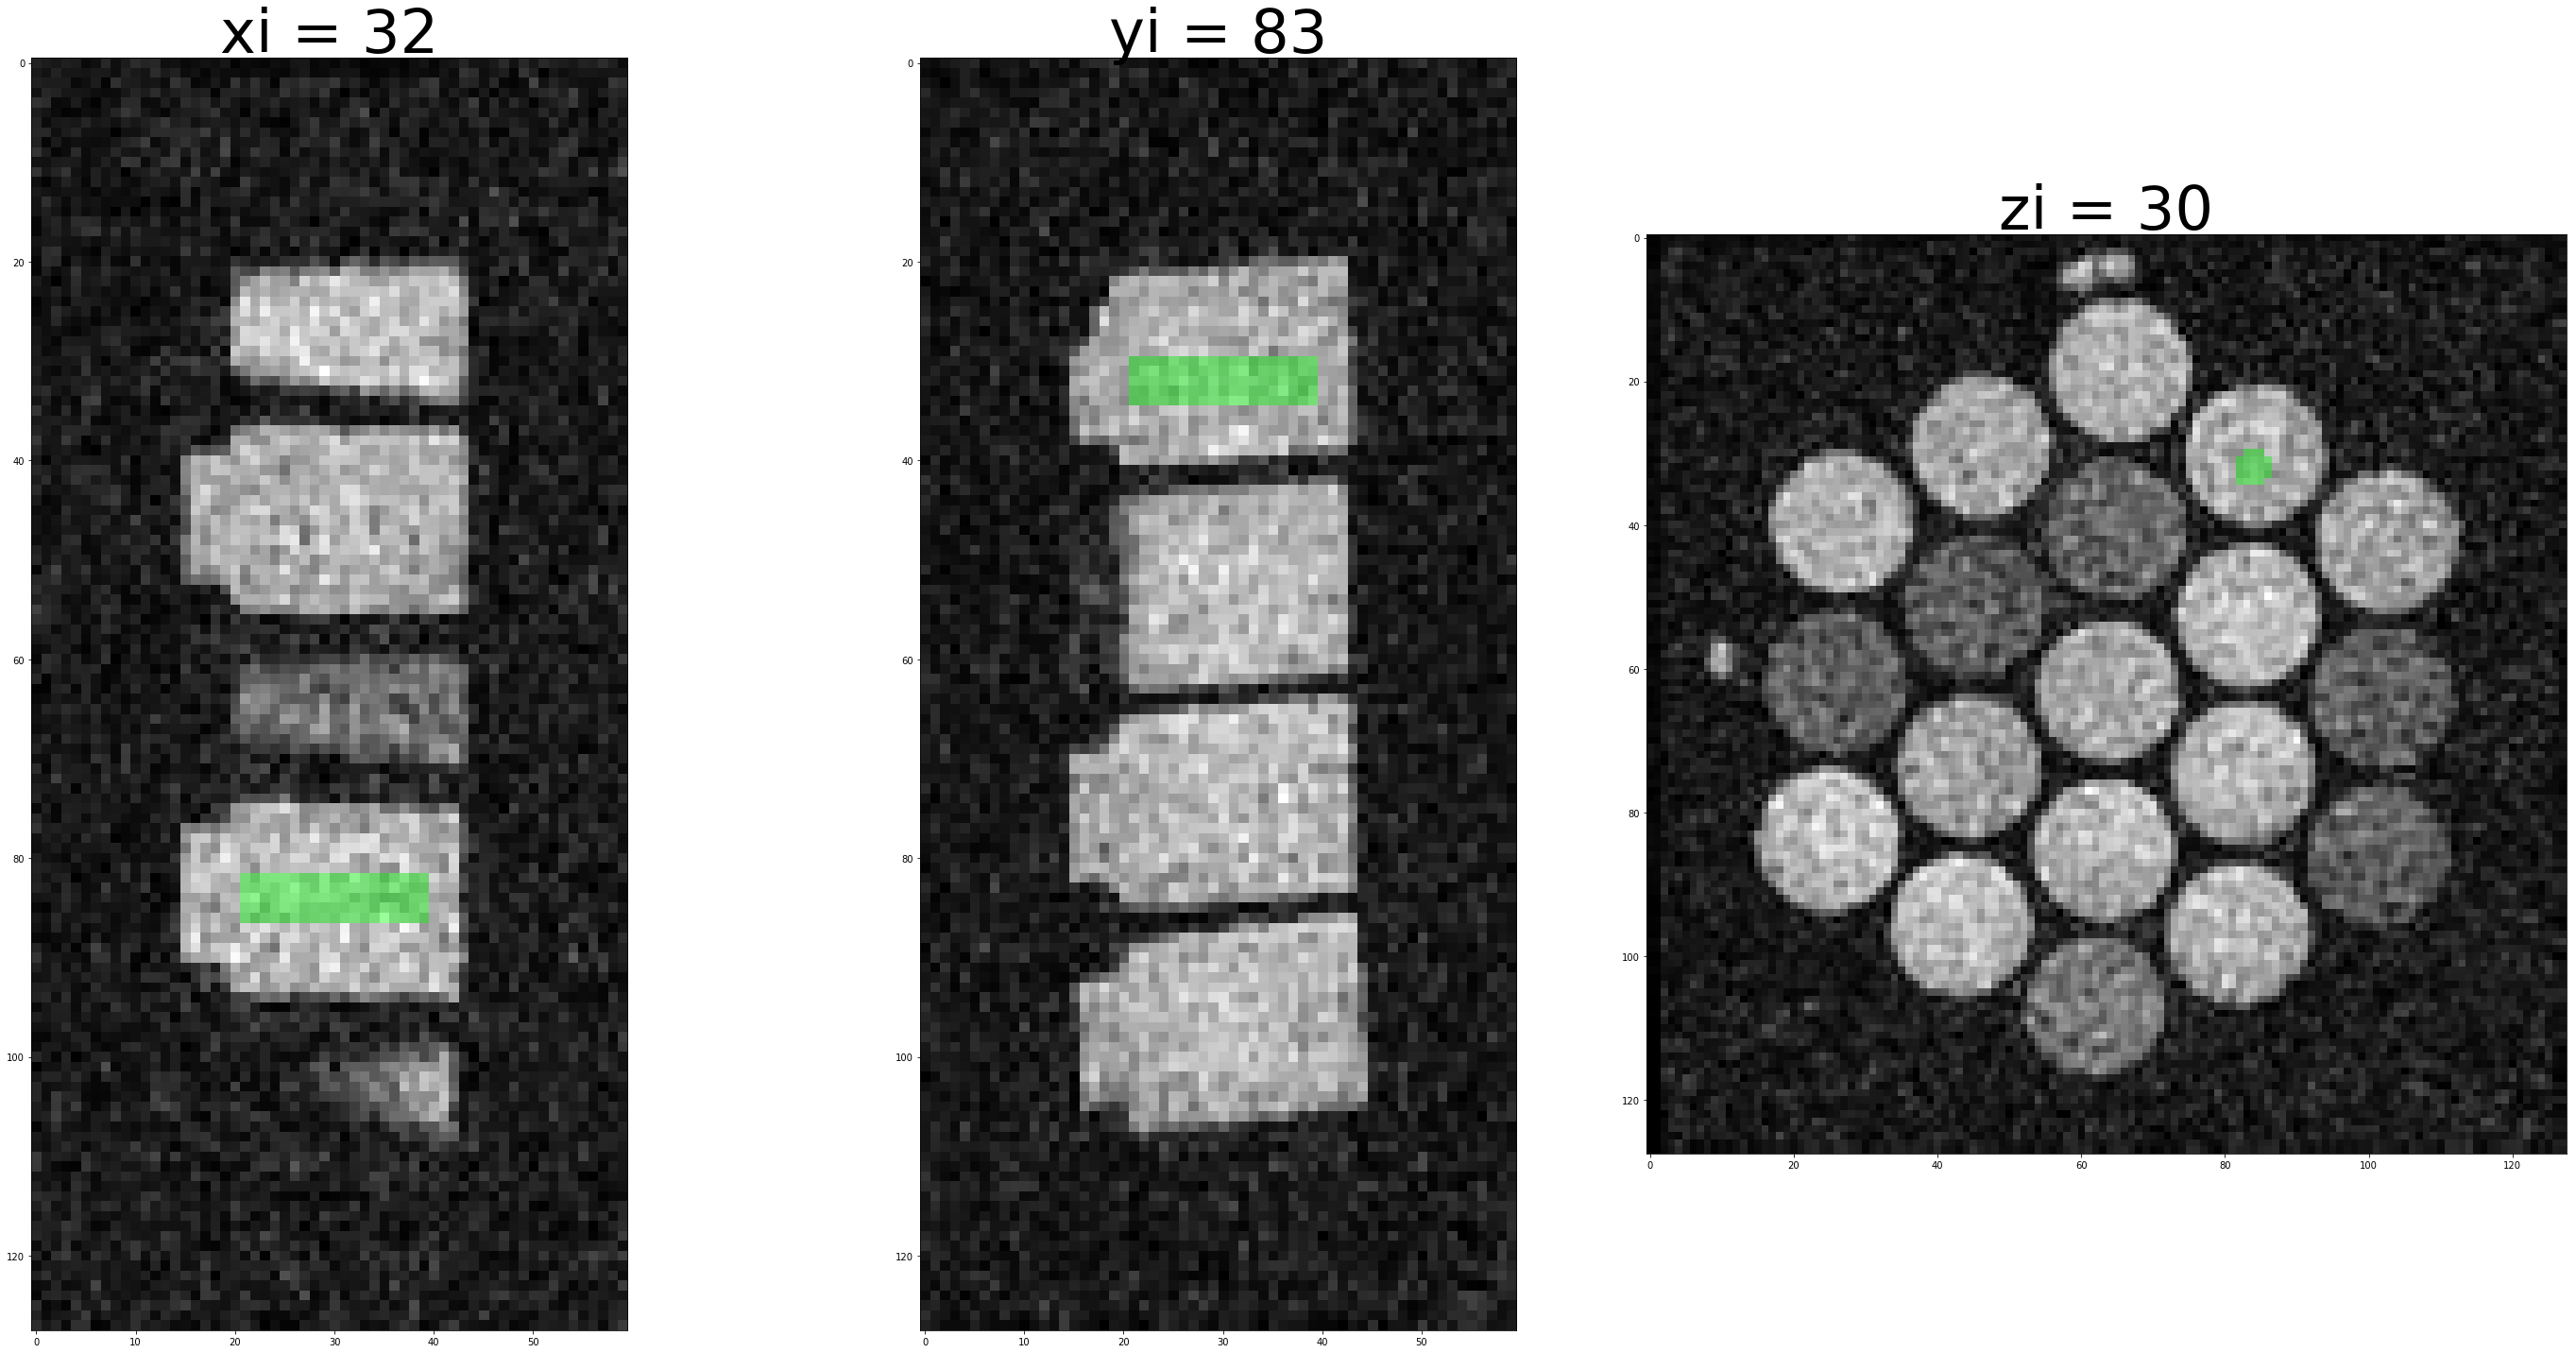

In [6]:
# Plot each ROI through the center

plt.close()
alpha = 0.4

for ci, roi in enumerate(roi_info):
    fig, ax = plt.subplots(1, 3, figsize=(40.0, 20.0))
    
    # Plot a slice in each axis through the ROI center
    cx, cy, cz = (
        int(roi['cx']/dx),
        int(roi['cy']/dy),
        int(roi['cz']/dz)
    )
        
    roi_data = np.zeros((nx, ny, nz, 4), dtype=np.float)
    roi_data[:,:,:,1] = roi['mask']
    roi_data[:,:,:,3] = alpha * roi['mask']
    
    ax[0].imshow(vol[cx,:,:], cmap=plt.cm.gray)
    ax[0].imshow(roi_data[cx,:,:,:])
    ax[0].set_title('xi = {:d}'.format(cx), fontsize=64)
    
    ax[1].imshow(vol[:,cy,:], cmap=plt.cm.gray)
    ax[1].imshow(roi_data[:,cy,:,:])
    ax[1].set_title('yi = {:d}'.format(cy), fontsize=64)
    
    ax[2].imshow(vol[:,:,cz], cmap=plt.cm.gray)
    ax[2].imshow(roi_data[:,:,cz,:])
    ax[2].set_title('zi = {:d}'.format(cz), fontsize=64)
    
    fig.patch.set_facecolor('white')
    fig.tight_layout()

plt.show()


In [7]:
# Compute ROI mean signal

for roi in roi_info:
    roi['vxsig_zte'] = []
    for zi in range(nz):
        for yi in range(ny):
            for xi in range(nx):
                if (roi['mask'][xi, yi, zi]):
                    roi['vxsig_zte'].append(vol[xi, yi, zi])
    
    roi['vxsig_zte'] = np.array(roi['vxsig_zte'], dtype=vol.dtype)
    roi['mean_zte_sig'] = np.mean(roi['vxsig_zte'])

['3: (W01.1) Water', '7: (A04.1) Propargyl Alcohol', '9: (A02.1) Acetone', '1: (A03.1) Isopropyl Alcohol']
5: (A06.1) Coconut Oil h_total (pred.) =      10.03%
11: (A05.1) Gelatin h_total (pred.) =          11.01%


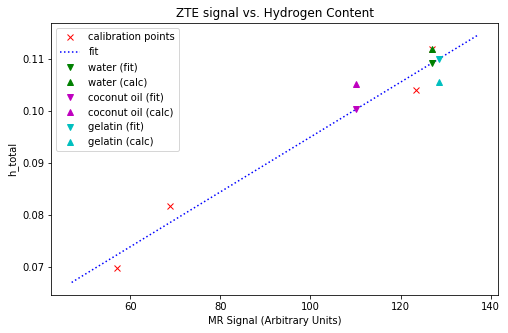

In [23]:
# Generate calibration curve (inner containers)

inner_containers = (3,7,9,1)
pdw_refs = np.array([roi_info[ci]['mean_zte_sig'] for ci in inner_containers])
print([roi_info[ci]['label'] for ci in inner_containers])
H_refs = np.array([
    0.111898344, # Water (W01.1) -> 3
    0.069864914, # Propargyl Alcohol (A04.1) -> 7
    0.081688083, # Acetone (A02.1) -> 9
    0.104127575, # Isopropyl Alcohol (A03.1) -> 1
])

fit = np.polyfit(pdw_refs, H_refs, 1)
fit_fn = np.poly1d(fit)

plt.close()
fig = plt.figure(figsize=(8.0,5.0))

plt.plot(pdw_refs, H_refs, 'rx', label='calibration points')
pdw_sig = np.linspace(min(pdw_refs)-10, max(pdw_refs)+10, 10)
plt.plot(pdw_sig, fit_fn(pdw_sig), 'b:', label='fit')
plt.title('ZTE signal vs. Hydrogen Content')
plt.xlabel('MR Signal (Arbitrary Units)')
plt.ylabel('h_total')

w=plt.plot(roi_info[3]['mean_zte_sig'], fit_fn(roi_info[3]['mean_zte_sig']), 'gv', label='water (fit)')
wa=plt.plot(roi_info[3]['mean_zte_sig'], .112, 'g^', label='water (calc)')
c=plt.plot(roi_info[5]['mean_zte_sig'], fit_fn(roi_info[5]['mean_zte_sig']), 'mv', label='coconut oil (fit)')
ca=plt.plot(roi_info[5]['mean_zte_sig'], 0.1053, 'm^', label='coconut oil (calc)')
g=plt.plot(roi_info[11]['mean_zte_sig'], fit_fn(roi_info[11]['mean_zte_sig']), 'cv', label='gelatin (fit)')
ga=plt.plot(roi_info[11]['mean_zte_sig'], 0.1057, 'c^', label='gelatin (calc)')

print('{:s} h_total (pred.) = {:10.2f}%'.format(roi_info[5]['label'],fit_fn(roi_info[5]['mean_zte_sig'])*100.0))
print('{:s} h_total (pred.) = {:14.2f}%'.format(roi_info[11]['label'],fit_fn(roi_info[11]['mean_zte_sig'])*100.0))


plt.legend()

fig.patch.set_facecolor('white')
fig.savefig('PD_quant.png')
plt.show()

['1: (A03.1) Isopropyl Alcohol', '9: (A02.1) Acetone', '7: (A04.1) Propargyl Alcohol', '3: (W01.1) Water']
11: (A05.1) Gelatin h_total (pred.) =      10.87%
5: (A06.1) Coconut Oil h_total (pred.) =           9.97%


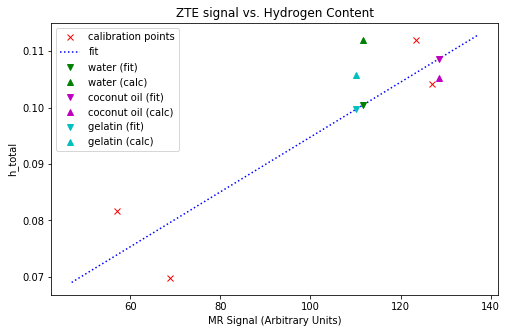

In [9]:
# Generate calibration curve (outer containers)

ref_containers = (4,8,10,3)
pdw_refs = np.array([roi_info[ci]['mean_zte_sig'] for ci in ref_containers])
print([roi_info[ci]['label'] for ci in ref_containers])
H_refs = np.array([
    0.111898344, # Water (W01.2) -> 4
    0.069864914, # Propargyl Alcohol (A04.2) -> 8
    0.081688083, # Acetone (A02.2) -> 10
    0.104127575, # Isopropyl Alcohol (A03.2) -> 3
])

fit = np.polyfit(pdw_refs, H_refs, 1)
fit_fn = np.poly1d(fit)

plt.close()
fig = plt.figure(figsize=(8.0,5.0))

plt.plot(pdw_refs, H_refs, 'rx', label='calibration points')
pdw_sig = np.linspace(min(pdw_refs)-10, max(pdw_refs)+10, 10)
plt.plot(pdw_sig, fit_fn(pdw_sig), 'b:', label='fit')
plt.title('ZTE signal vs. Hydrogen Content')
plt.xlabel('MR Signal (Arbitrary Units)')
plt.ylabel('h_total')

w=plt.plot(roi_info[0]['mean_zte_sig'], fit_fn(roi_info[0]['mean_zte_sig']), 'gv', label='water (fit)')
wa=plt.plot(roi_info[0]['mean_zte_sig'], .112, 'g^', label='water (calc)')
c=plt.plot(roi_info[11]['mean_zte_sig'], fit_fn(roi_info[11]['mean_zte_sig']), 'mv', label='coconut oil (fit)')
ca=plt.plot(roi_info[11]['mean_zte_sig'], 0.1053, 'm^', label='coconut oil (calc)')
g=plt.plot(roi_info[5]['mean_zte_sig'], fit_fn(roi_info[5]['mean_zte_sig']), 'cv', label='gelatin (fit)')
ga=plt.plot(roi_info[5]['mean_zte_sig'], 0.1057, 'c^', label='gelatin (calc)')

print('{:s} h_total (pred.) = {:10.2f}%'.format(roi_info[11]['label'],fit_fn(roi_info[11]['mean_zte_sig'])*100.0))
print('{:s} h_total (pred.) = {:14.2f}%'.format(roi_info[5]['label'],fit_fn(roi_info[5]['mean_zte_sig'])*100.0))

plt.legend()

fig.patch.set_facecolor('white')
fig.savefig('PD_quant.png')
plt.show()

['0: (D01) Deuterium Oxide 10%', '8: (A04.2) Propargyl Alcohol', '6: (A06.2) Coconut Oil', '2: (A03.2) Isopropyl Alcohol']
10: (A02.2) Acetone h_total (pred.) =       7.84%
4: (W01.2) Water h_total (pred.) =          10.20%
['1: (A03.1) Isopropyl Alcohol', '9: (A02.1) Acetone', '7: (A04.1) Propargyl Alcohol', '3: (W01.1) Water']
11: (A05.1) Gelatin h_total (pred.) =      10.87%
5: (A06.1) Coconut Oil h_total (pred.) =           9.97%


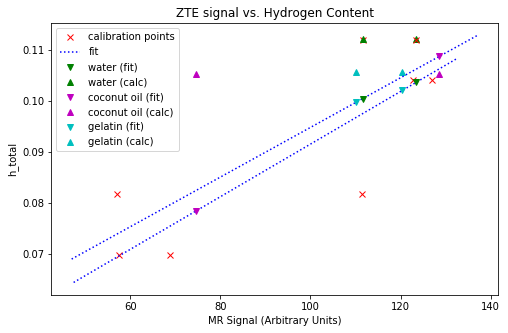

In [10]:
# Generate calibration curve (inner containers)

inner_containers = (3,7,9,1)
pdw_refs = np.array([roi_info[ci]['mean_zte_sig'] for ci in inner_containers])
print([roi_info[ci]['label'] for ci in inner_containers])
H_refs = np.array([
    0.111898344, # Water (W01.1) -> 3
    0.069864914, # Propargyl Alcohol (A04.1) -> 7
    0.081688083, # Acetone (A02.1) -> 9
    0.104127575, # Isopropyl Alcohol (A03.1) -> 1
])

fit = np.polyfit(pdw_refs, H_refs, 1)
fit_fn = np.poly1d(fit)

plt.close()
fig = plt.figure(figsize=(8.0,5.0))

plt.plot(pdw_refs, H_refs, 'rx', label='calibration points')
pdw_sig = np.linspace(min(pdw_refs)-10, max(pdw_refs)+10, 10)
plt.plot(pdw_sig, fit_fn(pdw_sig), 'b:', label='fit')
plt.title('ZTE signal vs. Hydrogen Content')
plt.xlabel('MR Signal (Arbitrary Units)')
plt.ylabel('h_total')

w=plt.plot(roi_info[3]['mean_zte_sig'], fit_fn(roi_info[3]['mean_zte_sig']), 'gv', label='water (fit)')
wa=plt.plot(roi_info[3]['mean_zte_sig'], .112, 'g^', label='water (calc)')
c=plt.plot(roi_info[5]['mean_zte_sig'], fit_fn(roi_info[5]['mean_zte_sig']), 'mv', label='coconut oil (fit)')
ca=plt.plot(roi_info[5]['mean_zte_sig'], 0.1053, 'm^', label='coconut oil (calc)')
g=plt.plot(roi_info[11]['mean_zte_sig'], fit_fn(roi_info[11]['mean_zte_sig']), 'cv', label='gelatin (fit)')
ga=plt.plot(roi_info[11]['mean_zte_sig'], 0.1057, 'c^', label='gelatin (calc)')

print('{:s} h_total (pred.) = {:10.2f}%'.format(roi_info[5]['label'],fit_fn(roi_info[5]['mean_zte_sig'])*100.0))
print('{:s} h_total (pred.) = {:14.2f}%'.format(roi_info[11]['label'],fit_fn(roi_info[11]['mean_zte_sig'])*100.0))


plt.legend()

# Generate calibration curve (outer containers)

ref_containers = (1,9,7,3)
pdw_refs = np.array([roi_info[ci]['mean_zte_sig'] for ci in ref_containers])
print([roi_info[ci]['label'] for ci in ref_containers])
H_refs = np.array([
    0.111898344, # Water (W01.2) -> 1
    0.069864914, # Propargyl Alcohol (A04.2) -> 9
    0.081688083, # Acetone (A02.2) -> 7
    0.104127575, # Isopropyl Alcohol (A03.2) -> 3
])

fit = np.polyfit(pdw_refs, H_refs, 1)
fit_fn = np.poly1d(fit)

plt.plot(pdw_refs, H_refs, 'rx', label='calibration points')
pdw_sig = np.linspace(min(pdw_refs)-10, max(pdw_refs)+10, 10)
plt.plot(pdw_sig, fit_fn(pdw_sig), 'b:', label='fit')
plt.title('ZTE signal vs. Hydrogen Content')
plt.xlabel('MR Signal (Arbitrary Units)')
plt.ylabel('h_total')

w=plt.plot(roi_info[0]['mean_zte_sig'], fit_fn(roi_info[0]['mean_zte_sig']), 'gv', label='water (fit)')
wa=plt.plot(roi_info[0]['mean_zte_sig'], .112, 'g^', label='water (calc)')
c=plt.plot(roi_info[11]['mean_zte_sig'], fit_fn(roi_info[11]['mean_zte_sig']), 'mv', label='coconut oil (fit)')
ca=plt.plot(roi_info[11]['mean_zte_sig'], 0.1053, 'm^', label='coconut oil (calc)')
g=plt.plot(roi_info[5]['mean_zte_sig'], fit_fn(roi_info[5]['mean_zte_sig']), 'cv', label='gelatin (fit)')
ga=plt.plot(roi_info[5]['mean_zte_sig'], 0.1057, 'c^', label='gelatin (calc)')

print('{:s} h_total (pred.) = {:10.2f}%'.format(roi_info[11]['label'],fit_fn(roi_info[11]['mean_zte_sig'])*100.0))
print('{:s} h_total (pred.) = {:14.2f}%'.format(roi_info[5]['label'],fit_fn(roi_info[5]['mean_zte_sig'])*100.0))

fig.patch.set_facecolor('white')
fig.savefig('PD_quant.png')
plt.show()

['3: (W01.1) Water', '7: (A04.1) Propargyl Alcohol', '9: (A02.1) Acetone', '1: (A03.1) Isopropyl Alcohol', '4: (W01.2) Water', '8: (A04.2) Propargyl Alcohol', '10: (A02.2) Acetone', '2: (A03.2) Isopropyl Alcohol']
5: (A06.1) Coconut Oil h_total (pred.) =      10.08%
11: (A05.1) Gelatin h_total (pred.) =          11.10%
6: (A06.2) Coconut Oil h_total (pred.) =      10.15%
12: (A05.2) Gelatin h_total (pred.) =          10.81%


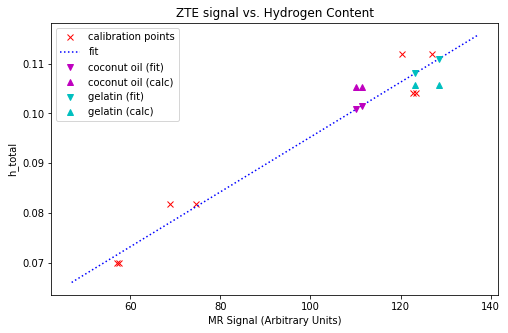

In [22]:
# Generate calibration curve (all containers)

ref_containers = (3,7,9,1,4,8,10,2)
pdw_refs = np.array([roi_info[ci]['mean_zte_sig'] for ci in ref_containers])
print([roi_info[ci]['label'] for ci in ref_containers])
H_refs = np.array([
    0.111898344, # Water (W01.1) -> 3
    0.069864914, # Propargyl Alcohol (A04.1) -> 7
    0.081688083, # Acetone (A02.1) -> 9
    0.104127575, # Isopropyl Alcohol (A03.1) -> 1
    0.111898344, # Water (W01.2) -> 4
    0.069864914, # Propargyl Alcohol (A04.2) -> 8
    0.081688083, # Acetone (A02.2) -> 10
    0.104127575, # Isopropyl Alcohol (A03.2) -> 2
])

fit = np.polyfit(pdw_refs, H_refs, 1)
fit_fn = np.poly1d(fit)

plt.close()
fig = plt.figure(figsize=(8.0,5.0))

plt.plot(pdw_refs, H_refs, 'rx', label='calibration points')
pdw_sig = np.linspace(min(pdw_refs)-10, max(pdw_refs)+10, 10)
plt.plot(pdw_sig, fit_fn(pdw_sig), 'b:', label='fit')
plt.title('ZTE signal vs. Hydrogen Content')
plt.xlabel('MR Signal (Arbitrary Units)')
plt.ylabel('h_total')


c1=plt.plot(roi_info[5]['mean_zte_sig'], fit_fn(roi_info[5]['mean_zte_sig']), 'mv', label='coconut oil (fit)')
ca1=plt.plot(roi_info[5]['mean_zte_sig'], 0.1053, 'm^', label='coconut oil (calc)')
g1=plt.plot(roi_info[11]['mean_zte_sig'], fit_fn(roi_info[11]['mean_zte_sig']), 'cv', label='gelatin (fit)')
ga1=plt.plot(roi_info[11]['mean_zte_sig'], 0.1057, 'c^', label='gelatin (calc)')
c2=plt.plot(roi_info[6]['mean_zte_sig'], fit_fn(roi_info[6]['mean_zte_sig']), 'mv')
ca2=plt.plot(roi_info[6]['mean_zte_sig'], 0.1053, 'm^')
g2=plt.plot(roi_info[12]['mean_zte_sig'], fit_fn(roi_info[12]['mean_zte_sig']), 'cv')
ga2=plt.plot(roi_info[12]['mean_zte_sig'], 0.1057, 'c^')

print('{:s} h_total (pred.) = {:10.2f}%'.format(roi_info[5]['label'],fit_fn(roi_info[5]['mean_zte_sig'])*100.0))
print('{:s} h_total (pred.) = {:14.2f}%'.format(roi_info[11]['label'],fit_fn(roi_info[11]['mean_zte_sig'])*100.0))
print('{:s} h_total (pred.) = {:10.2f}%'.format(roi_info[6]['label'],fit_fn(roi_info[6]['mean_zte_sig'])*100.0))
print('{:s} h_total (pred.) = {:14.2f}%'.format(roi_info[12]['label'],fit_fn(roi_info[12]['mean_zte_sig'])*100.0))

plt.legend()

fig.patch.set_facecolor('white')
fig.savefig('PD_quant_all_containers.png')
plt.show()

for roi in roi_info:
    roi['fit_1H_frac'] = fit_fn(roi['mean_zte_sig'])


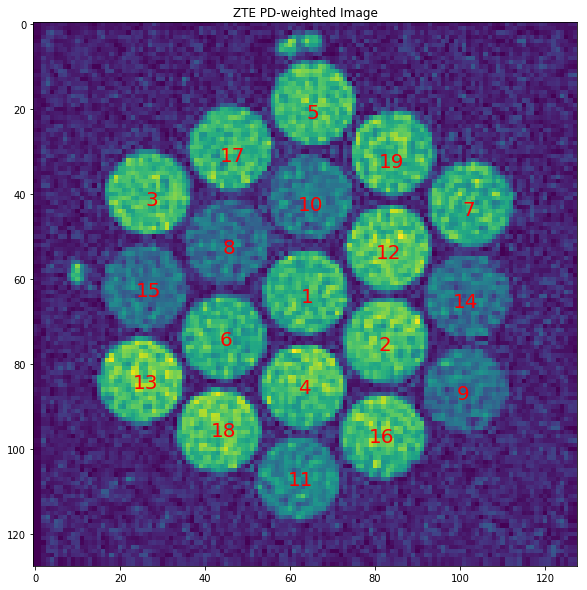

In [12]:
plt.close()
fig = plt.figure(figsize=(10.0, 10.0))

sli = int(nz/2)
scl_slice = (vol[:,:,sli] - np.min(vol[:,:,sli]))/(np.max(vol[:,:,sli]) - np.min(vol[:,:,sli]))
plt.imshow(scl_slice)

for ci,roi in enumerate(roi_info):
    cx = roi['cx']/dx
    cy = roi['cy']/dy
    #plt.plot(cx, cy, 'rx')
    th = np.linspace(0.0, 2*np.pi, 100)
    xx = rc/dy * np.cos(th) + cy
    yy = rc/dx * np.sin(th) + cx
    #plt.plot(xx, yy, 'r')
    plt.text(cy, cx, '{:d}'.format(ci+1), fontdict = {
        'color': 'red',
        'fontsize': 20,
        'horizontalalignment' : 'center',
        'verticalalignment' : 'center'
    })

fig.patch.set_facecolor('white')
plt.title('ZTE PD-weighted Image')
plt.show()

fig.savefig('ZTE_labeled_slice.svg')

In [13]:
import json
import re

cid_re = re.compile('[A-Z][0-9]{2}\.?[0-9]?')

results = {}
for roi in roi_info:
    cid = cid_re.search(roi['label']).group()
    results[cid] = {
        'label' : roi['label'],
        'data' : {
            'ZTE Mean Signal' : roi['mean_zte_sig'],
            'Fit Proton Density (Mass Fraction)' : roi['fit_1H_frac']
        }
    }

with open('zte-results.json','w') as jout:
    jout.write(json.dumps(results, indent=4, sort_keys=True))
